# Information on How These Data Are Organized:

`TypeOfResponse` refers to whether participants pressed a button ("SCResp") or did not press a button ("SCRespITI") within the given time frame.

`Version` refers to the task version. We counterbalanced for block order: version 9: MIC-MIC-MC-MC + version 10: MC-MC-MIC-MIC. Color-word assignment to the PC manipulation was randomized across participants.

`LogCounter` gets added to whenever the JS records a new datapoint.

`TrialCounter` gets added to whenever a new trial has started. This is reset at the start of each block.

`MatrixCounter` gets added to throughout the task and is never reset. It is what I use to call Stimuli #s.

`ImageCounter` refers to how I cycle through the images for the trial-unique feedback participants receive.

`RunCounter` refers to the run. The first run was a practice run of 120 congruent trials (20/key), just so participants were acclimated to the S-R mappings. Afterwards, each run was its own mostly congruent or incongruent block. This meant that only 4/6 items were presented in each run.

`TrialType` refers to whether the trial was a congruent (1) or incongruent trial (0).

`ContextType` refers to whether the block/run is a mostly incongruent (1) or mostly congruent (0) context.

`ItemType` refers to whether the image is PC-90 (1), PC-10 (2), or PC-50 (3). (Note that you have to exclude the practice run for the numbers to actually make sense.)

`ColorPresented` refers to the color of the color-word on each trial; `WordPresented` is the word on each trial.

`StroopNumber` just refers to the combinations present. In this experiment we controlled for contingency learning by having each color-word have only one incongruent and congruent stimulus. So, there are only 12 pairings (3 item types, 2 color-words per item type, 2 trial types). The PC-90 item was incongruent only w/ the other PC-90 item, and the same occurred for the PC-50 and PC-10 items.

`ImagePresented` indicates the trial-unique image that participants were given for feedback. This is relevant for the memory phase analyses.

`PressCorrect` refers to the button that participants should press on that trial. This is how I define accuracy (i.e., correct: when PressCorrect = actualkeyPressed).

`ActualKeyPressed` is what key subjects pressed.

`Accuracy` & `RT` self-explanatory.

`FeedbackType` refers to whether they got correct as fb (1), incorrect as fb (2), or the fb time-out (3).

`runStart` refers to the initiation of the countdown to begin the block; `FBOnset` refers to when feedback was triggered; `StimTime` refers to when the color-word was presented;  `RespOnset` refers to when a response was made.

`AccCount` is how I give subjects accurate fb of their performance at the end of each run (i.e., a counter that gets added to after each correct trial & is divided by trial #).

`Subject` self-explanatory.

`population` indicates 1 for MTurk workers and 2 for SONA (undergraduate) online participants.

`Feedback` indicates fb (performance-contingent feedback) or nofb (non-contingent feedback). Fb saw Correct/Incorrect/Respond faster, while nofb saw Response logged/Respond faster.

---

### Here we'll just import Python specific packages and read in our data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as plb
import math
from scipy import stats
from plotnine import *

%matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
%run CorrelationStats.py

In [3]:
%cd C:\Users\cb383\Dropbox\Projects\LWPCtufb\data
dat = pd.read_csv('AllSubsSC.csv')
#setting path for where I can a) find data and b) write csv files if I want to look more closely at the data
csvpath='C:\\Users\\cb383\\Dropbox\\Projects\\LWPCtufb\\data\\csvdata\\'

C:\Users\cb383\Dropbox\Projects\LWPCtufb\data


Mark direct stimulus repeats in the data for filtering.

In [4]:
dat['laggedSN'] = dat.groupby(['subject'])['StroopNumber'].shift(1)

In [5]:
SN = []

for row in range(len(dat.subject)):
    if dat.TrialCounter[row] == 1:
        SN.append(0);
    else:
        if dat.laggedSN[row] == dat.StroopNumber[row]:
            SN.append(1);
        else: 
            SN.append(0);

dat['StimRep'] = SN;

A reviewer asked about the practice task accuracy.

In [6]:
praticeACC = dat.loc[dat['RunCounter']==0].groupby(['subject'])['Accuracy'].mean().reset_index()
pd.Series.mean(praticeACC.Accuracy)

0.7509121061359868

# Do Some Basic Cleaning

#### We are filtering and preparing the data for analysis.

FOR BOTH:

-Don't analyze the Practice Block (`RunCounter` == 0)

FOR REACTION TIMES:

-Select only `TypeOfResponse` equal to `Resp` (`ITI Resp` is when subs didn't respond).

-Only take the RTs that are greater than 200ms and less than 1000 ms (filtering out too fast responses; it's overkill, probably, to have the <1000 ms filter, because those trials should either be marked as ITI Resp or as incorrect, but just in case).

-Only take the RTs on accurate trials.

-Only take trials where the same exact stimulus didn't repeat.


FOR ACCURACY:

-All errors are errors

In [7]:
adat = dat.query('(RunCounter != 0)').copy()
cdat = adat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()

In [8]:
#previous versions of the manuscript had a split-halves congruency effect analysis
adat['sh'] = (np.resize([1,0],len(adat)))
cdat['sh'] = (np.resize([1,0],len(cdat)))

In [9]:
len(adat.subject)
#individual filters and their number of trials
len(adat.query('(TypeOfResponse != "SCRespITI")').copy().subject)
len(adat.query('(RT > 200)').copy().subject)
len(adat.query('(RT < 1000)').copy().subject)
len(adat.query('(Accuracy != 0)').copy().subject)
len(adat.query('(StimRep != 1)').copy().subject)
#num trials excluded divided by total num trials
(len(adat.subject) - len(cdat.subject))/len(adat.subject)

173664

164756

173448

173456

146384

164500

0.20661161783674223

#### Now I'm making columns in the data based off my variables so that other folks can understand the analysis.

In [10]:
dataframes = [cdat, adat];

for df in dataframes:
    #create new boolean column & then relabel it with conditions
    
    df['BlockOrder'] = df['Version'].isin([9,10])
    df.loc[df['Version'].isin([9]), 'BlockOrder'] = 'MICfirst'
    df.loc[df['Version'].isin([10]), 'BlockOrder'] = 'MCfirst'
    
    df['Time'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,2]), 'Time'] = 'Early'
    df.loc[df['RunCounter'].isin([3,4]), 'Time'] = 'Late'
    
    df['ContextHalf'] = df['RunCounter'].isin([4])
    df.loc[df['RunCounter'].isin([1,3]), 'ContextHalf'] = 'Early'
    df.loc[df['RunCounter'].isin([2,4]), 'ContextHalf'] = 'Late'
    
    df['BlockType'] = df['ContextType'].isin([0])
    df.loc[df['ContextType'].isin([1]), 'BlockType'] = 'PC-25'
    df.loc[df['ContextType'].isin([0]), 'BlockType'] = 'PC-75'

    df['Congruency'] = df['TrialType'].isin([1])
    df.loc[df['TrialType'].isin([0]),'Congruency'] = 'Incongruent'
    df.loc[df['TrialType'].isin([1]),'Congruency'] = 'Congruent'
    
    df['Item'] = df['ItemType'].isin([1])
    df.loc[df['ItemType'].isin([1]),'Item'] = 'PC-90'
    df.loc[df['ItemType'].isin([2]),'Item'] = 'PC-10'
    df.loc[df['ItemType'].isin([3]),'Item'] = 'PC-50'
    
    df['ContextCong'] = df['BlockType'].isin(['High']) & df['TrialType'].isin([1])
    df.loc[(df['BlockType'].isin(['PC-25']) & df['TrialType'].isin([0])), 'ContextCong'] = 'HighIC'
    df.loc[(df['BlockType'].isin(['PC-75']) & df['TrialType'].isin([0])), 'ContextCong'] = 'LowIC'
    df.loc[(df['BlockType'].isin(['PC-25']) & df['TrialType'].isin([1])), 'ContextCong'] = 'HighC'
    df.loc[(df['BlockType'].isin(['PC-75']) & df['TrialType'].isin([1])), 'ContextCong'] = 'LowC'

# Look at Mean Cueing Effects

### List-wide proportion congruent (LWPC) paradigms involve the association of incongruent and congruent trial frequency with blocks (or lists) of trials, so that task demand is temporally predictable. This may lead to the recruitment of “global” or “proactive control,” i.e., control recruited in anticipation of upcoming trials. Of note, in order to separate out the effects of list-wide control demand from lower-level effects of frequency-based learning (i.e., faster responses to more frequently encountered stimuli), LWPC tasks are ideally constructed by combining a set of “inducer items” that are heavily frequency-biased in their proportion of congruency and create the current context (either mostly congruent or mostly incongruent) with a set of “diagnostic items” that are presented equally often with congruent and incongruent distracters regardless of context (Braem et al., 2019; Bugg & Chanani, 2011). A modulation of congruency effects by list-wide context in these unbiased items is taken to reflect a generalization of learning of context-appropriate control settings from the biased items to the unbiased ones, a “pure” signature of list-wide control adjustments. 

### Here we are looking to replicate a biased LWPC/ISPC effect and an unbiased LWPC effect (as in Bejjani, Tan, and Egner, 2020, JEP:HPP). Specifically, this means a smaller congruency effect in high control demand (low PC) contexts relative to low control demand (high PC) contexts (LWPC effect + biased LWPC/ISPC effect), and a larger LWPC effect when participants first experience the low control demand contexts first. 

In [11]:
def mean_cueing_effect(df, dv, Filter1, Context, RTacc):
    if Context == 1:
        sub_means = df.loc[df['Item']==Filter1].groupby(['subject','ContextCong'])[dv].mean()
    elif Context == 2:
        sub_means = df.loc[df['Item']!=Filter1].groupby(['subject','ContextCong'])[dv].mean()
   
    sub_means = sub_means.reset_index()

    if RTacc == 1:        
        sub_means[dv] = 100 - (sub_means[dv]*100)
    
    grpmean = sub_means.groupby(['ContextCong'])[dv].mean()
    nsubs = math.sqrt(len(np.unique(sub_means.subject)))
    grpstd = sub_means.groupby(['ContextCong'])[dv].std()

    #without reset_index(), would use this:
    #grpmean = pd.Series.mean(sub_means, level=1)
    #nsubs = math.sqrt(len(np.unique(sub_means.reset_index().subject)))
    #grpstd = pd.Series.std(sub_means, level=1)
    sem = grpstd / nsubs
    
    HighCongFull = sub_means.loc[sub_means['ContextCong']=='HighIC'][dv].reset_index() - sub_means.loc[sub_means['ContextCong']=='HighC'][dv].reset_index()
    HighCong = np.mean(HighCongFull[dv])
    LowCongFull = sub_means.loc[sub_means['ContextCong']=='LowIC'][dv].reset_index() - sub_means.loc[sub_means['ContextCong']=='LowC'][dv].reset_index()
    LowCong = np.mean(LowCongFull[dv])
    Effect = LowCong - HighCong
    
    return grpmean, sem, print("The congruency effect from the PC-25 context: " + str(HighCong)), print("The congruency effect from the PC-75 context: " + str(LowCong)), print("The LWPC effect: " + str(Effect)) 

In [12]:
mean_cueing_effect(cdat, 'RT', 'PC-50', 1, 0) #PC-50/50

The congruency effect from the PC-25 context: 53.76433994699567
The congruency effect from the PC-75 context: 64.70633900492098
The LWPC effect: 10.941999057925308


(ContextCong
 HighC     666.288315
 HighIC    720.052655
 LowC      668.808056
 LowIC     733.514395
 Name: RT, dtype: float64, ContextCong
 HighC     2.646517
 HighIC    2.760905
 LowC      2.798731
 LowIC     3.028026
 Name: RT, dtype: float64, None, None, None)

Whether that LWPC is significant, we'll see below.

What about the biased items?

In [13]:
mean_cueing_effect(cdat, 'RT', 'PC-50', 2, 0) #PC-90/10

The congruency effect from the PC-25 context: 28.916064386419357
The congruency effect from the PC-75 context: 103.14587857709823
The LWPC effect: 74.22981419067887


(ContextCong
 HighC     642.634414
 HighIC    671.550478
 LowC      627.278769
 LowIC     730.424647
 Name: RT, dtype: float64, ContextCong
 HighC     3.265005
 HighIC    2.716377
 LowC      2.708978
 LowIC     4.080162
 Name: RT, dtype: float64, None, None, None)

#### Now, what of error rates?

In [14]:
mean_cueing_effect(adat, 'Accuracy', 'PC-50', 1, 1) #PC-50/50

The congruency effect from the PC-25 context: 9.84452736318408
The congruency effect from the PC-75 context: 12.126865671641792
The LWPC effect: 2.282338308457712


(ContextCong
 HighC     14.546020
 HighIC    24.390547
 LowC      15.161692
 LowIC     27.288557
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.513906
 HighIC    0.650681
 LowC      0.558678
 LowIC     0.827914
 Name: Accuracy, dtype: float64, None, None, None)

Biased Items for error rates...

In [15]:
mean_cueing_effect(adat, 'Accuracy', 'PC-50', 2, 1) #PC-90/10

The congruency effect from the PC-25 context: 3.046826756148998
The congruency effect from the PC-75 context: 23.170156244538454
The LWPC effect: 20.123329488389455


(ContextCong
 HighC     12.206823
 HighIC    15.253650
 LowC       8.635103
 LowIC     31.805259
 Name: Accuracy, dtype: float64, ContextCong
 HighC     0.555492
 HighIC    0.438019
 LowC      0.344020
 LowIC     1.003482
 Name: Accuracy, dtype: float64, None, None, None)

#### Let's dig a little deeper now.

## Run Repeated-Measures ANOVAs in R

Recruiting an approximately equal amount (N ~ 100) of MTurk workers and undergraduate students per feedback group was largely a matter of convenience, since both populations performed the study online in a browser and at their own pace, and we did not expect any differences in observed behavior. Entering participant population as a factor of no interest into our analyses revealed no interactions with any effects of interest, so we did not include that factor in the analyses below.

In [16]:
%cd csvdata

C:\Users\cb383\Dropbox\Projects\LWPCtufb\data\csvdata


In [17]:
RTmeans = cdat.loc[cdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'Feedback'])['RT'].mean().reset_index();
ACCmeans = adat.loc[adat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'Feedback'])['Accuracy'].mean().reset_index();

RTmeans_PC50 = cdat.loc[cdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'Feedback'])['RT'].mean().reset_index();
ACCmeans_PC50 = adat.loc[adat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'Feedback'])['Accuracy'].mean().reset_index();

ACCmeans.Accuracy = ACCmeans.Accuracy*100
ACCmeans_PC50.Accuracy = ACCmeans_PC50.Accuracy*100

RTmeans.to_csv(csvpath+'SC_ANOVA_RT.csv')
ACCmeans.to_csv(csvpath+'SC_ANOVA_ACC.csv')

RTmeans_PC50.to_csv(csvpath+'SCT_ANOVA_RT.csv')
ACCmeans_PC50.to_csv(csvpath+'SCT_ANOVA_ACC.csv')

In [18]:
%%writefile SCAnova.R

if (!require(devtools)) install.packages('devtools')
if (!require(smisc)) devtools::install_github("stevenworthington/smisc")
smisc::ipak(c("afex"))
        
rawRTData <- read.csv('SC_ANOVA_RT.csv')
aov_car(RT ~ BlockOrder*Feedback + Error(subject/(BlockType*Congruency)), data = rawRTData, anova_table = list(es = "pes"))

#

rawRTData_T <- read.csv('SCT_ANOVA_RT.csv')
aov_car(RT ~ BlockOrder*Feedback + Error(subject/(BlockType*Congruency)), data = rawRTData_T, anova_table = list(es = "pes"))

#

rawACCData <- read.csv('SC_ANOVA_ACC.csv')
aov_car(Accuracy ~ BlockOrder*Feedback + Error(subject/(BlockType*Congruency)), data = rawACCData, anova_table = list(es = "pes"))

#

rawACCData_T <- read.csv('SCT_ANOVA_ACC.csv')
aov_car(Accuracy ~ BlockOrder*Feedback + Error(subject/(BlockType*Congruency)), data = rawACCData_T, anova_table = list(es = "pes"))

Overwriting SCAnova.R


In [19]:
! Rscript SCAnova.R

afex 
TRUE 
Anova Table (Type 3 tests)

Response: RT
                                     Effect     df      MSE           F    pes
1                                BlockOrder 1, 398 10670.25        0.06  .0001
2                                  Feedback 1, 398 10670.25      3.13 +   .008
3                       BlockOrder:Feedback 1, 398 10670.25        2.57   .006
4                                 BlockType 1, 398  2018.75   93.92 ***    .19
5                      BlockOrder:BlockType 1, 398  2018.75  148.93 ***    .27
6                        Feedback:BlockType 1, 398  2018.75        1.88   .005
7             BlockOrder:Feedback:BlockType 1, 398  2018.75        0.24  .0006
8                                Congruency 1, 398  1615.84 1083.37 ***    .73
9                     BlockOrder:Congruency 1, 398  1615.84   13.29 ***    .03
10                      Feedback:Congruency 1, 398  1615.84        0.08  .0002
11           BlockOrder:Feedback:Congruency 1, 398  1615.84        0.39  .0010

Loading required package: devtools
Loading required package: smisc
Loading required package: afex
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback
Contrasts set to contr.su

For <em>biased items</em>:
* A Block Type x Congruency (RT) & Block Type x Congruency x Block Order (RT) interaction
* A Block Type x Congruency x Block Order (Acc) & Block Type x Congruency (Acc) interaction

For <em>unbiased items</em>:
* A Block Type x Congruency x Block Order (RT) & Block Type x Congruency (RT) interaction
* A Block Type x Congruency x Block Order (Acc) & Block Type x Congruency (Acc) interaction

In other words, it looks like the differences observed above are significant (i.e., there is a LWPC + biased item/list effect). We'll take a look at the results graphically below. For the purpose of the paper, I ran the Simple Main Effects in JASP with the wideform data because they bootstrap the results and do corrections more than what you'd get if you used the emmeans::joint_tests() code in R. Also, for whatever reason, my Jupyter notebook is still calling an older version of R, and it doesn't seem to recognize the 'emmeans' package, which is widely used for follow-up tests.

Note that the fact that we counterbalanced the order of PC conditions across participants also allowed us to assess the effect of PC between participants and in isolation from the effect of block order. This could be done by analyzing only the first two blocks per participant and treating the order factor as a between-participants PC factor, whereby half of the participants contribute their mostly congruent first two blocks, and the other half contribute their mostly incongruent first two blocks. This approach thus focuses on the early task phase(s), where presumably most of the initial learning from feedback takes place.

In [20]:
RTmeans_early = cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']!='PC-50'].groupby(['subject', 'Congruency', 'BlockOrder', 'Feedback'])['RT'].mean().reset_index();
ACCmeans_early = adat.loc[adat['Time']=='Early'].loc[adat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder', 'Feedback'])['Accuracy'].mean().reset_index();

RTmeans_PC50_early = cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']=='PC-50'].groupby(['subject', 'Congruency', 'BlockOrder', 'Feedback'])['RT'].mean().reset_index();
ACCmeans_PC50_early = adat.loc[adat['Time']=='Early'].loc[adat['Item']=='PC-50'].groupby(['subject', 'Congruency', 'BlockOrder', 'Feedback'])['Accuracy'].mean().reset_index();

ACCmeans_early.Accuracy = ACCmeans_early.Accuracy*100
ACCmeans_PC50_early.Accuracy = ACCmeans_PC50_early.Accuracy*100

RTmeans_early.to_csv(csvpath+'SC_ANOVA_RT_early.csv')
ACCmeans_early.to_csv(csvpath+'SC_ANOVA_ACC_early.csv')

RTmeans_PC50_early.to_csv(csvpath+'SCT_ANOVA_RT_early.csv')
ACCmeans_PC50_early.to_csv(csvpath+'SCT_ANOVA_ACC_early.csv')

In [21]:
%%writefile SCAnova_Early.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawRTData_early <- read.csv('SC_ANOVA_RT_early.csv')
aov_car(RT ~ BlockOrder*Feedback + Error(subject/(Congruency)), data = rawRTData_early, anova_table = list(es = "pes"))

#

rawRTData_T_early <- read.csv('SCT_ANOVA_RT_early.csv')
aov_car(RT ~ BlockOrder*Feedback + Error(subject/(Congruency)), data = rawRTData_T_early, anova_table = list(es = "pes"))

#

rawACCData_early <- read.csv('SC_ANOVA_ACC_early.csv')
aov_car(Accuracy ~ BlockOrder*Feedback + Error(subject/(Congruency)), data = rawACCData_early, anova_table = list(es = "pes"))

#

rawACCData_T_early <- read.csv('SCT_ANOVA_ACC_early.csv')
aov_car(Accuracy ~ BlockOrder*Feedback + Error(subject/(Congruency)), data = rawACCData_T_early, anova_table = list(es = "pes"))

Overwriting SCAnova_Early.R


In [22]:
! Rscript SCAnova_Early.R

Anova Table (Type 3 tests)

Response: RT
                          Effect     df     MSE          F    pes p.value
1                     BlockOrder 1, 398 6457.41  13.09 ***    .03   .0003
2                       Feedback 1, 398 6457.41     3.25 +   .008     .07
3            BlockOrder:Feedback 1, 398 6457.41       0.84   .002     .36
4                     Congruency 1, 398 1878.30 544.45 ***    .58  <.0001
5          BlockOrder:Congruency 1, 398 1878.30 211.02 ***    .35  <.0001
6            Feedback:Congruency 1, 398 1878.30       0.00 <.0001     .99
7 BlockOrder:Feedback:Congruency 1, 398 1878.30       0.19  .0005     .66
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1
Anova Table (Type 3 tests)

Response: RT
                          Effect     df     MSE          F  pes p.value
1                     BlockOrder 1, 398 5176.62    9.73 **  .02    .002
2                       Feedback 1, 398 5176.62     5.50 *  .01     .02
3            BlockOrder:Feedback 1, 398 517

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback
Contrasts set to contr.sum for the following variab

We thus observe Block Order x Congruency interactions for RT and Accuracy across both biased and unbiased items, suggesting we can observe a LWPC and biased item/list effect even early on in the task.

# Look at the Results Graphically

In [23]:
figurepath='C:\\Users\\cb383\\Dropbox\\Projects\\LWPCtufb\\data\\figures\\'
sns.set(context='notebook', style='ticks', font='Myriad Pro', font_scale=2.5, color_codes=False, rc={'figure.figsize':(11,12)});

In [24]:
def mygraph(x,y,hue,order,col,titles,data,xlabel,ylabel,title,legendtitle,ymin,ymax,figname,stepsize):
    g = sns.catplot(x=x, 
                    y=y, 
                    hue=hue,
                    order=order,
                    col=col,
                    data=data,
                    palette=("Set2"),
                    ci=68, 
                    kind="point",
                    height=10, 
                    aspect=.7,
                    saturation=1,
                    legend_out = True);
    g.set_axis_labels(xlabel, ylabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break
    
    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(legendtitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)
    
    titles = titles
    for ax, title in zip(g.axes.flat, titles):
        ax.set_title(title)
        
    plb.savefig(figurepath+figname, dpi=300, bbox_inches='tight')

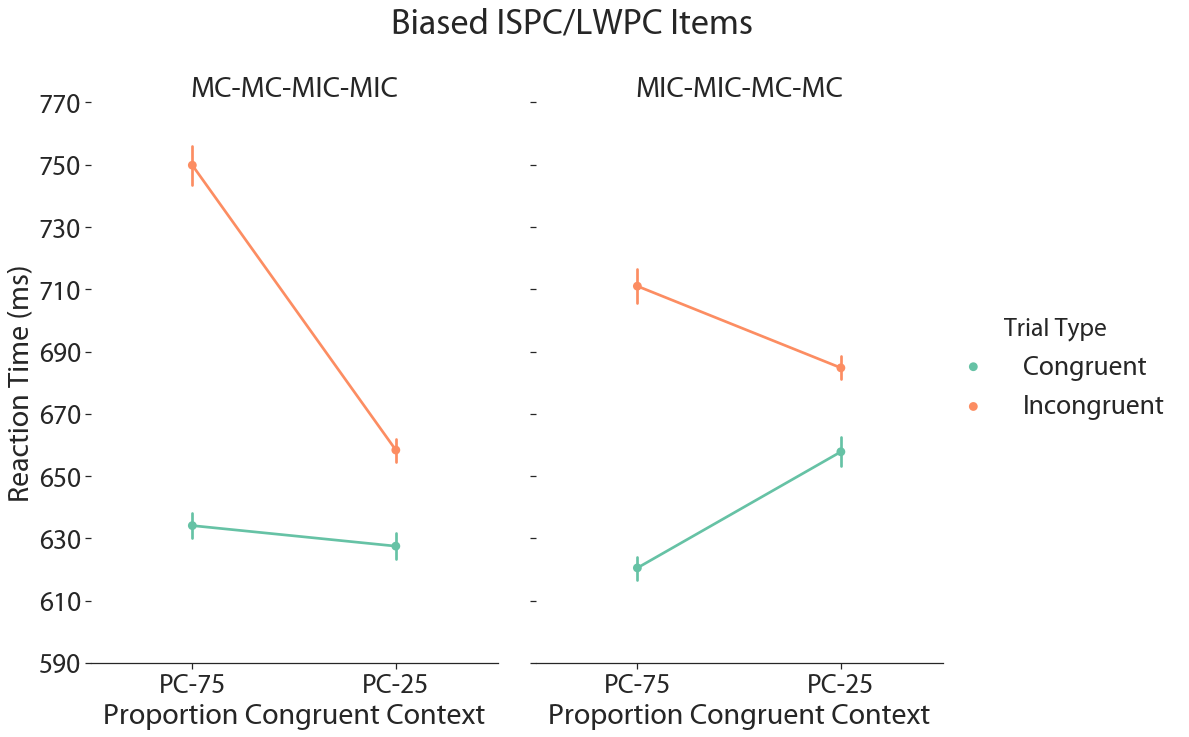

In [25]:
mygraph("BlockType","RT","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],RTmeans,"Proportion Congruent Context","Reaction Time (ms)","Biased ISPC/LWPC Items","Trial Type",590,770,"LWPC_RT_maintask.png",20)

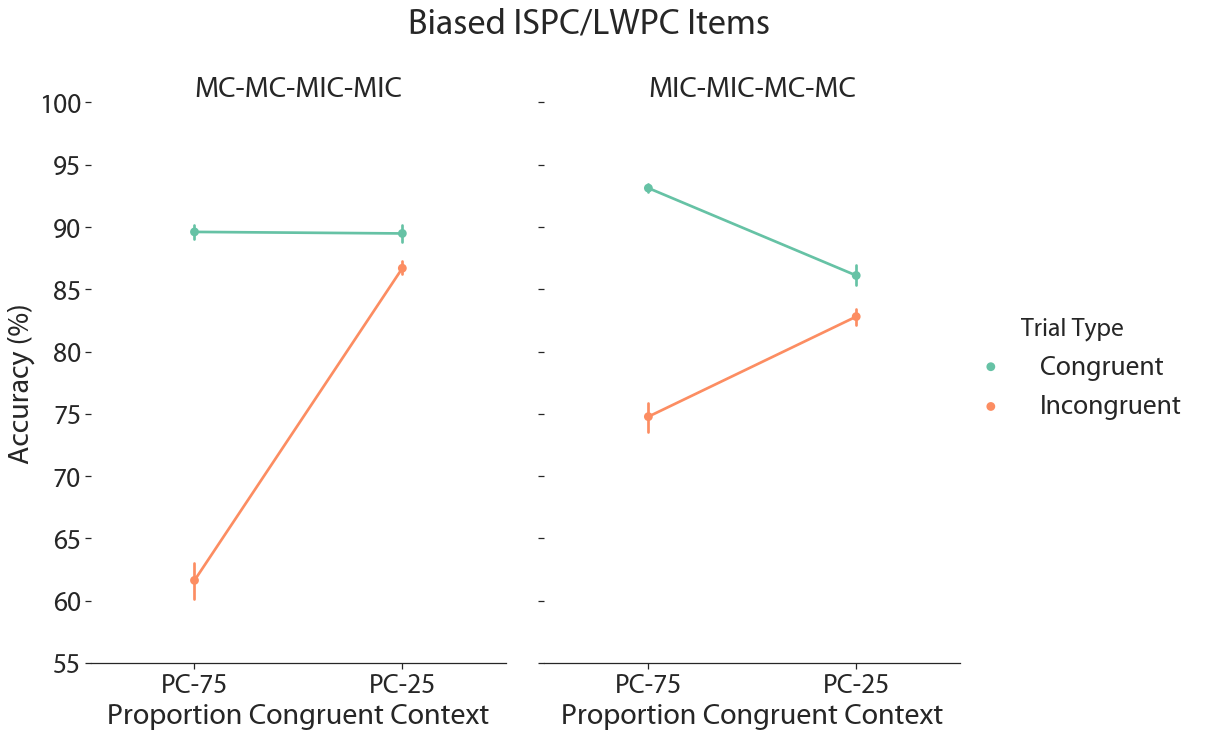

In [26]:
mygraph("BlockType","Accuracy","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],ACCmeans,"Proportion Congruent Context","Accuracy (%)","Biased ISPC/LWPC Items","Trial Type",55,100,"LWPC_ACC_maintask.png",5)

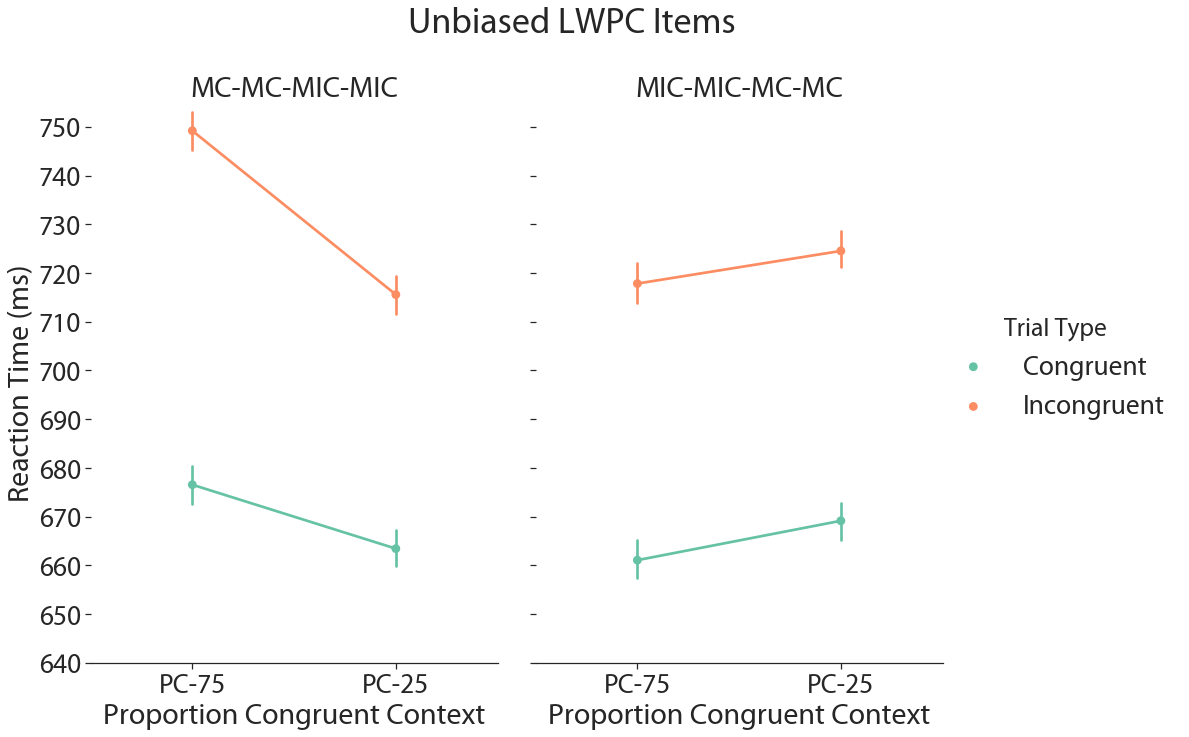

In [27]:
mygraph("BlockType","RT","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],RTmeans_PC50,"Proportion Congruent Context","Reaction Time (ms)","Unbiased LWPC Items","Trial Type",640,755,"LWPC_RT_pc50.png",10)

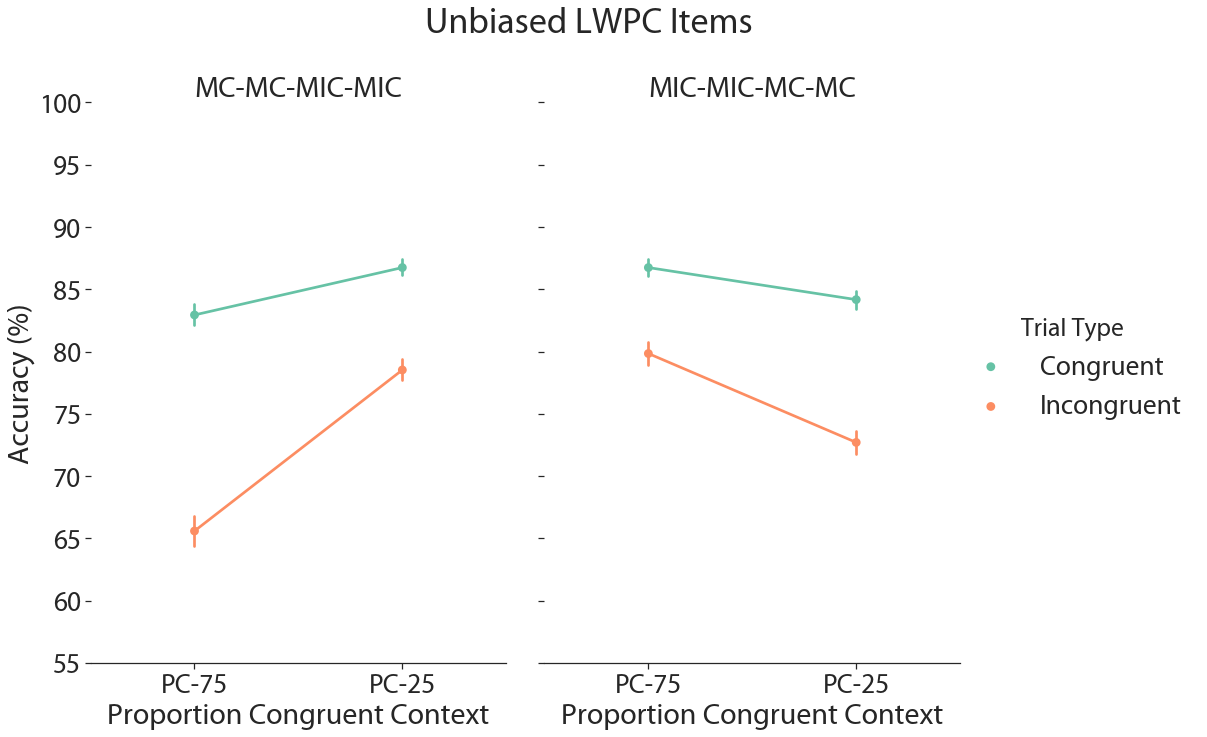

In [28]:
mygraph("BlockType","Accuracy","Congruency",["PC-75", "PC-25"],"BlockOrder",["MC-MC-MIC-MIC", "MIC-MIC-MC-MC"],ACCmeans_PC50,"Proportion Congruent Context","Accuracy (%)","Unbiased LWPC Items","Trial Type",55,100,"LWPC_ACC_pc50.png",5)

# Creating Variables

##### this is to calculate the interaction effects for later correlation graphs, with overall RT/acc in each condition serving as a correction. (also, re: JASP and simple main effeects, you can use the wide dfs created below for that analysis.)

Whenever possible, correlations for difference scores were corrected by dividing the difference score by the overall mean score on the behavioral measure (e.g., the RT interaction metric divided by overall RT for each participant) (see e.g., Hedge et al., 2018; Rouder & Haaf, 2019 for a discussion on the reliability of difference scores).

In [29]:
BO_MIC = np.unique(cdat.loc[cdat['BlockOrder']=='MICfirst'].subject)
BO_MC = np.unique(cdat.loc[cdat['BlockOrder']=='MCfirst'].subject)
allsubs = np.unique(cdat.subject)

In [30]:
All_RT = pd.DataFrame();
All_ACC = pd.DataFrame();

In [31]:
def create_wide_df(df,dfname,dv,Accuracy):
    lists = [[] for list in range(0,12)]
    
    for ID in allsubs:
        if ID in range(89) or ID in range(301,379):
            group = 'MTurk'
        else: group = 'SONA'
            
        if ID in range(203):
            fb = 'Feedback'
        else: fb = 'NoFeedback'
        
        if ID in BO_MIC:
            BO = 'IncongFirst'
        else:
            BO = 'CongFirst'
        
        sub = df[df.subject == ID]
        lists[0].append(ID)
        submain = sub[sub.Item != 'PC-50']
        LowC_trials = submain[submain.ContextCong == 'LowC'][dv].mean()
        LowIC_trials = submain[submain.ContextCong == 'LowIC'][dv].mean()
        HighC_trials = submain[submain.ContextCong == 'HighC'][dv].mean()
        HighIC_trials = submain[submain.ContextCong == 'HighIC'][dv].mean()
        subtransfer = sub[sub.Item == 'PC-50']
        LowC_trials_T = subtransfer[subtransfer.ContextCong == 'LowC'][dv].mean()
        LowIC_trials_T = subtransfer[subtransfer.ContextCong == 'LowIC'][dv].mean()
        HighC_trials_T = subtransfer[subtransfer.ContextCong == 'HighC'][dv].mean()
        HighIC_trials_T = subtransfer[subtransfer.ContextCong == 'HighIC'][dv].mean()
        if Accuracy == 1:
            lists[1].append(100 -(LowC_trials*100))
            lists[2].append(100 -(LowIC_trials*100))
            lists[3].append(100 -(HighC_trials*100))
            lists[4].append(100 -(HighIC_trials*100))
            lists[5].append(100 -(LowC_trials_T*100))
            lists[6].append(100 -(LowIC_trials_T*100))
            lists[7].append(100 -(HighC_trials_T*100))
            lists[8].append(100 -(HighIC_trials_T*100))
        else:
            lists[1].append(LowC_trials)
            lists[2].append(LowIC_trials)
            lists[3].append(HighC_trials)
            lists[4].append(HighIC_trials)
            lists[5].append(LowC_trials_T)
            lists[6].append(LowIC_trials_T)
            lists[7].append(HighC_trials_T)
            lists[8].append(HighIC_trials_T)

        lists[9].append(group)
        lists[10].append(fb)
        lists[11].append(BO)
        
    dfname['SubjectID'] = lists[0]
    dfname['LowC'] = lists[1]
    dfname['LowIC'] = lists[2]
    dfname['HighC'] = lists[3]
    dfname['HighIC'] = lists[4]
    dfname['LowC_T'] = lists[5]
    dfname['LowIC_T'] = lists[6]
    dfname['HighC_T'] = lists[7]
    dfname['HighIC_T'] = lists[8]
    dfname['population'] = lists[9]
    dfname['Feedback'] = lists[10]
    dfname['BlockOrder'] = lists[11]

In [32]:
create_wide_df(cdat,All_RT,'RT',0);

In [33]:
create_wide_df(adat,All_ACC,'Accuracy',1);

In [34]:
def calc_PCbycong_interaction(df, transfer, RTacc):
    if transfer == 0:
        InteractionEffect = (df.LowIC - df.LowC) - (df.HighIC - df.HighC);
    elif transfer == 1:
        InteractionEffect = (df.LowIC_T - df.LowC_T) - (df.HighIC_T - df.HighC_T);
    
    InteractionEffect = InteractionEffect.reset_index();
    
    if RTacc == 1:
        InteractionEffect.columns = ['index', 'RTs']
    elif RTacc == 0:
        InteractionEffect.columns = ['index', 'ACC']
    
    return InteractionEffect

In [35]:
SC_RT_FB = calc_PCbycong_interaction(All_RT, 0, 1)

In [36]:
SCT_RT_FB = calc_PCbycong_interaction(All_RT, 1, 1)

In [37]:
SC_ACC_FB = calc_PCbycong_interaction(All_ACC, 0, 0)

In [38]:
SCT_ACC_FB = calc_PCbycong_interaction(All_ACC, 1, 0)

The average biased and LWPC effects are...

In [39]:
SC_RT_FB.RTs.mean()
SC_ACC_FB.ACC.mean()
SCT_RT_FB.RTs.mean()
SCT_ACC_FB.ACC.mean()

74.22981419067884

20.123329488389444

10.941999057925345

2.2823383084577116

In [40]:
def means_overall_group(df, filternum, filter1, dv):
    if filternum == 0:
        X = df.groupby(['subject'])[dv].mean().reset_index();       
    elif filternum == 1:
        X = df.loc[df['Item'] == filter1].groupby(['subject'])[dv].mean().reset_index();
    elif filternum == 2:
        X = df.loc[df['Item'] != filter1].groupby(['subject'])[dv].mean().reset_index();
        
    X = X.drop('subject',1)
    
    return X

In [41]:
overallRT = means_overall_group(cdat, 0, 0, 'RT')
overallRT = overallRT.reset_index();

In [42]:
overallACC = means_overall_group(adat, 0, 0, 'Accuracy')
overallACC = overallACC.reset_index();
overallACC.Accuracy = overallACC.Accuracy*100

In [43]:
overallMainRT = means_overall_group(cdat, 2, 'PC-50', 'RT') #main refers to pc-90/10 here
overallMainRT = overallMainRT.reset_index();

In [44]:
overallMainACC = means_overall_group(adat, 2, 'PC-50', 'Accuracy') #main refers to pc-90/10 here
overallMainACC = overallMainACC.reset_index();
overallMainACC.Accuracy = overallMainACC.Accuracy*100

In [45]:
overallRT_T = means_overall_group(cdat, 1, 'PC-50', 'RT') #_T refers to pc-50 here
overallRT_T = overallRT_T.reset_index();

In [46]:
overallACC_T = means_overall_group(adat,  1, 'PC-50', 'Accuracy') #_T refers to pc-50 here
overallACC_T = overallACC_T.reset_index();
overallACC_T.Accuracy = overallACC_T.Accuracy*100

### Now that we've looked at our ANOVAs, let's calculate the means to report in the manuscript

Biased Items - RT

In [47]:
#main effect of congruency for RT
maineffectcongruency=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#main effect of PC for RT
maineffectPC=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#interaction of Pc x Cong for biased items
IntCong=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','ContextCong'])['RT'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['RT']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['RT']
round(Congdiff25.mean()), round(Congdiff75.mean()), round(SC_RT_FB.RTs.mean())

#PC x cong x BO
PCCongBO=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['RT'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(MC_BO75.mean() - MC_BO25.mean()), round(MIC_BO75.mean() - MIC_BO25.mean())

#congruency x block order
CongBO=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

#PC x block order
PCBO=cdat.loc[cdat['Item']!='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['RT'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(BO25.mean()), round(BO75.mean())

(Congruency
 Congruent      629.0
 Incongruent    676.0
 Name: RT, dtype: float64, 47.40145707881493)

(BlockType
 PC-25    668.0
 PC-75    636.0
 Name: RT, dtype: float64, -32.41047318788719)

(29, 103, 74)

(85, 64)

(32, 63)

(12, 53)

Biased Items - Accuracy

In [48]:
#main effect of congruency
maineffectcongruency=adat.loc[adat['Item']!='PC-50'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean*100, (grpmean[1] - grpmean[0])*100

#main effect of PC
maineffectPC=adat.loc[adat['Item']!='PC-50'].groupby(['subject','BlockType'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
grpmean*100, (grpmean[1] - grpmean[0])*100

#main effect of block order
maineffectBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','BlockOrder'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectBO, level=1)
grpmean*100, (grpmean[1] - grpmean[0])*100

#interaction of Pc x Cong for biased items
IntCong=adat.loc[adat['Item']!='PC-50'].groupby(['subject','ContextCong'])['Accuracy'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['Accuracy']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['Accuracy']
Congdiff25.mean()*100, Congdiff75.mean()*100, SC_ACC_FB.ACC.mean()*100

#PC x cong x BO
PCCongBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['Accuracy'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
(MC_BO75.mean() - MC_BO25.mean())*100, (MIC_BO75.mean() - MIC_BO25.mean())*100

#congruency x block order
CongBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
CongFirstBO.mean()*100, IncongFirstBO.mean()*100

#PC x block order
PCBO=adat.loc[adat['Item']!='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['Accuracy'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
BO25.mean()*100, BO75.mean()*100

(Congruency
 Congruent      90.997220
 Incongruent    83.042508
 Name: Accuracy, dtype: float64, -7.954711735440522)

(BlockType
 PC-25    85.059994
 PC-75    88.979734
 Name: Accuracy, dtype: float64, 3.9197395376060262)

(BlockOrder
 MCfirst     86.850673
 MICfirst    87.189055
 Name: Accuracy, dtype: float64, 0.3383816213051838)

(-3.0468267561489975, -23.170156244538447, 2012.3329488389445)

(-25.193121045824736, -15.053537930954109)

(-5.483611354989759, -10.42581211589114)

(0.25241439859525927, -8.091893473807431)

Unbiased Items - RT

In [49]:
#main effect of congruency for RT
maineffectcongruency=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','Congruency'])['RT'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#main effect of PC for RT
maineffectPC=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','BlockType'])['RT'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
round(grpmean), grpmean[1] - grpmean[0]

#interaction of Pc x Cong
IntCong=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','ContextCong'])['RT'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['RT']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['RT'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['RT']
round(Congdiff25.mean()), round(Congdiff75.mean()), round(SCT_RT_FB.RTs.mean())

#PC x cong x BO
PCCongBO=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['RT'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(MC_BO75.mean() - MC_BO25.mean()), round(MIC_BO75.mean() - MIC_BO25.mean())

#PC x block order
PCBO=cdat.loc[cdat['Item']=='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['RT'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(BO25.mean()), round(BO75.mean())

(Congruency
 Congruent      667.0
 Incongruent    725.0
 Name: RT, dtype: float64, 58.20787963859334)

(BlockType
 PC-25    691.0
 PC-75    697.0
 Name: RT, dtype: float64, 6.461207246875688)

(54, 65, 11)

(21, 1)

(-20, 7)

Unbiased Items - Accuracy

In [50]:
#main effect of congruency
maineffectcongruency=adat.loc[adat['Item']=='PC-50'].groupby(['subject','Congruency'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectcongruency, level=1)
grpmean*100, (grpmean[1] - grpmean[0])*100

#main effect of PC
maineffectPC=adat.loc[adat['Item']=='PC-50'].groupby(['subject','BlockType'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectPC, level=1)
grpmean*100, (grpmean[1] - grpmean[0])*100

#main effect of BO
maineffectBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','BlockOrder'])['Accuracy'].mean()
grpmean = pd.Series.mean(maineffectBO, level=1)
grpmean*100, (grpmean[1] - grpmean[0])*100

#interaction of Pc x Cong
IntCong=adat.loc[adat['Item']=='PC-50'].groupby(['subject','ContextCong'])['Accuracy'].mean().reset_index()
Congdiff25 = IntCong.loc[IntCong['ContextCong'] == 'HighIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'HighC'].reset_index()['Accuracy']
Congdiff75 = IntCong.loc[IntCong['ContextCong'] == 'LowIC'].reset_index()['Accuracy'] - IntCong.loc[IntCong['ContextCong'] == 'LowC'].reset_index()['Accuracy']
Congdiff25.mean()*100, Congdiff75.mean()*100, SCT_ACC_FB.ACC.mean()*100

#PC x cong x BO
PCCongBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','ContextCong','BlockOrder'])['Accuracy'].mean().reset_index()
MC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
MC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
MIC_BO25 = PCCongBO.loc[PCCongBO['ContextCong'] == 'HighIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'HighC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
MIC_BO75 = PCCongBO.loc[PCCongBO['ContextCong'] == 'LowIC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - PCCongBO.loc[PCCongBO['ContextCong'] == 'LowC'].loc[PCCongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
(MC_BO75.mean() - MC_BO25.mean())*100, (MIC_BO75.mean() - MIC_BO25.mean())*100

#PC x block order
PCBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','BlockType', 'BlockOrder'])['Accuracy'].mean().reset_index()
BO25 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
BO75 = PCBO.loc[PCBO['BlockType'] == 'PC-25'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - PCBO.loc[PCBO['BlockType'] == 'PC-75'].loc[PCBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
BO25.mean()*100, BO75.mean()*100

#congruency x block order
CongBO=adat.loc[adat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
CongFirstBO.mean()*100, (IncongFirstBO.mean())*100

#congruency x feedback group
CongFB=adat.loc[adat['Item']=='PC-50'].groupby(['subject','Congruency', 'Feedback'])['Accuracy'].mean().reset_index()
NoFBcong = CongFB.loc[CongFB['Congruency'] == 'Incongruent'].loc[CongFB['Feedback'] == 'nofb'].reset_index()['Accuracy'] - CongFB.loc[CongFB['Congruency'] == 'Congruent'].loc[CongFB['Feedback'] == 'nofb'].reset_index()['Accuracy']
FBcong = CongFB.loc[CongFB['Congruency'] == 'Incongruent'].loc[CongFB['Feedback'] == 'fb'].reset_index()['Accuracy'] - CongFB.loc[CongFB['Congruency'] == 'Congruent'].loc[CongFB['Feedback'] == 'fb'].reset_index()['Accuracy']
NoFBcong.mean()*100, (FBcong.mean())*100

(Congruency
 Congruent      85.146144
 Incongruent    74.160448
 Name: Accuracy, dtype: float64, -10.985696517412913)

(BlockType
 PC-25    80.531716
 PC-75    78.774876
 Name: Accuracy, dtype: float64, -1.756840796019854)

(BlockOrder
 MCfirst     78.445274
 MICfirst    80.861318
 Name: Accuracy, dtype: float64, 2.4160447761194193)

(-9.844527363184074, -12.126865671641786, 228.23383084577117)

(-9.129353233830836, 4.564676616915422)

(8.370646766169155, -4.856965174129357)

(-12.786069651741293, -9.18532338308458)

(-12.412499999999998, -9.5730198019802)

Analysis of Early / First Two Learning Phase blocks

In [51]:
#cong x block order - biased RT
CongBO=cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

#cong x block order - biased ACC
CongBO=adat.loc[adat['Time']=='Early'].loc[adat['Item']!='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
CongFirstBO.mean()*100, IncongFirstBO.mean()*100

#cong x block order - unbiased RT
CongBO=cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['RT'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['RT']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['RT']
round(CongFirstBO.mean()), round(IncongFirstBO.mean())

#main effect of FB
maineffectFB=cdat.loc[cdat['Time']=='Early'].loc[cdat['Item']=='PC-50'].groupby(['subject','Feedback'])['RT'].mean()
grpmean = pd.Series.mean(maineffectFB, level=1)
grpmean, (grpmean[1] - grpmean[0])

#cong x block order - unbiased ACC
CongBO=adat.loc[adat['Time']=='Early'].loc[adat['Item']=='PC-50'].groupby(['subject','Congruency', 'BlockOrder'])['Accuracy'].mean().reset_index()
CongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MCfirst'].reset_index()['Accuracy']
IncongFirstBO = CongBO.loc[CongBO['Congruency'] == 'Incongruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy'] - CongBO.loc[CongBO['Congruency'] == 'Congruent'].loc[CongBO['BlockOrder'] == 'MICfirst'].reset_index()['Accuracy']
CongFirstBO.mean()*100, IncongFirstBO.mean()*100

(116, 27)

(-27.98478334323697, -3.301991214885759)

(73, 55)

(Feedback
 fb      695.180626
 nofb    706.226069
 Name: RT, dtype: float64, 11.045443351445897)

(-17.350746268656707, -11.467661691542292)

### How reliable are the control-learning effects we observed?

In [52]:
import matplotlib.ticker as ticker

In [53]:
def my_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, corryvalue, xmin, xmax, ymin, ymax,stepsize):
    plot = sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=5, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plot.ax_marg_x.set_xlim(xmin, xmax)
    plot.ax_marg_y.set_ylim(ymin, ymax)
    plot.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(stepsize))
    plot.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(stepsize))
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y/corryvalue
        corrstat = stats.linregress(corrx,corry)
        return regstat, corrstat
    else:
        return regstat

In [54]:
def cong_bias(df, dv, ItemFilter, VersionFilter, RunFilter, bias, Accuracy):
    if bias == 1:
        sub_means = df.loc[df['Item']==ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter']==RunFilter].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif bias == 2:
        sub_means = df.loc[df['Item']!=ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter']==RunFilter].groupby(['subject','Congruency'])[dv].mean().reset_index()
    
    if Accuracy == 1: #error rates
        sub_means[dv] = 100 - (sub_means[dv]*100)
    elif Accuracy == 2: #percentage
        sub_means[dv] = sub_means[dv]*100
    
    Congdiff = sub_means.loc[sub_means['Congruency']=='Incongruent'].reset_index()[dv] - sub_means.loc[sub_means['Congruency']=='Congruent'].reset_index()[dv]
    return sub_means, Congdiff

In [55]:
RTv9r1bias, RTv9r1biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 1, 2, 0)
RTv9r2bias, RTv9r2biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 2, 2, 0)
RTv9r3bias, RTv9r3biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 3, 2, 0)
RTv9r4bias, RTv9r4biascong = cong_bias(cdat, 'RT', 'PC-50', 9, 4, 2, 0) 

RTv10r1bias, RTv10r1biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 1, 2, 0)
RTv10r2bias, RTv10r2biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 2, 2, 0)
RTv10r3bias, RTv10r3biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 3, 2, 0)
RTv10r4bias, RTv10r4biascong = cong_bias(cdat, 'RT', 'PC-50', 10, 4, 2, 0)

RTv9r1UB, RTv9r1UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 1, 1, 0) 
RTv9r2UB, RTv9r2UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 2, 1, 0)
RTv9r3UB, RTv9r3UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 3, 1, 0)
RTv9r4UB, RTv9r4UBcong = cong_bias(cdat, 'RT', 'PC-50', 9, 4, 1, 0)

RTv10r1UB, RTv10r1UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 1, 1, 0)
RTv10r2UB, RTv10r2UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 2, 1, 0)
RTv10r3UB, RTv10r3UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 3, 1, 0)
RTv10r4UB, RTv10r4UBcong = cong_bias(cdat, 'RT', 'PC-50', 10, 4, 1, 0)

OK, we're going to look at reliability within the 4 trial types of the task blocks...

First, we'll look to see how associated unbiased + biased items of the same trial type/condition within the PC contexts are.

In [56]:
mic_early_bias = RTv9r1bias.append(RTv10r3bias).sort_values(by=['subject']).reset_index()
mic_late_bias = RTv9r2bias.append(RTv10r4bias).sort_values(by=['subject']).reset_index()

mc_early_bias = RTv9r3bias.append(RTv10r1bias).sort_values(by=['subject']).reset_index()
mc_late_bias = RTv9r4bias.append(RTv10r2bias).sort_values(by=['subject']).reset_index()

mic_early_UB = RTv9r1UB.append(RTv10r3UB).sort_values(by=['subject']).reset_index()
mic_late_UB = RTv9r2UB.append(RTv10r4UB).sort_values(by=['subject']).reset_index()

mc_early_UB = RTv9r3UB.append(RTv10r1UB).sort_values(by=['subject']).reset_index()
mc_late_UB = RTv9r4UB.append(RTv10r2UB).sort_values(by=['subject']).reset_index()

In [57]:
xminRT4 = pd.concat([mic_early_bias.RT, mc_early_bias.RT, mic_early_UB.RT, mic_late_UB.RT], axis=0).min() - 5
xmaxRT4 = pd.concat([mic_early_bias.RT, mc_early_bias.RT, mic_early_UB.RT, mic_late_UB.RT], axis=0).max() + 5
yminRT4 = pd.concat([mic_late_bias.RT, mc_late_bias.RT, mc_early_UB.RT, mc_late_UB.RT], axis=0).min() - 5
ymaxRT4 = pd.concat([mic_late_bias.RT, mc_late_bias.RT, mc_early_UB.RT, mc_late_UB.RT], axis=0).max() + 5

In [58]:
mic_bias_RT = mic_early_bias.append(mic_late_bias).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)
mc_bias_RT = mc_early_bias.append(mc_late_bias).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)

mic_UB_RT = mic_early_UB.append(mic_late_UB).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)
mc_UB_RT = mc_early_UB.append(mc_late_UB).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)

LinregressResult(slope=0.5359452349769992, intercept=321.85580123230835, rvalue=0.6604369106701263, pvalue=1.018574517823622e-51, stderr=0.030467057251187948)

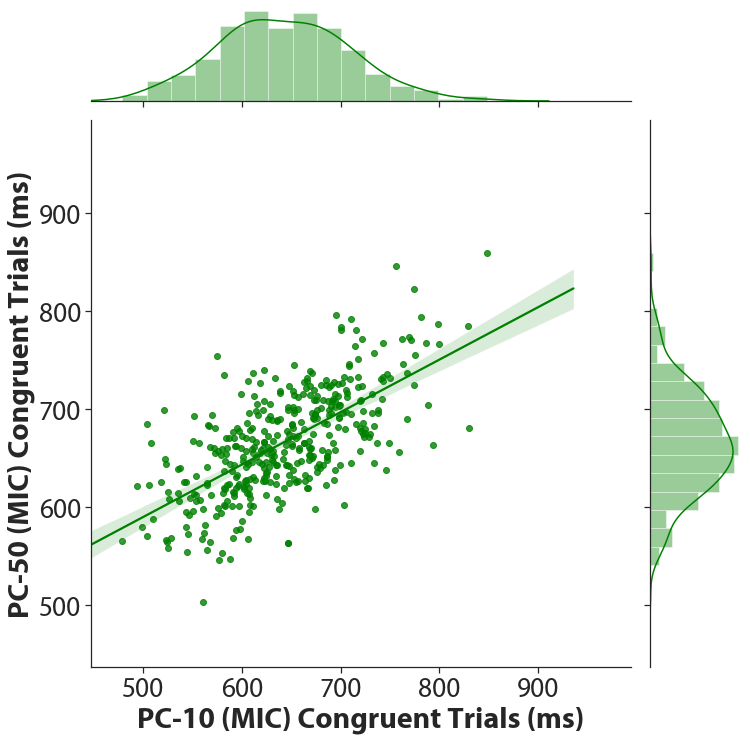

In [59]:
my_corr_graphs(mic_bias_RT.loc[mic_bias_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean(), mic_UB_RT.loc[mic_UB_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean(), 'PC-50 (MIC) Congruent Trials (ms)', 'PC-10 (MIC) Congruent Trials (ms)', "biasUB_mic_congruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.744413078241973, intercept=220.81429609967142, rvalue=0.7274573367276791, pvalue=2.0241391602316146e-67, stderr=0.03510729619944679)

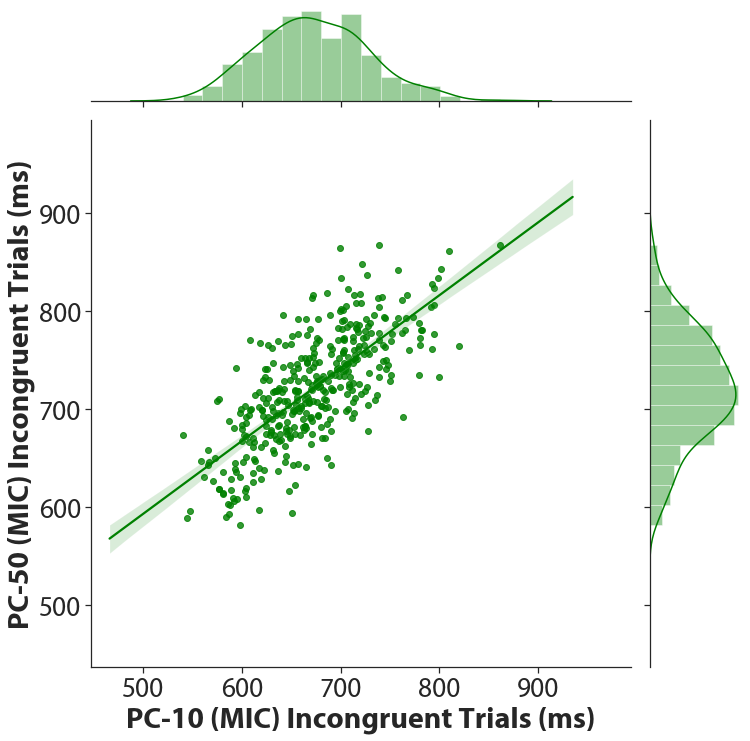

In [60]:
my_corr_graphs(mic_bias_RT.loc[mic_bias_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean(), mic_UB_RT.loc[mic_UB_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean(), 'PC-50 (MIC) Incongruent Trials (ms)', 'PC-10 (MIC) Incongruent Trials (ms)', "biasUB_mic_incongruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.7679257534325147, intercept=187.36657732274676, rvalue=0.7397804253508968, pvalue=7.89818311196567e-71, stderr=0.03492236141450465)

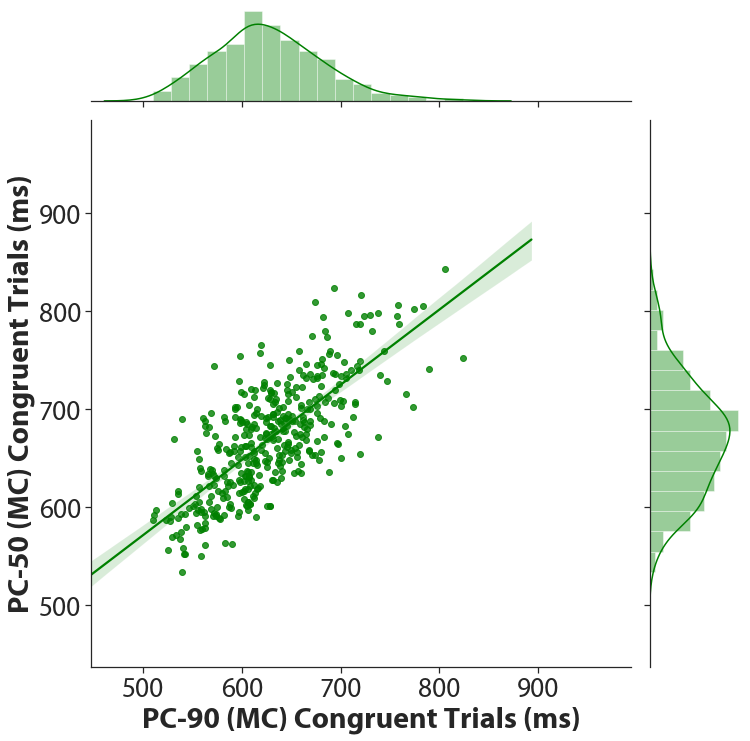

In [61]:
my_corr_graphs(mc_bias_RT.loc[mc_bias_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean(), mc_UB_RT.loc[mc_UB_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean(), 'PC-50 (MC) Congruent Trials (ms)', 'PC-90 (MC) Congruent Trials (ms)', "biasUB_mc_congruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.4768654638649606, intercept=386.59400160291614, rvalue=0.633642415600445, pvalue=1.6204517516123344e-46, stderr=0.029110705303071874)

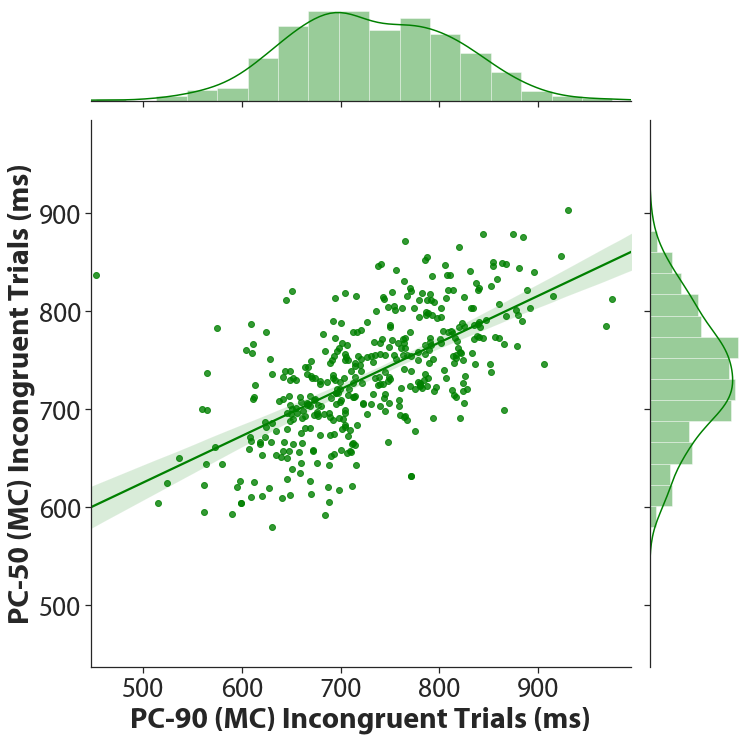

In [62]:
my_corr_graphs(mc_bias_RT.loc[mc_bias_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean(), mc_UB_RT.loc[mc_UB_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean(), 'PC-50 (MC) Incongruent Trials (ms)', 'PC-90 (MC) Incongruent Trials (ms)', "biasUB_mc_incongruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

Here I'm actually storing the correlation information that was listed with the graphs above so that I can compare them with the Fischer r-to-z transformation.

First up is the MIC context correlation - are associations between unbiased/biased items stronger for congruent vs. incongruent trials?

In [63]:
r_UBbias_micc, p_UBbias_micc = stats.pearsonr(mic_bias_RT.loc[mic_bias_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean(), mic_UB_RT.loc[mic_UB_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean())  
n_UBbias_micc = len(mic_bias_RT.loc[mic_bias_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean())

r_UBbias_micic, p_UBbias_micic = stats.pearsonr(mic_bias_RT.loc[mic_bias_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean(), mic_UB_RT.loc[mic_UB_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean())  
n_UBbias_micic = len(mic_bias_RT.loc[mic_bias_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean())

r_UBbias_micc, p_UBbias_micc, n_UBbias_micc-2
r_UBbias_micic, p_UBbias_micic, n_UBbias_micic-2

independent_corr(r_UBbias_micc, r_UBbias_micic, n_UBbias_micc, n_UBbias_micic, twotailed=True, conf_level=0.95, method='fisher')

(0.6604369106701268, 1.018574517823364e-51, 400)

(0.727457336727679, 2.0241391602315885e-67, 400)

(1.8321837618857426, 0.06692404728156953)

Next up is the MC context - are they stronger for cong vs. incong?

Because this has no difference scores, you'll note we do not have a "corrected" and "uncorrected" correlation to report.

In [64]:
r_UBbias_mcc, p_UBbias_mcc = stats.pearsonr(mc_bias_RT.loc[mc_bias_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean(), mc_UB_RT.loc[mc_UB_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean())  
n_UBbias_mcc = len(mc_bias_RT.loc[mc_bias_RT['Congruency']=='Congruent'].groupby(['subject'])['RT'].mean())

r_UBbias_mcic, p_UBbias_mcic = stats.pearsonr(mc_bias_RT.loc[mc_bias_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean(), mc_UB_RT.loc[mc_UB_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean())  
n_UBbias_mcic = len(mc_bias_RT.loc[mc_bias_RT['Congruency']=='Incongruent'].groupby(['subject'])['RT'].mean())

r_UBbias_mcc, p_UBbias_mcc, n_UBbias_mcc-2
r_UBbias_mcic, p_UBbias_mcic, n_UBbias_mcic-2

independent_corr(r_UBbias_mcc, r_UBbias_mcic, n_UBbias_mcc, n_UBbias_mcic, twotailed=True, conf_level=0.95, method='fisher')

(0.7397804253508967, 7.898183111966381e-71, 400)

(0.6336424156004449, 1.620451751612256e-46, 400)

(2.860418371222882, 0.004230824549617429)

So essentially we just found reliability within a block. What about reliability across blocks?

As in: "We ran correlations for behavioral measures across the “early/first” (e.g., block 1 for MC-MC-MIC-MIC and block 3 for MIC-MIC-MC-MC) and “late/second” (e.g., block 2 for MC-MC-MIC-MIC and block 4 for MIC-MIC-MC-MC) blocks of each PC context for each trial type (congruent/incongruent)."

LinregressResult(slope=0.49034368301464987, intercept=312.17820110641355, rvalue=0.5066419085845678, pvalue=1.3406733707517628e-27, stderr=0.041721088197840484)

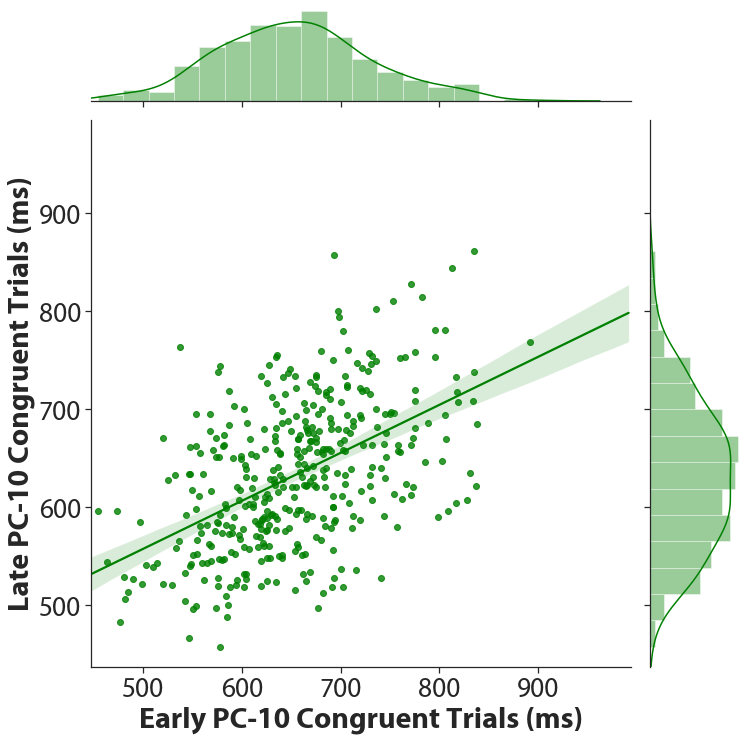

In [65]:
my_corr_graphs(mic_early_bias.loc[mic_early_bias['Congruency']=='Congruent'].reset_index()['RT'], mic_late_bias.loc[mic_late_bias['Congruency']=='Congruent'].reset_index()['RT'], 'Late PC-10 Congruent Trials (ms)', 'Early PC-10 Congruent Trials (ms)', "all_bias_mic_congruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.7660398971262021, intercept=132.80453688382397, rvalue=0.7911678222502015, pvalue=1.942969659160749e-87, stderr=0.029608719521317904)

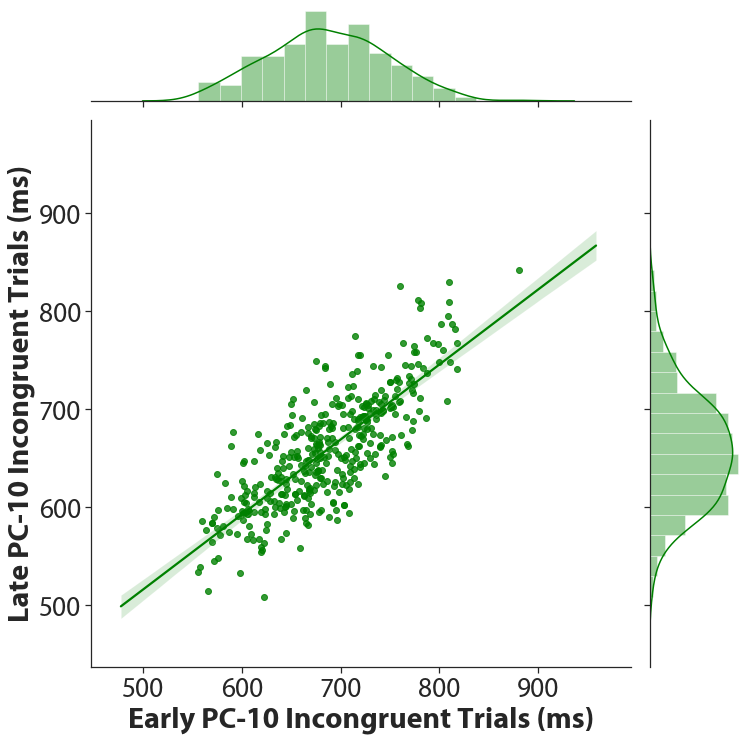

In [66]:
my_corr_graphs(mic_early_bias.loc[mic_early_bias['Congruency']=='Incongruent'].reset_index()['RT'], mic_late_bias.loc[mic_late_bias['Congruency']=='Incongruent'].reset_index()['RT'], 'Late PC-10 Incongruent Trials (ms)', 'Early PC-10 Incongruent Trials (ms)', "all_bias_mic_incongruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.7831590254576548, intercept=123.52528151261697, rvalue=0.8391060573968533, pvalue=8.04753141414814e-108, stderr=0.02538495160457227)

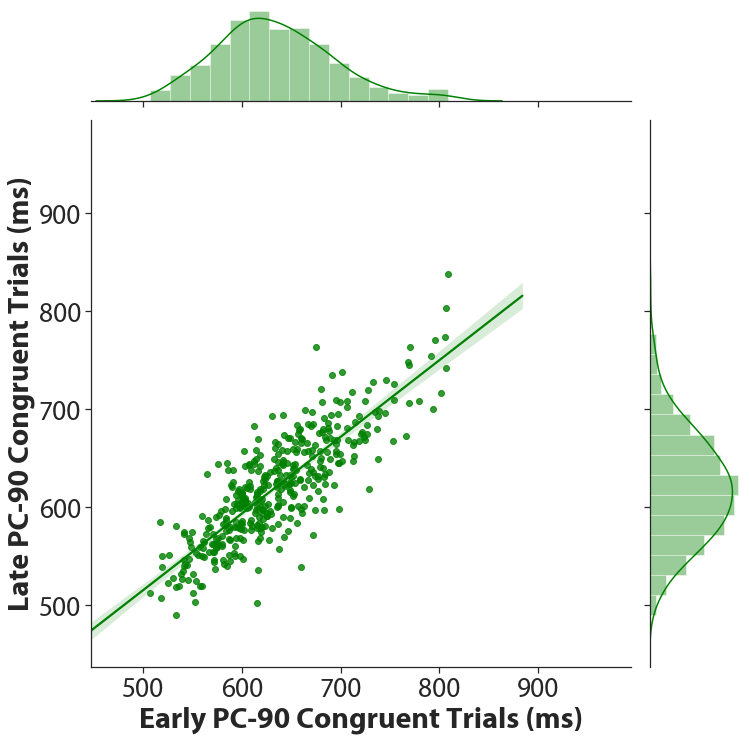

In [67]:
my_corr_graphs(mc_early_bias.loc[mc_early_bias['Congruency']=='Congruent'].reset_index()['RT'], mc_late_bias.loc[mc_late_bias['Congruency']=='Congruent'].reset_index()['RT'], 'Late PC-90 Congruent Trials (ms)', 'Early PC-90 Congruent Trials (ms)', "all_bias_mc_congruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.32942168859084375, intercept=477.5155907108492, rvalue=0.3353186647540603, pvalue=5.74862968672423e-12, stderr=0.04639296468216339)

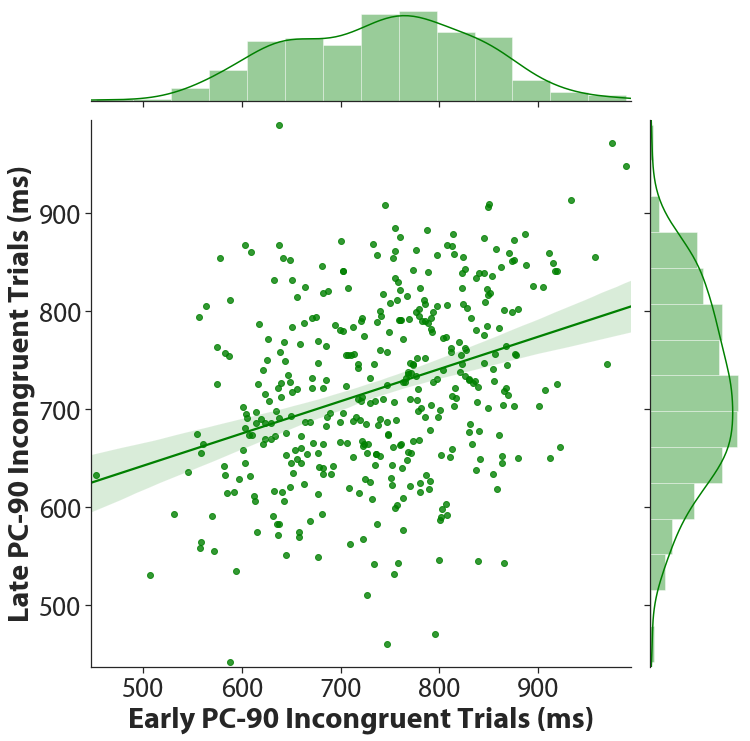

In [68]:
my_corr_graphs(mc_early_bias.loc[mc_early_bias['Congruency']=='Incongruent'].reset_index()['RT'], mc_late_bias.loc[mc_late_bias['Congruency']=='Incongruent'].reset_index()['RT'], 'Late PC-90 Incongruent Trials (ms)', 'Early PC-90 Incongruent Trials (ms)', "all_bias_mc_incongruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.6604490984663373, intercept=211.09431054634558, rvalue=0.6988549931852518, pvalue=3.4795466734573686e-60, stderr=0.03379778760419107)

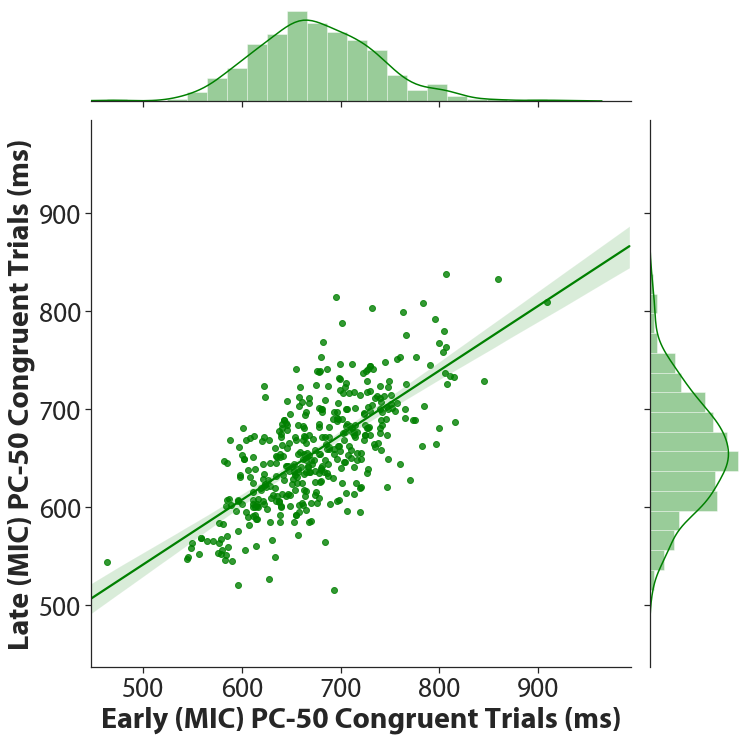

In [69]:
my_corr_graphs(mic_early_UB.loc[mic_early_UB['Congruency']=='Congruent'].reset_index()['RT'], mic_late_UB.loc[mic_late_UB['Congruency']=='Congruent'].reset_index()['RT'], 'Late (MIC) PC-50 Congruent Trials (ms)', 'Early (MIC) PC-50 Congruent Trials (ms)', "all_UB_mic_congruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

In [70]:
len(mic_early_UB.loc[mic_early_UB['Congruency']=='Incongruent'].reset_index()['RT'])
len(mic_late_UB.loc[mic_late_UB['Congruency']=='Incongruent'].reset_index()['RT'])

#pd.set_option('display.max_rows', 403)
#where is the person without a mic_early_UB RT trial? subject 36
mic_early_UB_IC = mic_early_UB.loc[mic_early_UB['subject']!=36].loc[mic_early_UB['Congruency']=='Incongruent'].reset_index()
mic_late_UB_IC = mic_late_UB.loc[mic_late_UB['subject']!=36].loc[mic_late_UB['Congruency']=='Incongruent'].reset_index()

401

402

LinregressResult(slope=0.6269387220943072, intercept=247.59639171134745, rvalue=0.6701228429821535, pvalue=1.3282805467641324e-53, stderr=0.03476438522734871)

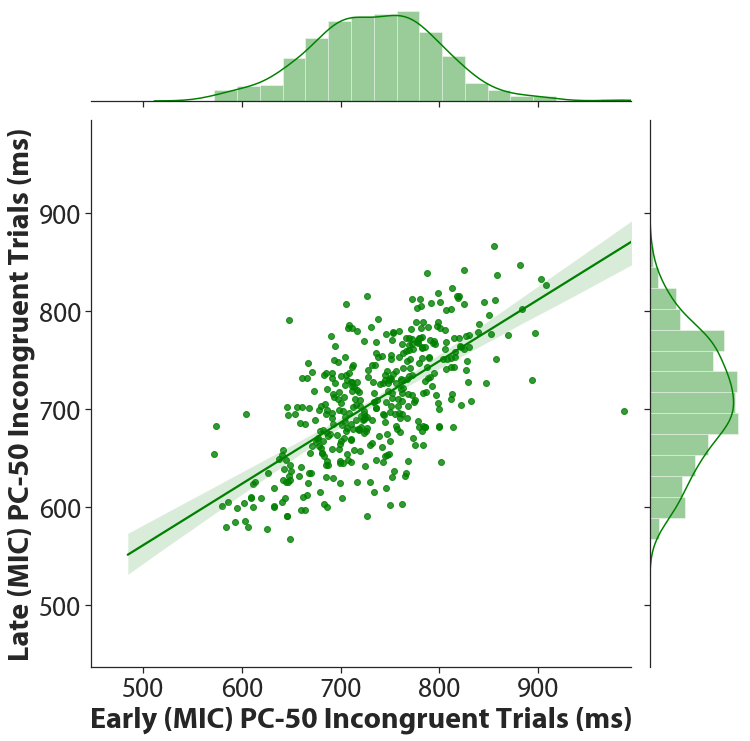

In [71]:
my_corr_graphs(mic_early_UB_IC['RT'], mic_late_UB_IC['RT'], 'Late (MIC) PC-50 Incongruent Trials (ms)', 'Early (MIC) PC-50 Incongruent Trials (ms)', "all_UB_mic_incongruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

LinregressResult(slope=0.7164795943009861, intercept=177.20553040113668, rvalue=0.7202429965919938, pvalue=1.6455694071657342e-65, stderr=0.0345048520210111)

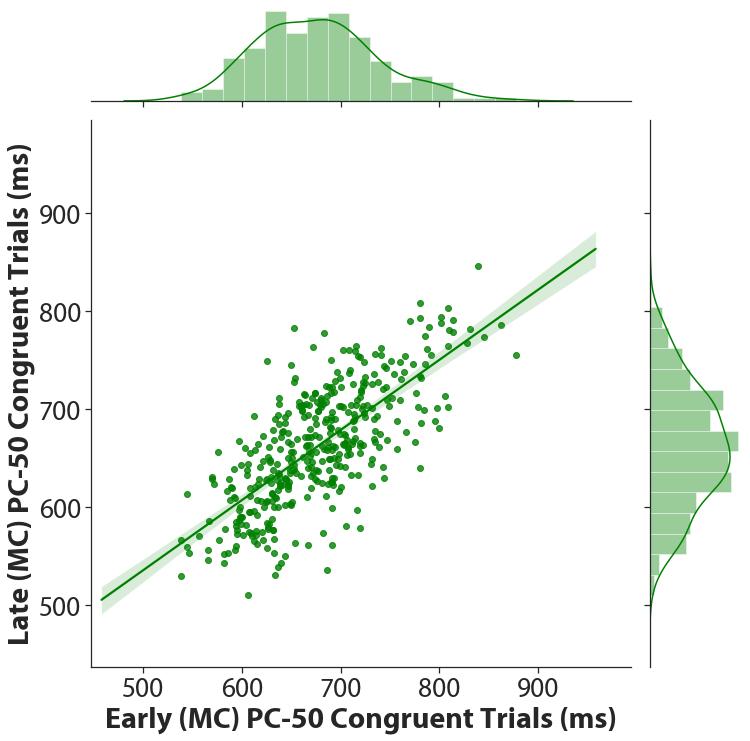

In [72]:
my_corr_graphs(mc_early_UB.loc[mc_early_UB['Congruency']=='Congruent'].reset_index()['RT'], mc_late_UB.loc[mc_late_UB['Congruency']=='Congruent'].reset_index()['RT'], 'Late (MC) PC-50 Congruent Trials (ms)', 'Early (MC) PC-50 Congruent Trials (ms)', "all_UB_mc_congruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

In [73]:
len(mc_early_UB.loc[mc_early_UB['Congruency']=='Incongruent'].reset_index()['RT'])
len(mc_late_UB.loc[mc_late_UB['Congruency']=='Incongruent'].reset_index()['RT'])

#two missing from early UB Incong MC context, subject 105, 331
#pd.set_option('display.max_rows', 403)
mc_early_UB_IC = mc_early_UB.loc[mc_early_UB['subject']!=105].loc[mc_early_UB['subject']!=331].loc[mc_early_UB['Congruency']=='Incongruent'].reset_index()
mc_late_UB_IC = mc_late_UB.loc[mc_late_UB['subject']!=105].loc[mc_late_UB['subject']!=331].loc[mc_late_UB['Congruency']=='Incongruent'].reset_index()

400

402

LinregressResult(slope=0.6076580444909728, intercept=274.01145896508547, rvalue=0.6676099460845134, pvalue=6.03420096707308e-53, stderr=0.03396770192432123)

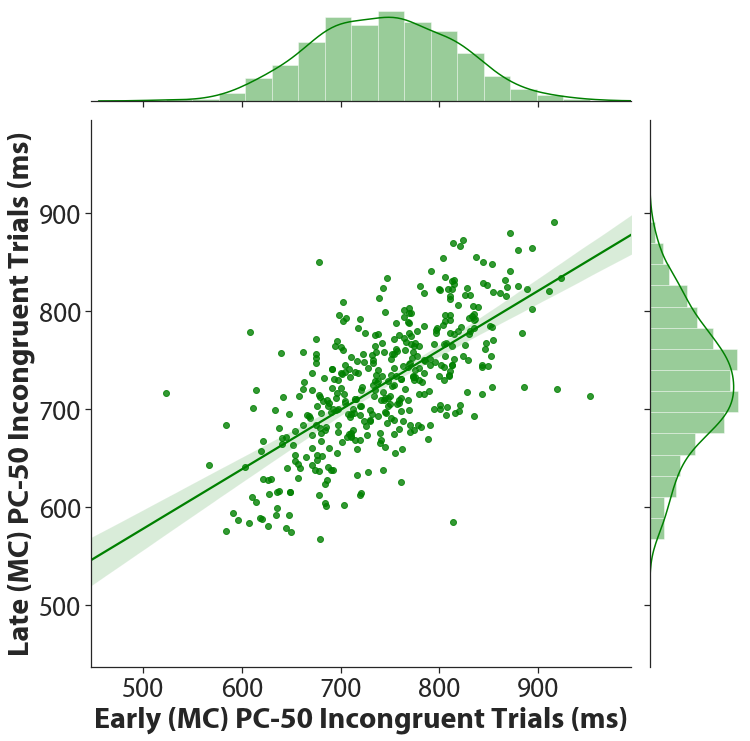

In [74]:
my_corr_graphs(mc_early_UB_IC['RT'], mc_late_UB_IC['RT'], 'Late (MC) PC-50 Incongruent Trials (ms)', 'Early (MC) PC-50 Incongruent Trials (ms)', "all_UB_mc_incongruent_trials.png", 0, overallRT.RT, overallRT.RT,xminRT4,xmaxRT4,yminRT4,ymaxRT4,100)

OK, now let's look at congruency effects - which means we'll need to remove some participants from the analysis, and gather the overall RT/accuracy scores to provide a "corrected" correlation as well.

In [75]:
np.where(pd.isnull(RTv9r1biascong))
np.where(pd.isnull(RTv9r2biascong))
np.where(pd.isnull(RTv9r3biascong)) #nulls at 200
np.where(pd.isnull(RTv9r4biascong)) #nulls at 200
np.where(pd.isnull(RTv10r1biascong)) #nulls at 200
np.where(pd.isnull(RTv10r2biascong)) #nulls at 200
np.where(pd.isnull(RTv10r3biascong))
np.where(pd.isnull(RTv10r4biascong))
np.where(pd.isnull(RTv9r1UBcong)) #nulls at 200
np.where(pd.isnull(RTv9r2UBcong))
np.where(pd.isnull(RTv9r3UBcong))
np.where(pd.isnull(RTv9r4UBcong))
np.where(pd.isnull(RTv10r1UBcong)) ##nulls at indices 199, 200
np.where(pd.isnull(RTv10r2UBcong))
np.where(pd.isnull(RTv10r3UBcong))
np.where(pd.isnull(RTv10r4UBcong))

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([200], dtype=int64),)

(array([200], dtype=int64),)

(array([200], dtype=int64),)

(array([200], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([200], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([199, 200], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

In [76]:
ovRTv9biasr1 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biasr2 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biasr3 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biasr4 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10biasr1 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biasr2 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biasr3 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biasr4 = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

ovRTv9UBr1 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBr2 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBr3 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBr4 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10UBr1 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==1].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBr2 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==2].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBr3 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBr4 = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter']==4].groupby(['subject'])['RT'].mean().reset_index()

In [77]:
RTv9r3biascong = RTv9r3biascong.reset_index()
RTv9r3biascong = RTv9r3biascong.loc[RTv9r3biascong['index']!=200].reset_index()
RTv9r3biascong = RTv9r3biascong.drop(columns=['index', 'level_0'])

RTv9r4biascong = RTv9r4biascong.reset_index()
RTv9r4biascong = RTv9r4biascong.loc[RTv9r4biascong['index']!=200].reset_index()
RTv9r4biascong = RTv9r4biascong.drop(columns=['index', 'level_0'])

RTv10r1biascong = RTv10r1biascong.reset_index()
RTv10r1biascong = RTv10r1biascong.loc[RTv10r1biascong['index']!=200].reset_index()
RTv10r1biascong = RTv10r1biascong.drop(columns=['index', 'level_0'])

RTv10r2biascong = RTv10r2biascong.reset_index()
RTv10r2biascong = RTv10r2biascong.loc[RTv10r2biascong['index']!=200].reset_index()
RTv10r2biascong = RTv10r2biascong.drop(columns=['index', 'level_0'])

RTv9r1UBcong = RTv9r1UBcong.reset_index()
RTv9r1UBcong = RTv9r1UBcong.loc[RTv9r1UBcong['index']!=200].reset_index()
RTv9r1UBcong = RTv9r1UBcong.drop(columns=['index', 'level_0'])

RTv10r1UBcong = RTv10r1UBcong.reset_index()
RTv10r1UBcong = RTv10r1UBcong.loc[RTv10r1UBcong['index']!=199].loc[RTv10r1UBcong['index']!=200].reset_index()
RTv10r1UBcong = RTv10r1UBcong.drop(columns=['index', 'level_0'])

In [78]:
ovRTv9biasr3 = ovRTv9biasr3.reset_index()
ovRTv9biasr3 = ovRTv9biasr3.loc[ovRTv9biasr3['index']!=200].reset_index()
ovRTv9biasr3 = ovRTv9biasr3.drop(columns=['index', 'level_0'])

ovRTv9biasr4 = ovRTv9biasr4.reset_index()
ovRTv9biasr4 = ovRTv9biasr4.loc[ovRTv9biasr4['index']!=200].reset_index()
ovRTv9biasr4 = ovRTv9biasr4.drop(columns=['index', 'level_0'])

ovRTv10biasr1 = ovRTv10biasr1.reset_index()
ovRTv10biasr1 = ovRTv10biasr1.loc[ovRTv10biasr1['index']!=200].reset_index()
ovRTv10biasr1 = ovRTv10biasr1.drop(columns=['index', 'level_0'])

ovRTv10biasr2 = ovRTv10biasr2.reset_index()
ovRTv10biasr2 = ovRTv10biasr2.loc[ovRTv10biasr2['index']!=200].reset_index()
ovRTv10biasr2 = ovRTv10biasr2.drop(columns=['index', 'level_0'])

ovRTv9UBr1 = ovRTv9UBr1.reset_index()
ovRTv9UBr1 = ovRTv9UBr1.loc[ovRTv9UBr1['index']!=200].reset_index()
ovRTv9UBr1 = ovRTv9UBr1.drop(columns=['index', 'level_0'])

ovRTv10UBr1 = ovRTv10UBr1.reset_index()
ovRTv10UBr1 = ovRTv10UBr1.loc[ovRTv10UBr1['index']!=199].loc[ovRTv10UBr1['index']!=200].reset_index()
ovRTv10UBr1 = ovRTv10UBr1.drop(columns=['index', 'level_0'])

In [79]:
#when comparing miccong_early_UB vs. miccong_late_UB, one has N = 402 and the other N = 401 because of filter above
#need to remove the other one in the last - early is v9 r1 + v10 r3 while late is v9 r2 + v10 r4
#we removed 1 from v9r1, so also need to remove that person from v9 r2

RTv9r2UBcong = RTv9r2UBcong.reset_index()
RTv9r2UBcong = RTv9r2UBcong.loc[RTv9r2UBcong['index']!=200].reset_index()
RTv9r2UBcong = RTv9r2UBcong.drop(columns=['index', 'level_0'])

ovRTv9UBr2 = ovRTv9UBr2.reset_index()
ovRTv9UBr2 = ovRTv9UBr2.loc[ovRTv9UBr2['index']!=200].reset_index()
ovRTv9UBr2 = ovRTv9UBr2.drop(columns=['index', 'level_0'])

#similarly when comparing mccong_early_UB vs mccong_late_UB
#early is v9 r3 + v10 r1 while late is v9 r4 + v10 r2
#we removed 2 people from v10 r1 so we need to remove them from v10 r2 as well

ovRTv10UBr2 = ovRTv10UBr2.reset_index()
ovRTv10UBr2 = ovRTv10UBr2.loc[ovRTv10UBr2['index']!=199].loc[ovRTv10UBr2['index']!=200].reset_index()
ovRTv10UBr2 = ovRTv10UBr2.drop(columns=['index', 'level_0'])

RTv10r2UBcong = RTv10r2UBcong.reset_index()
RTv10r2UBcong = RTv10r2UBcong.loc[RTv10r2UBcong['index']!=199].loc[RTv10r2UBcong['index']!=200].reset_index()
RTv10r2UBcong = RTv10r2UBcong.drop(columns=['index', 'level_0'])

What if we combine across all participants?

I.e., combine run 1 of version 9 with run 3 of version 10 + combine run 2 of version 9 with run 4 of version 10 -- early vs. late of MIC congruency effect

Combine run 3 of version 9 with run 1 of version 10 + combine run 4 of version 9 with run 2 of version 10 -- early vs. late of MC congruency effect

Do this for both biased and unbiased items & run 4 additional correlations that look at the effect *across all participants*

We thus tested whether our measures of control-learning were reliable, given general concerns about the reliability of cognitive control tasks (Whitehead et al., 2019). For greater power, we collapsed across block orders. We then ran correlations between congruency effects across the mostly congruent and incongruent contexts for unbiased items.

In [80]:
miccong_early_bias = RTv9r1biascong.append(RTv10r3biascong).reset_index()
miccong_late_bias = RTv9r2biascong.append(RTv10r4biascong).reset_index()

mccong_early_bias = RTv9r3biascong.append(RTv10r1biascong).reset_index()
mccong_late_bias = RTv9r4biascong.append(RTv10r2biascong).reset_index()

miccong_early_UB = RTv9r1UBcong.RT.append(RTv10r3UBcong).reset_index()
miccong_late_UB = RTv9r2UBcong.RT.append(RTv10r4UBcong).reset_index()

mccong_early_UB = RTv9r3UBcong.append(RTv10r1UBcong.RT).reset_index()
mccong_late_UB = RTv9r4UBcong.append(RTv10r2UBcong.RT).reset_index()

ov_mic_early_bias = ovRTv9biasr1.append(ovRTv10biasr3).reset_index()
ov_mic_late_bias = ovRTv9biasr2.append(ovRTv10biasr4).reset_index()

ov_mc_early_bias = ovRTv9biasr3.append(ovRTv10biasr1).reset_index()
ov_mc_late_bias = ovRTv9biasr4.append(ovRTv10biasr2).reset_index()

ov_mic_early_UB = ovRTv9UBr1.append(ovRTv10UBr3).reset_index()
ov_mic_late_UB = ovRTv9UBr2.append(ovRTv10UBr4).reset_index()

ov_mc_early_UB = ovRTv9UBr3.append(ovRTv10UBr1).reset_index()
ov_mc_late_UB = ovRTv9UBr4.append(ovRTv10UBr2).reset_index()

In [81]:
xminbiasRT = pd.concat([miccong_early_bias.RT, mccong_early_bias.RT], axis=0).min() - 5
xmaxbiasRT = pd.concat([miccong_early_bias.RT, mccong_early_bias.RT], axis=0).max() + 5
yminbiasRT = pd.concat([miccong_late_bias.RT, mccong_late_bias.RT], axis=0).min() - 5
ymaxbiasRT = pd.concat([miccong_late_bias.RT, mccong_late_bias.RT], axis=0).max() + 5

In [82]:
xminbiasRT, xmaxbiasRT, yminbiasRT, ymaxbiasRT

(-157.0, 388.98039215686276, -236.3525641025641, 386.4090909090909)

(LinregressResult(slope=0.16981552786302515, intercept=20.511076153996036, rvalue=0.17661112304949447, pvalue=0.0003736564979028145, stderr=0.047320390989107876),
 LinregressResult(slope=0.17937303614046654, intercept=0.031193432067417818, rvalue=0.17978454865260352, pvalue=0.0002911973090438285, stderr=0.049072719314322014))

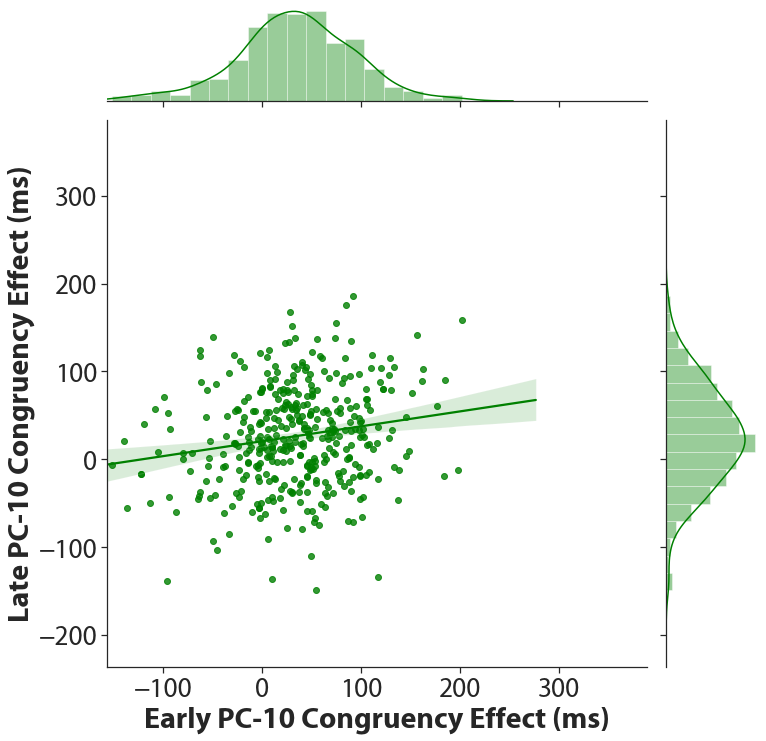

In [83]:
my_corr_graphs(miccong_early_bias.RT, miccong_late_bias.RT, 'Late PC-10 Congruency Effect (ms)', 'Early PC-10 Congruency Effect (ms)', "all_bias_mic.png", 1, ov_mic_early_bias.RT, ov_mic_late_bias.RT,xminbiasRT,xmaxbiasRT,yminbiasRT,ymaxbiasRT,100)

In [84]:
r_bias_mic, p_bias_mic = stats.pearsonr(miccong_early_bias.RT, miccong_late_bias.RT)  
n_bias_mic = len(miccong_early_bias.RT)
r2_bias_mic, p2_bias_mic = stats.pearsonr((miccong_early_bias.RT/ov_mic_early_bias.RT), (miccong_late_bias.RT/ov_mic_late_bias.RT))
n2_bias_mic = len(miccong_early_bias.RT)

r_bias_mic, p_bias_mic, n_bias_mic-2, r2_bias_mic, p2_bias_mic, n2_bias_mic-2

(0.17661112304949445,
 0.000373656497902786,
 400,
 0.1797845486526035,
 0.0002911973090438109,
 400)

The above code is here mostly because I'm going to do a Fischer's r-to-z transformation below to compare the size of the correlations between these graphs, and I need to be able to access that correlation.

(LinregressResult(slope=0.443653491407743, intercept=53.92943354787596, rvalue=0.40919867473711635, pvalue=1.4024073958174132e-17, stderr=0.04958781731260604),
 LinregressResult(slope=0.4788353309442563, intercept=0.08512960133771731, rvalue=0.4288648069859945, pvalue=2.5060878535122746e-19, stderr=0.05055792869593079))

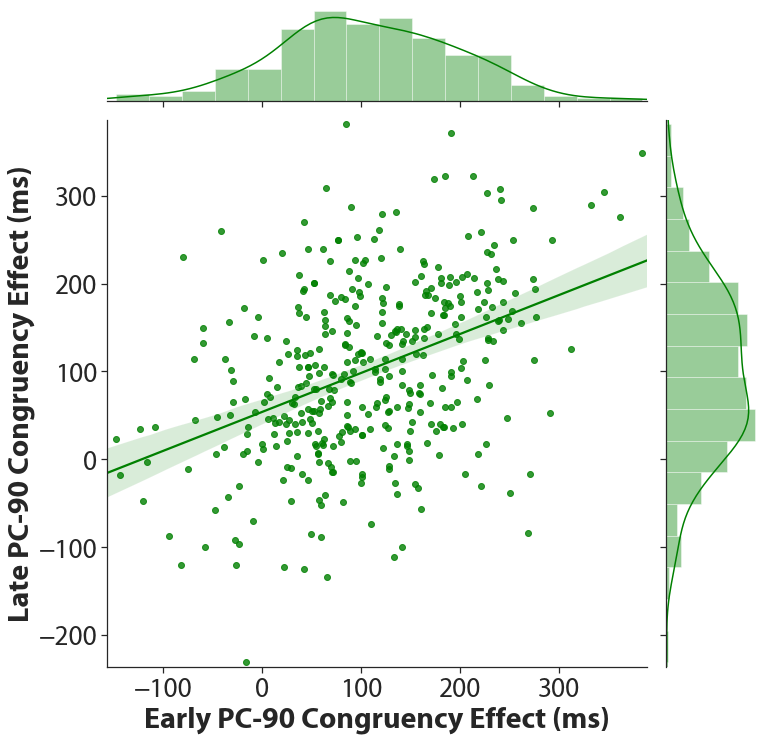

In [85]:
my_corr_graphs(mccong_early_bias.RT, mccong_late_bias.RT, 'Late PC-90 Congruency Effect (ms)', 'Early PC-90 Congruency Effect (ms)', "all_bias_mc.png", 1, ov_mc_early_bias.RT, ov_mc_late_bias.RT,xminbiasRT,xmaxbiasRT,yminbiasRT,ymaxbiasRT,100)

Now we're doing a Fischer's r-to-z transformation so that we can compare whether there's greater reliability for PC-90 or PC-10 biased items. And we'll do it for both the uncorrected/raw and corrected correlations.

In [86]:
r_bias_mc, p_bias_mc = stats.pearsonr(mccong_early_bias.RT, mccong_late_bias.RT)  
n_bias_mc = len(mccong_early_bias.RT)
r2_bias_mc, p2_bias_mc = stats.pearsonr((mccong_early_bias.RT/ov_mc_early_bias.RT), (mccong_late_bias.RT/ov_mc_late_bias.RT))
n2_bias_mc = len(mccong_early_bias.RT)

r_bias_mc, p_bias_mc, n_bias_mc-2, r2_bias_mc, p2_bias_mc, n2_bias_mc-2

independent_corr(r_bias_mic, r_bias_mc, n_bias_mic, n_bias_mc, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_bias_mic, r2_bias_mc, n2_bias_mic, n2_bias_mc, twotailed=True, conf_level=0.95, method='fisher')

(0.4091986747371164,
 1.4024073958178326e-17,
 398,
 0.4288648069859946,
 2.5060878535130237e-19,
 398)

(3.6136523019852533, 0.0003019138745152805)

(3.903953195136248, 9.463409010801449e-05)

In [87]:
xminUBRT = pd.concat([miccong_early_UB.RT, mccong_early_UB.RT], axis=0).min() - 5
xmaxUBRT = pd.concat([miccong_early_UB.RT, mccong_early_UB.RT], axis=0).max() + 5
yminUBRT = pd.concat([miccong_late_UB.RT, mccong_late_UB.RT], axis=0).min() - 5
ymaxUBRT = pd.concat([miccong_late_UB.RT, mccong_late_UB.RT], axis=0).max() + 5

In [88]:
xminUBRT, xmaxUBRT, yminUBRT, ymaxUBRT

(-174.68269230769226, 374.35, -91.85714285714289, 245.3222222222222)

(LinregressResult(slope=0.13804401723106302, intercept=42.66140809762622, rvalue=0.2040077667059983, pvalue=3.8573005230023715e-05, stderr=0.033162976191681036),
 LinregressResult(slope=0.15027006831987583, intercept=0.06163569075040748, rvalue=0.2204243193736432, pvalue=8.384292349787365e-06, stderr=0.03328979306069029))

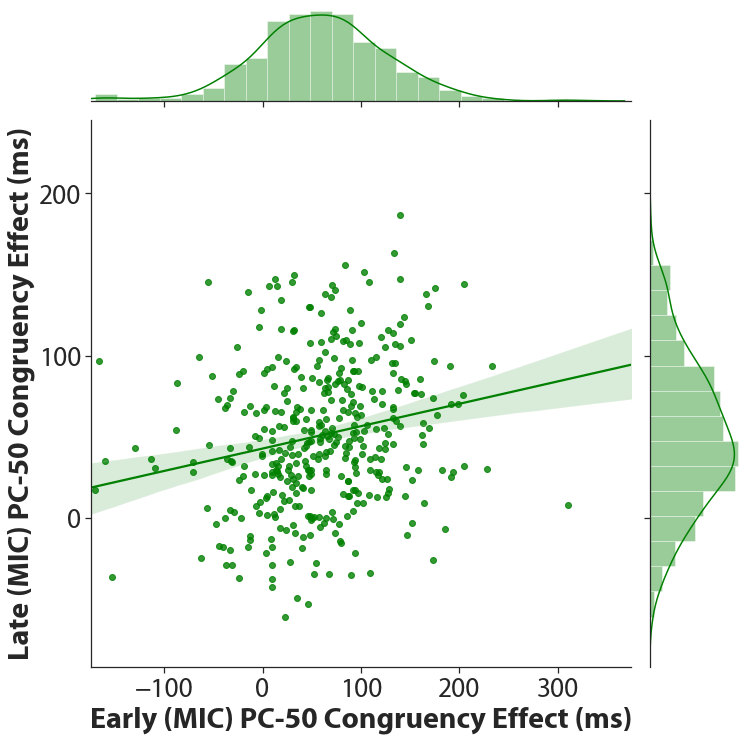

In [89]:
my_corr_graphs(miccong_early_UB.RT, miccong_late_UB.RT, 'Late (MIC) PC-50 Congruency Effect (ms)', 'Early (MIC) PC-50 Congruency Effect (ms)', "all_unbias_mic.png", 1, ov_mic_early_UB.RT, ov_mic_late_UB.RT,xminUBRT,xmaxUBRT,yminUBRT,ymaxUBRT,100)

In [90]:
r_unbias_mic, p_unbias_mic = stats.pearsonr(miccong_early_UB.RT, miccong_late_UB.RT)  
n_unbias_mic = len(miccong_early_UB.RT)
r2_unbias_mic, p2_unbias_mic = stats.pearsonr((miccong_early_UB.RT/ov_mic_early_UB.RT), (miccong_late_UB.RT/ov_mic_late_UB.RT))
n2_unbias_mic = len(miccong_early_UB.RT)

r_unbias_mic, p_unbias_mic, n_unbias_mic-2, r2_unbias_mic, p2_unbias_mic, n2_unbias_mic-2

(0.2040077667059983,
 3.857300523001935e-05,
 399,
 0.22042431937364335,
 8.384292349786284e-06,
 399)

(LinregressResult(slope=0.17098331965811395, intercept=52.65910961448932, rvalue=0.24787890456528602, pvalue=5.150197642060703e-07, stderr=0.03349675578019428),
 LinregressResult(slope=0.1831758483808741, intercept=0.0752546645256888, rvalue=0.26704590291213354, pvalue=5.860726521103594e-08, stderr=0.03313411072381228))

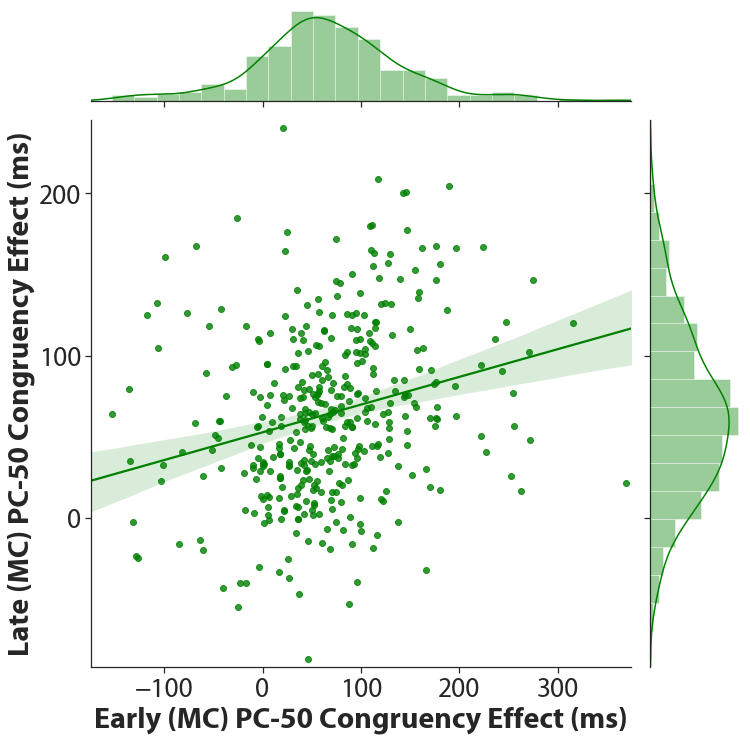

In [91]:
my_corr_graphs(mccong_early_UB.RT, mccong_late_UB.RT, 'Late (MC) PC-50 Congruency Effect (ms)', 'Early (MC) PC-50 Congruency Effect (ms)', "all_unbias_mc.png", 1, ov_mc_early_UB.RT, ov_mc_late_UB.RT,xminUBRT,xmaxUBRT,yminUBRT,ymaxUBRT,100)

In [92]:
r_unbias_mc, p_unbias_mc = stats.pearsonr(mccong_early_UB.RT, mccong_late_UB.RT)  
n_unbias_mc = len(mccong_early_UB.RT)
r2_unbias_mc, p2_unbias_mc = stats.pearsonr((mccong_early_UB.RT/ov_mc_early_UB.RT), (mccong_late_UB.RT/ov_mc_late_UB.RT))
n2_unbias_mc = len(mccong_early_UB.RT)

r_unbias_mc, p_unbias_mc, n_unbias_mc-2, r2_unbias_mc, p2_unbias_mc, n2_unbias_mc-2

independent_corr(r_unbias_mic, r_unbias_mc, n_unbias_mic, n_unbias_mc, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_unbias_mic, r2_unbias_mc, n2_unbias_mic, n2_unbias_mc, twotailed=True, conf_level=0.95, method='fisher')

(0.24787890456528608,
 5.150197642062226e-07,
 398,
 0.2670459029121335,
 5.860726521105475e-08,
 398)

(0.651895825897875, 0.5144683778357133)

(0.6989453409449643, 0.48458619038569495)

Now for Accuracy

In [93]:
ACCv9r1bias, ACCv9r1biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 1, 2, 1)
ACCv9r2bias, ACCv9r2biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 2, 2, 1)
ACCv9r3bias, ACCv9r3biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 3, 2, 1)
ACCv9r4bias, ACCv9r4biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 4, 2, 1) 

ACCv10r1bias, ACCv10r1biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 1, 2, 1)
ACCv10r2bias, ACCv10r2biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 2, 2, 1)
ACCv10r3bias, ACCv10r3biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 3, 2, 1)
ACCv10r4bias, ACCv10r4biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 4, 2, 1)

ACCv9r1UB, ACCv9r1UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 1, 1, 1) 
ACCv9r2UB, ACCv9r2UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 2, 1, 1)
ACCv9r3UB, ACCv9r3UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 3, 1, 1)
ACCv9r4UB, ACCv9r4UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 4, 1, 1)

ACCv10r1UB, ACCv10r1UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 1, 1, 1)
ACCv10r2UB, ACCv10r2UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 2, 1, 1)
ACCv10r3UB, ACCv10r3UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 3, 1, 1)
ACCv10r4UB, ACCv10r4UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 4, 1, 1)

In [94]:
mic_early_bias_ACC = ACCv9r1bias.append(ACCv10r3bias).sort_values(by=['subject']).reset_index()
mic_late_bias_ACC = ACCv9r2bias.append(ACCv10r4bias).sort_values(by=['subject']).reset_index()

mc_early_bias_ACC = ACCv9r3bias.append(ACCv10r1bias).sort_values(by=['subject']).reset_index()
mc_late_bias_ACC = ACCv9r4bias.append(ACCv10r2bias).sort_values(by=['subject']).reset_index()

mic_early_UB_ACC = ACCv9r1UB.append(ACCv10r3UB).sort_values(by=['subject']).reset_index()
mic_late_UB_ACC = ACCv9r2UB.append(ACCv10r4UB).sort_values(by=['subject']).reset_index()

mc_early_UB_ACC = ACCv9r3UB.append(ACCv10r1UB).sort_values(by=['subject']).reset_index()
mc_late_UB_ACC = ACCv9r4UB.append(ACCv10r2UB).sort_values(by=['subject']).reset_index()

In [95]:
xminACC4 = pd.concat([mic_early_bias_ACC.Accuracy, mc_early_bias_ACC.Accuracy, mic_early_UB_ACC.Accuracy, mic_late_UB_ACC.Accuracy], axis=0).min() - 1
xmaxACC4 = pd.concat([mic_early_bias_ACC.Accuracy, mc_early_bias_ACC.Accuracy, mic_early_UB_ACC.Accuracy, mic_late_UB_ACC.Accuracy], axis=0).max() + 1
yminACC4 = pd.concat([mic_late_bias_ACC.Accuracy, mc_late_bias_ACC.Accuracy, mc_early_UB_ACC.Accuracy, mc_late_UB_ACC.Accuracy], axis=0).min() - 1
ymaxACC4 = pd.concat([mic_late_bias_ACC.Accuracy, mc_late_bias_ACC.Accuracy, mc_early_UB_ACC.Accuracy, mc_late_UB_ACC.Accuracy], axis=0).max() + 1

In [96]:
mic_bias_ACC = mic_early_bias_ACC.append(mic_late_bias_ACC).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)
mc_bias_ACC = mc_early_bias_ACC.append(mc_late_bias_ACC).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)

mic_UB_ACC = mic_early_UB_ACC.append(mic_late_UB_ACC).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)
mc_UB_ACC = mc_early_UB_ACC.append(mc_late_UB_ACC).sort_values(by=['subject','Congruency']).reset_index().drop(['level_0','index'],axis=1)

LinregressResult(slope=0.3477763829673238, intercept=10.300775140395318, rvalue=0.37591838234713487, pvalue=6.109748411260609e-15, stderr=0.04286408517313379)

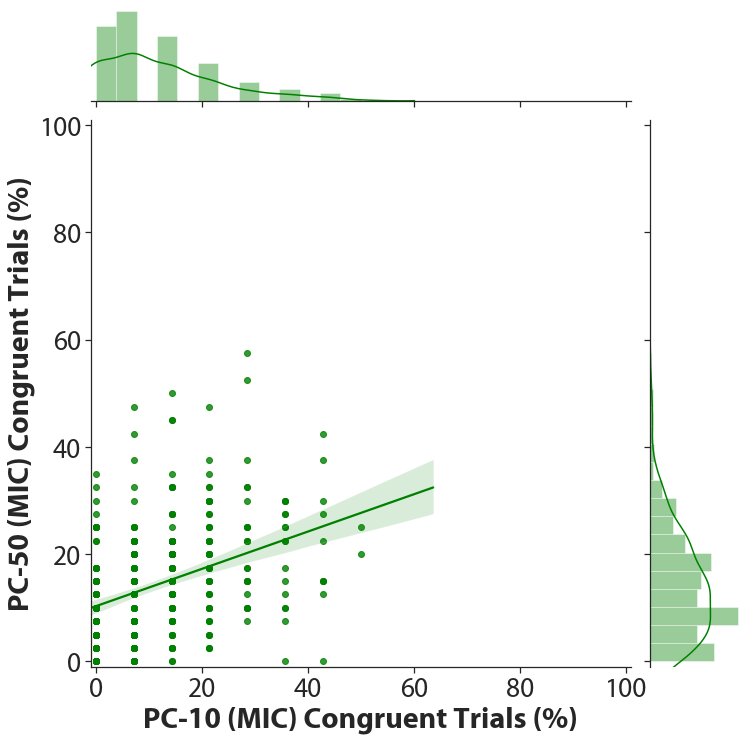

In [97]:
my_corr_graphs(mic_bias_ACC.loc[mic_bias_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean(), mic_UB_ACC.loc[mic_UB_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean(), 'PC-50 (MIC) Congruent Trials (%)', 'PC-10 (MIC) Congruent Trials (%)', "biasUB_mic_congruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.8701859567358761, intercept=11.11703543279282, rvalue=0.5857827812612163, pvalue=2.1145947700476152e-38, stderr=0.06019790759482342)

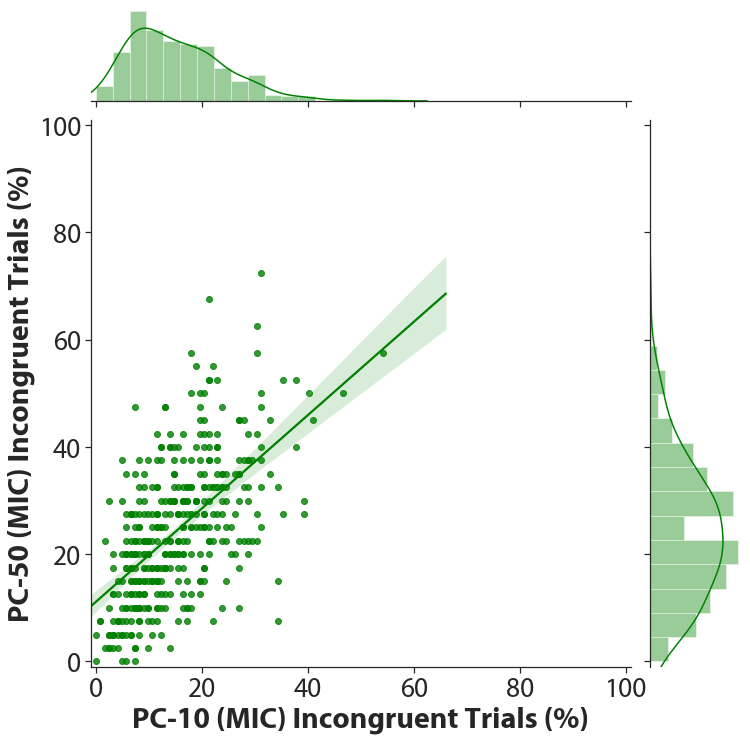

In [98]:
my_corr_graphs(mic_bias_ACC.loc[mic_bias_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean(), mic_UB_ACC.loc[mic_UB_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean(), 'PC-50 (MIC) Incongruent Trials (%)', 'PC-10 (MIC) Incongruent Trials (%)', "biasUB_mic_incongruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.9977365086209196, intercept=6.5461338512160605, rvalue=0.614381563029878, pvalue=4.397768190232455e-43, stderr=0.0640663059454424)

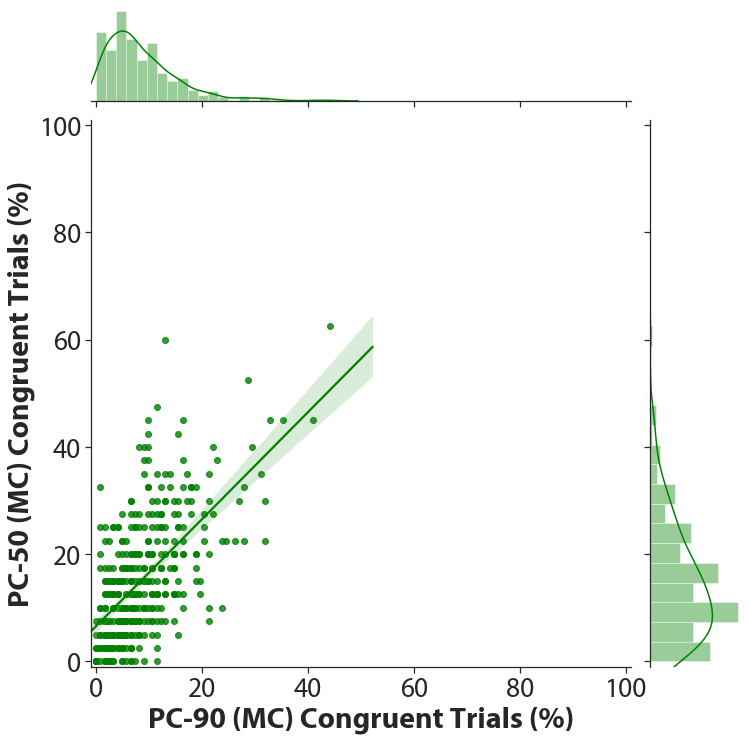

In [99]:
my_corr_graphs(mc_bias_ACC.loc[mc_bias_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean(), mc_UB_ACC.loc[mc_UB_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean(), 'PC-50 (MC) Congruent Trials (%)', 'PC-90 (MC) Congruent Trials (%)', "biasUB_mc_congruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.4729653699284758, intercept=12.245770928003346, rvalue=0.5732629155600552, pvalue=1.7078244449853737e-36, stderr=0.03380075064736866)

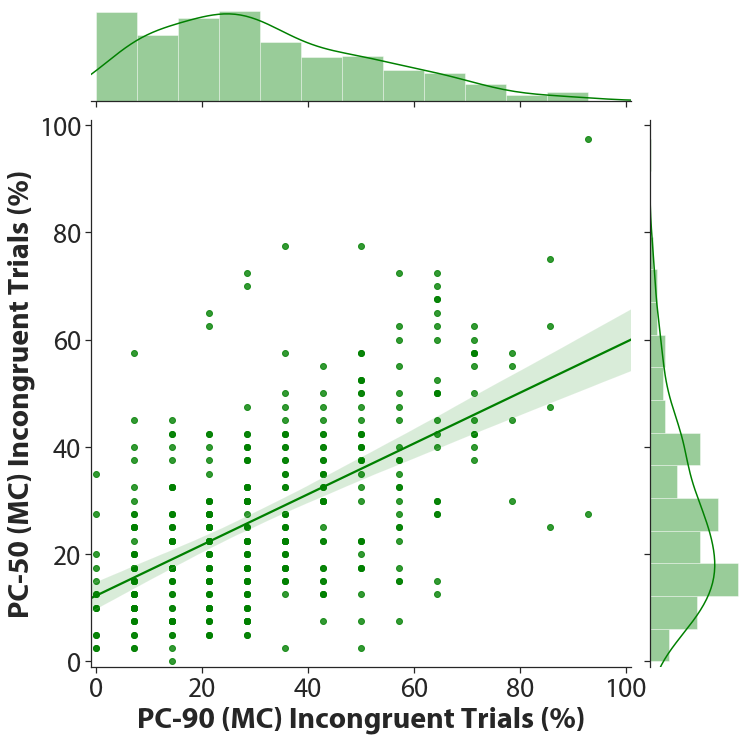

In [100]:
my_corr_graphs(mc_bias_ACC.loc[mc_bias_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean(), mc_UB_ACC.loc[mc_UB_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean(), 'PC-50 (MC) Incongruent Trials (%)', 'PC-90 (MC) Incongruent Trials (%)', "biasUB_mc_incongruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

In [101]:
r_UBbias_micc, p_UBbias_micc = stats.pearsonr(mic_bias_ACC.loc[mic_bias_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean(), mic_UB_ACC.loc[mic_UB_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean())  
n_UBbias_micc = len(mic_bias_ACC.loc[mic_bias_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean())

r_UBbias_micic, p_UBbias_micic = stats.pearsonr(mic_bias_ACC.loc[mic_bias_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean(), mic_UB_ACC.loc[mic_UB_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean())  
n_UBbias_micic = len(mic_bias_ACC.loc[mic_bias_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean())

r_UBbias_micc, p_UBbias_micc, n_UBbias_micc-2
r_UBbias_micic, p_UBbias_micic, n_UBbias_micic-2

independent_corr(r_UBbias_micc, r_UBbias_micic, n_UBbias_micc, n_UBbias_micic, twotailed=True, conf_level=0.95, method='fisher')


(0.3759183823471345, 6.109748411260685e-15, 400)

(0.5857827812612167, 2.114594770047106e-38, 400)

(3.8972694299532953, 9.728336918901626e-05)

In [102]:
r_UBbias_mcc, p_UBbias_mcc = stats.pearsonr(mc_bias_ACC.loc[mc_bias_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean(), mc_UB_ACC.loc[mc_UB_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean())  
n_UBbias_mcc = len(mc_bias_ACC.loc[mc_bias_ACC['Congruency']=='Congruent'].groupby(['subject'])['Accuracy'].mean())

r_UBbias_mcic, p_UBbias_mcic = stats.pearsonr(mc_bias_ACC.loc[mc_bias_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean(), mc_UB_ACC.loc[mc_UB_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean())  
n_UBbias_mcic = len(mc_bias_ACC.loc[mc_bias_ACC['Congruency']=='Incongruent'].groupby(['subject'])['Accuracy'].mean())

r_UBbias_mcc, p_UBbias_mcc, n_UBbias_mcc-2
r_UBbias_mcic, p_UBbias_mcic, n_UBbias_mcic-2

independent_corr(r_UBbias_mcc, r_UBbias_mcic, n_UBbias_mcc, n_UBbias_mcic, twotailed=True, conf_level=0.95, method='fisher')


(0.614381563029878, 4.3977681902321195e-43, 400)

(0.5732629155600547, 1.707824444985529e-36, 400)

(0.8977492676824698, 0.3693192369828113)

OK, now that we found reliability within a block, how about across blocks?

LinregressResult(slope=0.3296393329556373, intercept=4.056230917490874, rvalue=0.42908569951671954, pvalue=1.9465733263246615e-19, stderr=0.034696014268333526)

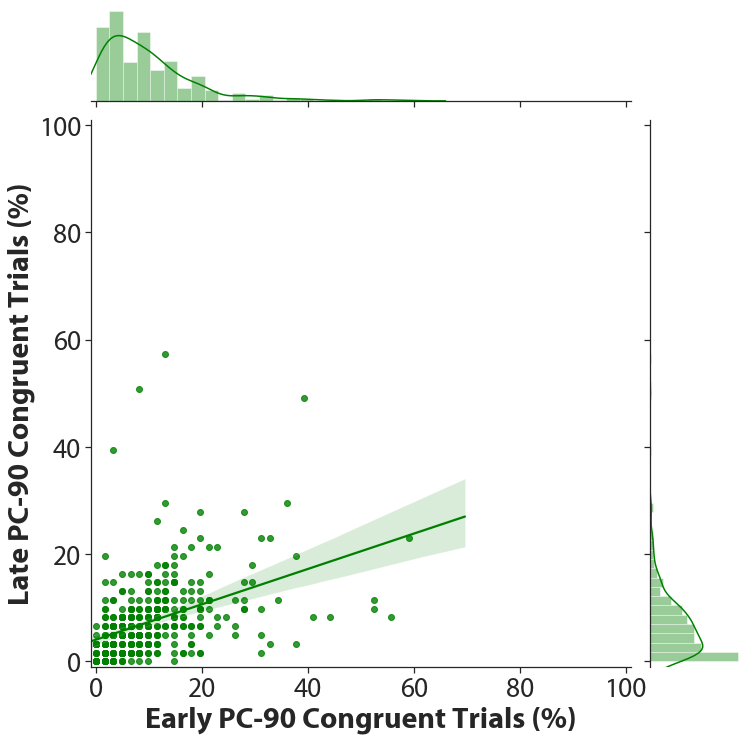

In [103]:
my_corr_graphs(mc_early_bias_ACC.loc[mc_early_bias_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], mc_late_bias_ACC.loc[mc_late_bias_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], 'Late PC-90 Congruent Trials (%)', 'Early PC-90 Congruent Trials (%)', "all_bias_mc_congruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.040322127563989625, intercept=5.920773745626484, rvalue=0.13981094977769618, pvalue=0.004980732221643824, stderr=0.014278599915579518)

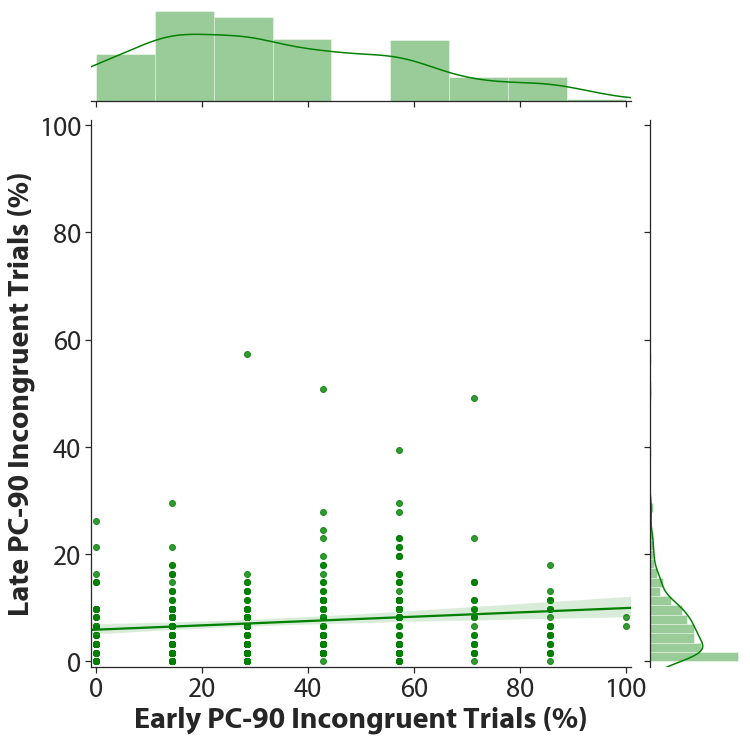

In [104]:
my_corr_graphs(mc_early_bias_ACC.loc[mc_early_bias_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], mc_late_bias_ACC.loc[mc_late_bias_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], 'Late PC-90 Incongruent Trials (%)', 'Early PC-90 Incongruent Trials (%)', "all_bias_mc_incongruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.16053577329808344, intercept=8.246978566707583, rvalue=0.19150986246886023, pvalue=0.0001117172506646661, stderr=0.041137402719338155)

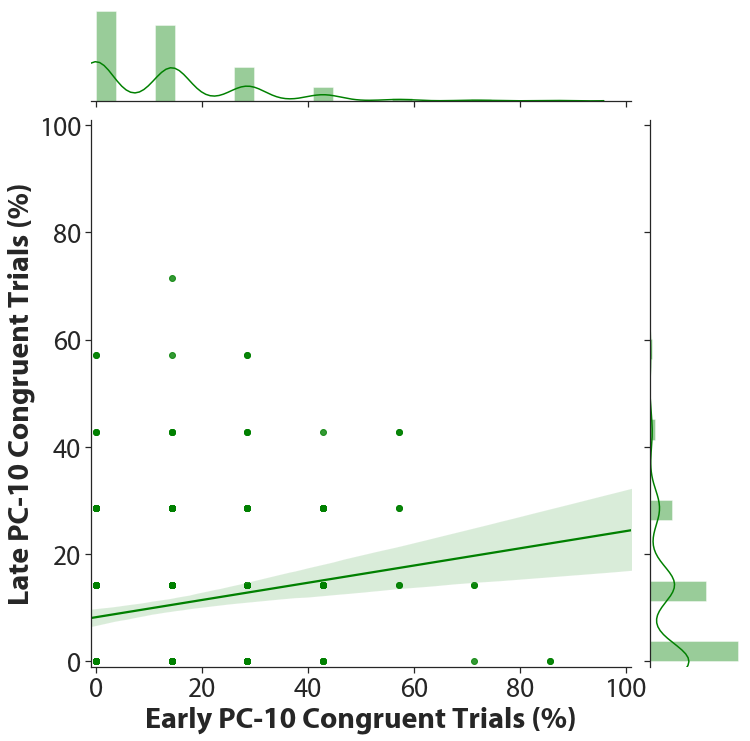

In [105]:
my_corr_graphs(mic_early_bias_ACC.loc[mic_early_bias_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], mic_late_bias_ACC.loc[mic_late_bias_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], 'Late PC-10 Congruent Trials (%)', 'Early PC-10 Congruent Trials (%)', "all_bias_mic_congruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.29737956713370667, intercept=6.223096757427152, rvalue=0.44541065690955195, pvalue=5.497577828706451e-21, stderr=0.02988834803533276)

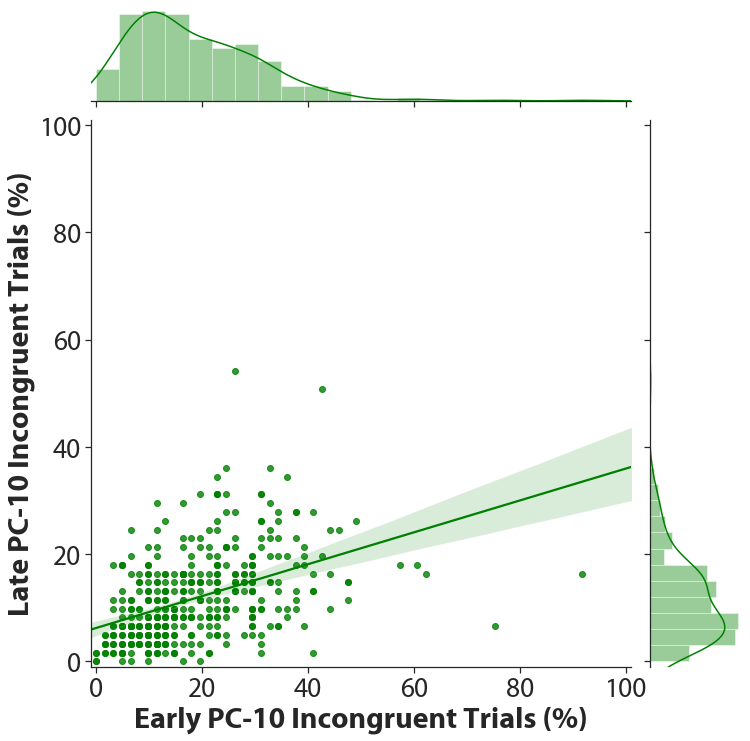

In [106]:
my_corr_graphs(mic_early_bias_ACC.loc[mic_early_bias_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], mic_late_bias_ACC.loc[mic_late_bias_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], 'Late PC-10 Incongruent Trials (%)', 'Early PC-10 Incongruent Trials (%)', "all_bias_mic_incongruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.3236324416975901, intercept=7.0808883762477866, rvalue=0.43309560831270666, pvalue=8.250724202459852e-20, stderr=0.03367679610729813)

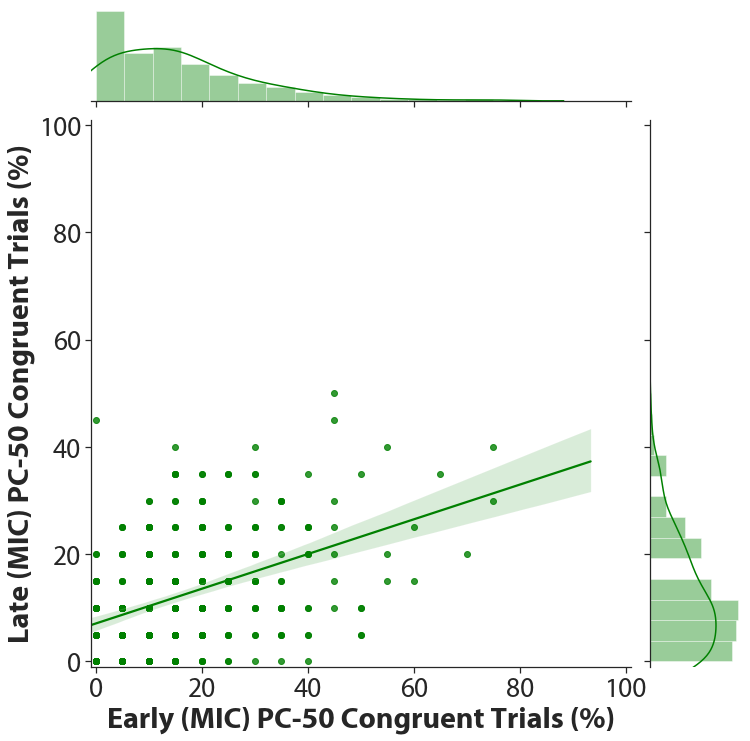

In [107]:
my_corr_graphs(mic_early_UB_ACC.loc[mic_early_UB_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], mic_late_UB_ACC.loc[mic_late_UB_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], 'Late (MIC) PC-50 Congruent Trials (%)', 'Early (MIC) PC-50 Congruent Trials (%)', "all_UB_mic_congruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)


LinregressResult(slope=0.3402944014080244, intercept=9.639163501168639, rvalue=0.46544608001141097, pvalue=5.2628255055529923e-23, stderr=0.03235460577011378)

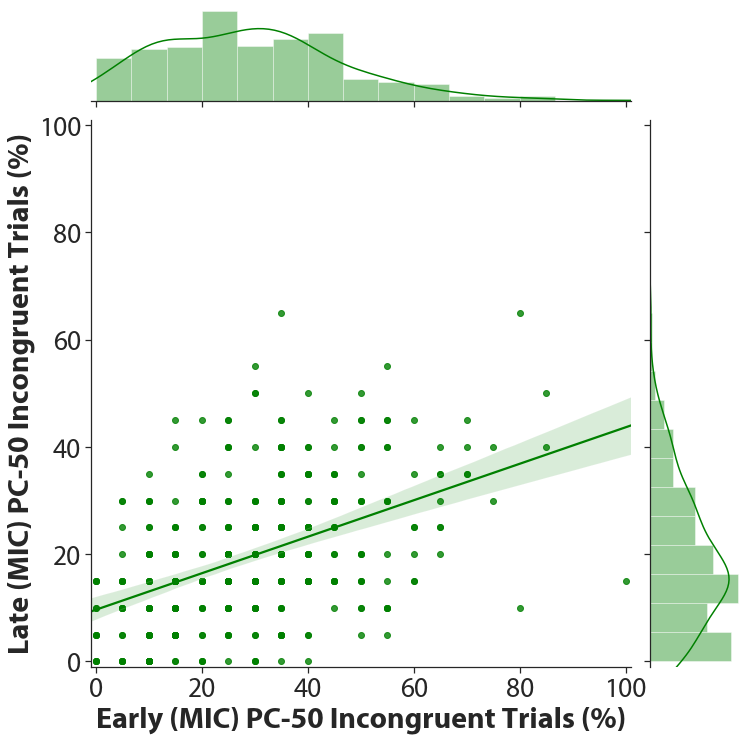

In [108]:
my_corr_graphs(mic_early_UB_ACC.loc[mic_early_UB_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], mic_late_UB_ACC.loc[mic_late_UB_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], 'Late (MIC) PC-50 Incongruent Trials (%)', 'Early (MIC) PC-50 Incongruent Trials (%)', "all_UB_mic_incongruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.43031811799989667, intercept=6.466957758235555, rvalue=0.4864386195842241, pvalue=2.8711757604959274e-25, stderr=0.03864570708260386)

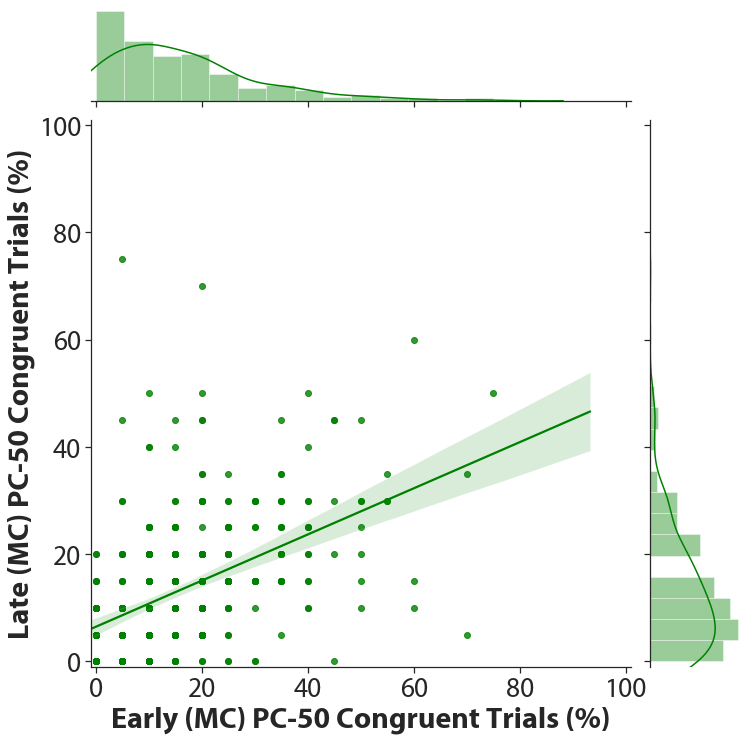

In [109]:
my_corr_graphs(mc_early_UB_ACC.loc[mc_early_UB_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], mc_late_UB_ACC.loc[mc_late_UB_ACC['Congruency']=='Congruent'].reset_index()['Accuracy'], 'Late (MC) PC-50 Congruent Trials (%)', 'Early (MC) PC-50 Congruent Trials (%)', "all_UB_mc_congruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

LinregressResult(slope=0.45024651319638176, intercept=8.021315291544013, rvalue=0.5948963226100901, pvalue=7.655530213047946e-40, stderr=0.030417841978220003)

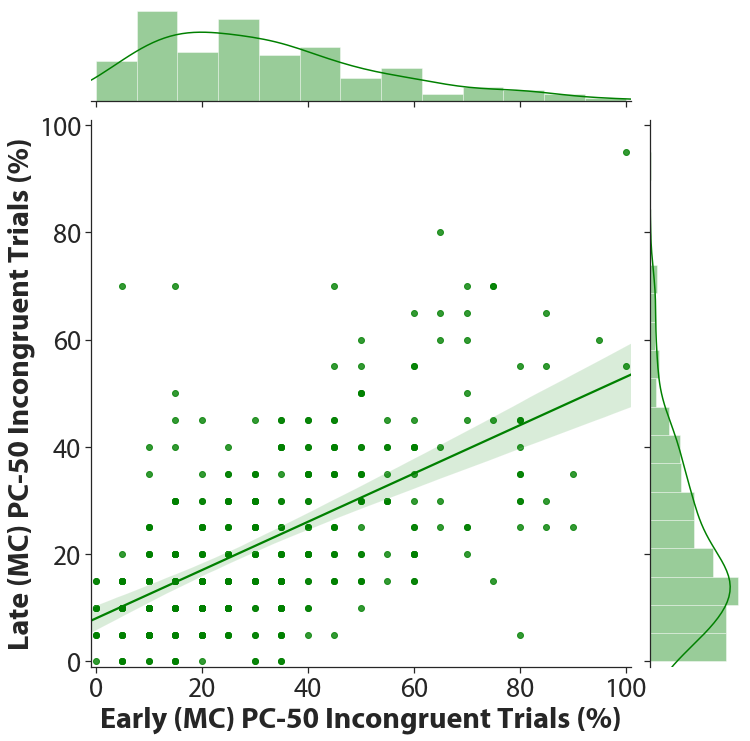

In [110]:
my_corr_graphs(mc_early_UB_ACC.loc[mc_early_UB_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], mc_late_UB_ACC.loc[mc_late_UB_ACC['Congruency']=='Incongruent'].reset_index()['Accuracy'], 'Late (MC) PC-50 Incongruent Trials (%)', 'Early (MC) PC-50 Incongruent Trials (%)', "all_UB_mc_incongruent_trials_ACC.png", 0, overallACC.Accuracy, overallACC.Accuracy,xminACC4,xmaxACC4,yminACC4,ymaxACC4,20)

In [111]:
ovACCv9biasr1 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biasr2 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biasr3 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biasr4 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10biasr1 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biasr2 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biasr3 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biasr4 = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv9UBr1 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBr2 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBr3 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBr4 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10UBr1 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==1].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBr2 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==2].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBr3 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBr4 = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter']==4].groupby(['subject'])['Accuracy'].mean().reset_index()

In [112]:
miccong_early_bias_ACC = ACCv9r1biascong.append(ACCv10r3biascong).reset_index()
miccong_late_bias_ACC = ACCv9r2biascong.append(ACCv10r4biascong).reset_index()

mccong_early_bias_ACC = ACCv9r3biascong.append(ACCv10r1biascong).reset_index()
mccong_late_bias_ACC = ACCv9r4biascong.append(ACCv10r2biascong).reset_index()

miccong_early_UB_ACC = ACCv9r1UBcong.append(ACCv10r3UBcong).reset_index()
miccong_late_UB_ACC = ACCv9r2UBcong.append(ACCv10r4UBcong).reset_index()

mccong_early_UB_ACC = ACCv9r3UBcong.append(ACCv10r1UBcong).reset_index()
mccong_late_UB_ACC = ACCv9r4UBcong.append(ACCv10r2UBcong).reset_index()

ov_mic_early_bias_ACC = ovACCv9biasr1.append(ovACCv10biasr3).reset_index()
ov_mic_late_bias_ACC = ovACCv9biasr2.append(ovACCv10biasr4).reset_index()

ov_mc_early_bias_ACC = ovACCv9biasr3.append(ovACCv10biasr1).reset_index()
ov_mc_late_bias_ACC = ovACCv9biasr4.append(ovACCv10biasr2).reset_index()

ov_mic_early_UB_ACC = ovACCv9UBr1.append(ovACCv10UBr3).reset_index()
ov_mic_late_UB_ACC = ovACCv9UBr2.append(ovACCv10UBr4).reset_index()

ov_mc_early_UB_ACC = ovACCv9UBr3.append(ovACCv10UBr1).reset_index()
ov_mc_late_UB_ACC = ovACCv9UBr4.append(ovACCv10UBr2).reset_index()

ov_mic_early_bias_ACC.Accuracy = 100 - (ov_mic_early_bias_ACC.Accuracy*100)
ov_mic_late_bias_ACC.Accuracy = 100 - (ov_mic_late_bias_ACC.Accuracy*100)
ov_mc_early_bias_ACC.Accuracy = 100 - (ov_mc_early_bias_ACC.Accuracy*100)
ov_mc_late_bias_ACC.Accuracy = 100 - (ov_mc_late_bias_ACC.Accuracy*100)
ov_mic_early_UB_ACC.Accuracy = 100 - (ov_mic_early_UB_ACC.Accuracy*100)
ov_mic_late_UB_ACC.Accuracy = 100 - (ov_mic_late_UB_ACC.Accuracy*100)
ov_mc_early_UB_ACC.Accuracy = 100 - (ov_mc_early_UB_ACC.Accuracy*100)
ov_mc_late_UB_ACC.Accuracy = 100 - (ov_mc_late_UB_ACC.Accuracy*100)

In [113]:
xminbiasACC = pd.concat([miccong_early_bias_ACC.Accuracy, mccong_early_bias_ACC.Accuracy], axis=0).min() - 1
xmaxbiasACC = pd.concat([miccong_early_bias_ACC.Accuracy, mccong_early_bias_ACC.Accuracy], axis=0).max() + 1
yminbiasACC = pd.concat([miccong_late_bias_ACC.Accuracy, mccong_late_bias_ACC.Accuracy], axis=0).min() - 1
ymaxbiasACC = pd.concat([miccong_late_bias_ACC.Accuracy, mccong_late_bias_ACC.Accuracy], axis=0).max() + 1

In [114]:
xminbiasACC, xmaxbiasACC, yminbiasACC, ymaxbiasACC

(-53.92740046838408, 97.72131147540983, -53.2248243559719, 99.36065573770492)

C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(LinregressResult(slope=0.11127164931153898, intercept=0.7733985726856185, rvalue=0.1181357934188891, pvalue=0.01781010110869921, stderr=0.04676502385428864),
 LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan))

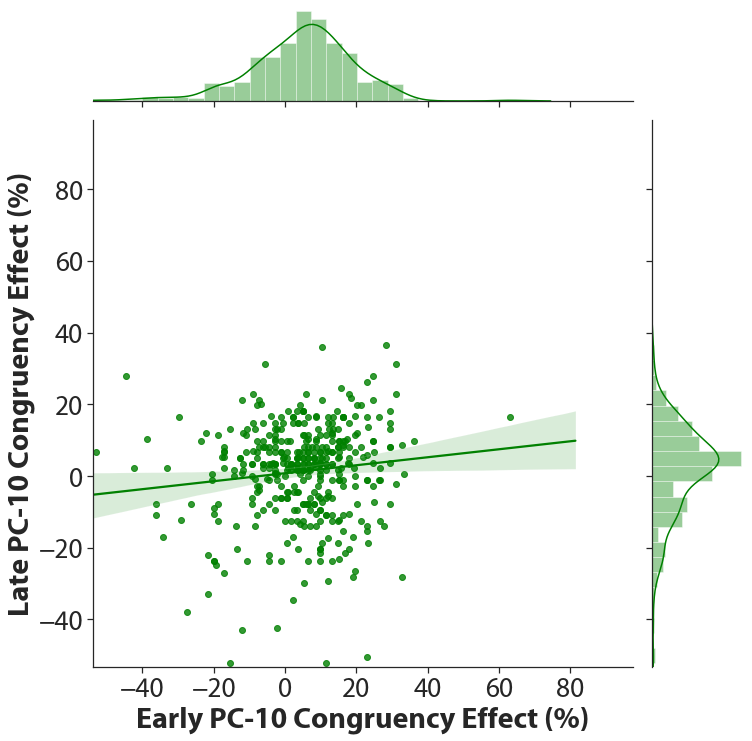

In [115]:
my_corr_graphs(miccong_early_bias_ACC.Accuracy, miccong_late_bias_ACC.Accuracy, 'Late PC-10 Congruency Effect (%)', 'Early PC-10 Congruency Effect (%)', "all_bias_mic_ACC.png", 1, ov_mic_early_bias_ACC.Accuracy, ov_mic_late_bias_ACC.Accuracy, xminbiasACC, xmaxbiasACC, yminbiasACC, ymaxbiasACC, 20)

(LinregressResult(slope=0.3995464631337272, intercept=11.259926291964216, rvalue=0.44359889024201965, pvalue=8.246126371519675e-21, stderr=0.04036120347870443),
 LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan))

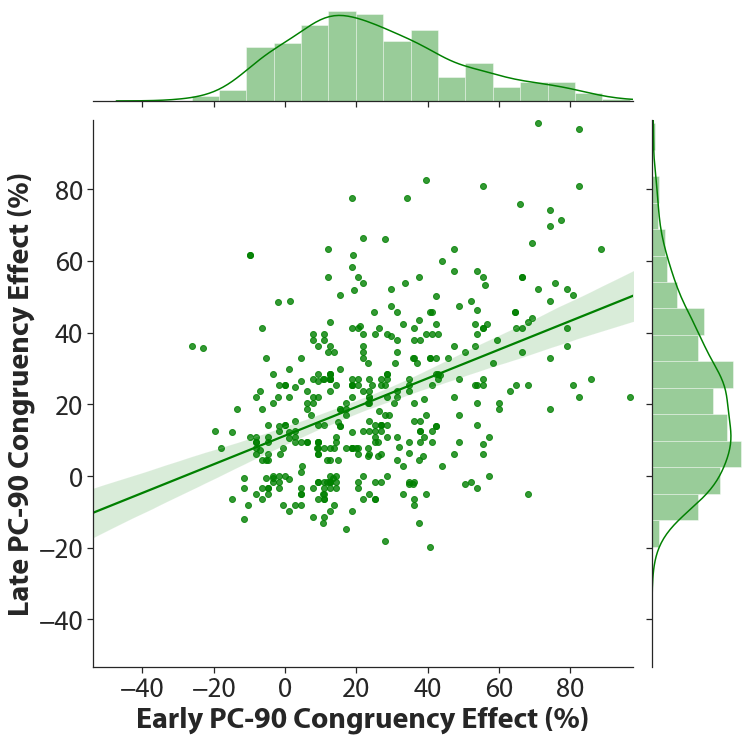

In [116]:
my_corr_graphs(mccong_early_bias_ACC.Accuracy, mccong_late_bias_ACC.Accuracy, 'Late PC-90 Congruency Effect (%)', 'Early PC-90 Congruency Effect (%)', "all_bias_mc_ACC.png", 1, ov_mc_early_bias_ACC.Accuracy, ov_mc_late_bias_ACC.Accuracy, xminbiasACC, xmaxbiasACC, yminbiasACC, ymaxbiasACC, 20)

In [117]:
xminUBACC = pd.concat([miccong_early_UB_ACC.Accuracy, mccong_early_UB_ACC.Accuracy], axis=0).min() - 1
xmaxUBACC = pd.concat([miccong_early_UB_ACC.Accuracy, mccong_early_UB_ACC.Accuracy], axis=0).max() + 1
yminUBACC = pd.concat([miccong_late_UB_ACC.Accuracy, mccong_late_UB_ACC.Accuracy], axis=0).min() - 1
ymaxUBACC = pd.concat([miccong_late_UB_ACC.Accuracy, mccong_late_UB_ACC.Accuracy], axis=0).max() + 1

In [118]:
xminUBACC, xmaxUBACC, yminUBACC, ymaxUBACC

(-31.0, 86.0, -40.99999999999999, 71.0)

(LinregressResult(slope=0.2844266224992372, intercept=3.537869212105363, rvalue=0.3512858435384158, pvalue=4.052614142627415e-13, stderr=0.03790355120524032),
 LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan))

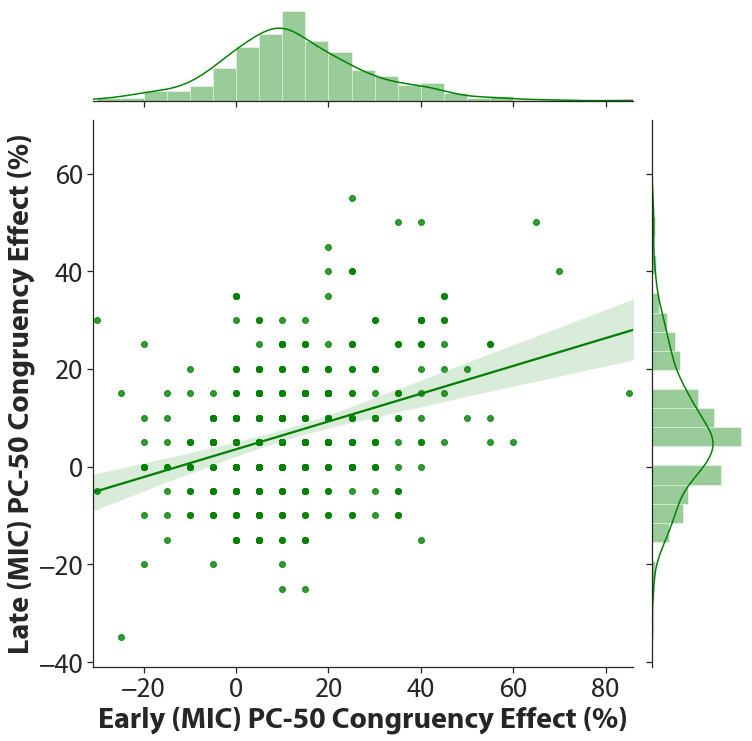

In [119]:
my_corr_graphs(miccong_early_UB_ACC.Accuracy, miccong_late_UB_ACC.Accuracy, 'Late (MIC) PC-50 Congruency Effect (%)', 'Early (MIC) PC-50 Congruency Effect (%)', "all_unbias_mic_ACC.png", 1, ov_mic_early_UB_ACC.Accuracy, ov_mic_late_UB_ACC.Accuracy, xminUBACC, xmaxUBACC, yminUBACC, ymaxUBACC, 20)

(LinregressResult(slope=0.3640394170316053, intercept=3.216307498517531, rvalue=0.44660385212580067, pvalue=4.203708087594043e-21, stderr=0.0364660584997873),
 LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan))

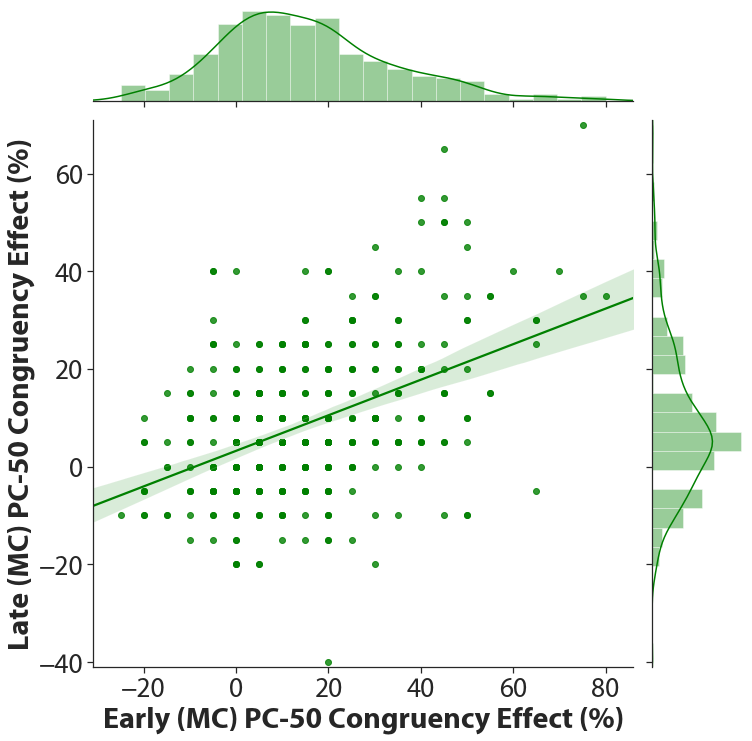

In [120]:
my_corr_graphs(mccong_early_UB_ACC.Accuracy, mccong_late_UB_ACC.Accuracy, 'Late (MC) PC-50 Congruency Effect (%)', 'Early (MC) PC-50 Congruency Effect (%)', "all_unbias_mc_acc.png", 1, ov_mc_early_UB_ACC.Accuracy, ov_mc_late_UB_ACC.Accuracy, xminUBACC, xmaxUBACC, yminUBACC, ymaxUBACC, 20)

In [121]:
ACCv9r1bias, ACCv9r1biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 1, 2, 2)
ACCv9r2bias, ACCv9r2biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 2, 2, 2)
ACCv9r3bias, ACCv9r3biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 3, 2, 2)
ACCv9r4bias, ACCv9r4biascong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 4, 2, 2) 
ACCv10r1bias, ACCv10r1biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 1, 2, 2)
ACCv10r2bias, ACCv10r2biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 2, 2, 2)
ACCv10r3bias, ACCv10r3biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 3, 2, 2)
ACCv10r4bias, ACCv10r4biascong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 4, 2, 2)
ACCv9r1UB, ACCv9r1UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 1, 1, 2) 
ACCv9r2UB, ACCv9r2UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 2, 1, 2)
ACCv9r3UB, ACCv9r3UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 3, 1, 2)
ACCv9r4UB, ACCv9r4UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 9, 4, 1, 2)
ACCv10r1UB, ACCv10r1UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 1, 1, 2)
ACCv10r2UB, ACCv10r2UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 2, 1, 2)
ACCv10r3UB, ACCv10r3UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 3, 1, 2)
ACCv10r4UB, ACCv10r4UBcong = cong_bias(adat, 'Accuracy', 'PC-50', 10, 4, 1, 2)

miccong_early_bias_ACC = ACCv9r1biascong.append(ACCv10r3biascong).reset_index()
miccong_late_bias_ACC = ACCv9r2biascong.append(ACCv10r4biascong).reset_index()
mccong_early_bias_ACC = ACCv9r3biascong.append(ACCv10r1biascong).reset_index()
mccong_late_bias_ACC = ACCv9r4biascong.append(ACCv10r2biascong).reset_index()
miccong_early_UB_ACC = ACCv9r1UBcong.append(ACCv10r3UBcong).reset_index()
miccong_late_UB_ACC = ACCv9r2UBcong.append(ACCv10r4UBcong).reset_index()
mccong_early_UB_ACC = ACCv9r3UBcong.append(ACCv10r1UBcong).reset_index()
mccong_late_UB_ACC = ACCv9r4UBcong.append(ACCv10r2UBcong).reset_index()

ov_mic_early_bias_ACC.Accuracy = (100 - ov_mic_early_bias_ACC.Accuracy)
ov_mic_late_bias_ACC.Accuracy = (100 - ov_mic_late_bias_ACC.Accuracy)
ov_mc_early_bias_ACC.Accuracy = (100 - ov_mc_early_bias_ACC.Accuracy)
ov_mc_late_bias_ACC.Accuracy = (100 - ov_mc_late_bias_ACC.Accuracy)
ov_mic_early_UB_ACC.Accuracy = (100 - ov_mic_early_UB_ACC.Accuracy)
ov_mic_late_UB_ACC.Accuracy = (100 - ov_mic_late_UB_ACC.Accuracy)
ov_mc_early_UB_ACC.Accuracy = (100 - ov_mc_early_UB_ACC.Accuracy)
ov_mc_late_UB_ACC.Accuracy = (100 - ov_mc_late_UB_ACC.Accuracy)

I've put all of these towards the end because I needed to recalculate the effects for Accuracy as % or Proportion Correct, since some folks have no errors, and you cannot divide by 0 for "correcting" the correlation.

In [122]:
r_bias_mic_a, p_bias_mic_a = stats.pearsonr(miccong_early_bias_ACC.Accuracy, miccong_late_bias_ACC.Accuracy)  
n_bias_mic_a = len(miccong_early_bias_ACC.Accuracy)
r2_bias_mic_a, p2_bias_mic_a = stats.pearsonr((miccong_early_bias_ACC.Accuracy/ov_mic_early_bias_ACC.Accuracy), (miccong_late_bias_ACC.Accuracy/ov_mic_late_bias_ACC.Accuracy))
n2_bias_mic_a = len(miccong_early_bias_ACC.Accuracy)

r_bias_mic_a, p_bias_mic_a, n_bias_mic_a-2, r2_bias_mic_a, p2_bias_mic_a, n2_bias_mic_a-2

(0.1181357934188891,
 0.017810101108698382,
 400,
 0.10985633215355509,
 0.027635390316479675,
 400)

In [123]:
r_bias_mc_a, p_bias_mc_a = stats.pearsonr(mccong_early_bias_ACC.Accuracy, mccong_late_bias_ACC.Accuracy)  
n_bias_mc_a = len(mccong_early_bias_ACC.Accuracy)
r2_bias_mc_a, p2_bias_mc_a = stats.pearsonr((mccong_early_bias_ACC.Accuracy/ov_mc_early_bias_ACC.Accuracy), (mccong_late_bias_ACC.Accuracy/ov_mc_late_bias_ACC.Accuracy))
n2_bias_mc_a = len(mccong_early_bias_ACC.Accuracy)

r_bias_mc_a, p_bias_mc_a, n_bias_mc_a-2, r2_bias_mc_a, p2_bias_mc_a, n2_bias_mc_a-2

independent_corr(r_bias_mic_a, r_bias_mc_a, n_bias_mic_a, n_bias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_bias_mic_a, r2_bias_mc_a, n2_bias_mic_a, n2_bias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

(0.4435988902420197,
 8.246126371519023e-21,
 400,
 0.45464411272117106,
 6.702962754827356e-22,
 400)

(5.056728722580866, 4.2650926435072734e-07)

(5.370644281081927, 7.845583316345994e-08)

In [124]:
r_unbias_mic_a, p_unbias_mic_a = stats.pearsonr(miccong_early_UB_ACC.Accuracy, miccong_late_UB_ACC.Accuracy)  
n_unbias_mic_a = len(miccong_early_UB_ACC.Accuracy)
r2_unbias_mic_a, p2_unbias_mic_a = stats.pearsonr((miccong_early_UB_ACC.Accuracy/ov_mic_early_UB_ACC.Accuracy), (miccong_late_UB_ACC.Accuracy/ov_mic_late_UB_ACC.Accuracy))
n2_unbias_mic_a = len(miccong_early_UB_ACC.Accuracy)

r_unbias_mic_a, p_unbias_mic_a, n_unbias_mic_a-2, r2_unbias_mic_a, p2_unbias_mic_a, n2_unbias_mic_a-2

(0.35128584353841585,
 4.0526141426271203e-13,
 400,
 0.35804605160504643,
 1.3283522563788185e-13,
 400)

In [125]:
r_unbias_mc_a, p_unbias_mc_a = stats.pearsonr(mccong_early_UB_ACC.Accuracy, mccong_late_UB_ACC.Accuracy)  
n_unbias_mc_a = len(mccong_early_UB_ACC.Accuracy)
r2_unbias_mc_a, p2_unbias_mc_a = stats.pearsonr((mccong_early_UB_ACC.Accuracy/ov_mc_early_UB_ACC.Accuracy), (mccong_late_UB_ACC.Accuracy/ov_mc_late_UB_ACC.Accuracy))
n2_unbias_mc_a = len(mccong_early_UB_ACC.Accuracy)

r_unbias_mc_a, p_unbias_mc_a, n_unbias_mc_a-2, r2_unbias_mc_a, p2_unbias_mc_a, n2_unbias_mc_a-2

independent_corr(r_unbias_mic_a, r_unbias_mc_a, n_unbias_mic_a, n_unbias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

independent_corr(r2_unbias_mic_a, r2_unbias_mc_a, n2_unbias_mic_a, n2_unbias_mc_a, twotailed=True, conf_level=0.95, method='fisher')

(0.4466038521258006,
 4.2037080875938306e-21,
 400,
 0.488311445696772,
 1.7719923346915672e-25,
 400)

(1.603690397765737, 0.10878231351373469)

(2.2485815887404508, 0.024539128869452753)

From the "Modest Reliability of Control-Learning Measures" subsection:

We thus tested whether our measures of control-learning were reliable, given general concerns about the reliability of cognitive control tasks (Whitehead et al., 2019). For greater power, we collapsed across block orders. We ran correlations for behavioral measures across the “early/first” (e.g., block 1 for MC-MC-MIC-MIC and block 3 for MIC-MIC-MC-MC) and “late/second” (e.g., block 2 for MC-MC-MIC-MIC and block 4 for MIC-MIC-MC-MC) blocks of each PC context for each trial type (congruent/incongruent) (cf. Bejjani, Siqi-Liu, et al., 2020). Mean participant RT for unbiased items showed acceptable reliability for congruent trials (Figure 5A-D; PC-75: r(400) = 0.72, p < 0.001; PC-25: r(400) = 0.70, p < 0.001) and incongruent trials (PC-75: r(398) = 0.67, p < 0.001; PC-25: r(399) = 0.67, p < 0.001) across early and late blocks. Mean error rates for unbiased items showed worse reliability than RT (Figure 5E-H; PC-75 congruent: r(400) = 0.49, p < 0.001; PC-75 incongruent: r(400) = 0.59, p < 0.001; PC-25 congruent: r(400) = 0.43, p < 0.001; PC-25 incongruent: r(400) = 0.47, p < 0.001), but as with the biased/unbiased item correlations, this is likely due to the psychometric properties of accuracy as a dependent measure. Importantly, even though block order led to differences in the LWPC effect, the behavioral metrics were nonetheless stable, and the correlation strength was similar across all contexts and trial types.

Next, because researchers often use difference scores in individual difference research despite their poor psychometric properties, we ran correlations between congruency effects across the mostly congruent and incongruent contexts for unbiased items. Early (first block) compared to late (second block) congruency effects for unbiased items were moderately and positively correlated within both the mostly congruent (RT: r(398) = 0.25, p < 0.001; corrected: r(398) = 0.27, p < 0.001; Accuracy: r(400) = 0.45, p < 0.001; corrected: r(400) = 0.49, p < 0.001) and mostly incongruent (RT: r(399) = 0.20, p < 0.001; corrected: r(399) = 0.22, p < 0.001; Accuracy: r(400) = 0.35, p < 0.001; corrected: r(400) = 0.36, p < 0.001) contexts. Comparing these correlation coefficients, using a Fischer’s r-to-z transformation, we found slight evidence for greater reliability within the mostly congruent context via accuracy (uncorrected: z = 1.60, p = 0.109; corrected: z = 2.25, p = 0.025) but not RT (uncorrected: z = 0.65, p = 0.514; corrected: z = 0.70, p = 0.485). In short, these control-learning measures showed acceptable reliability and were stable across blocks within the study (for the corresponding analyses on biased items, see Supplementary Text), such that participants responded consistently to each trial type within and across PC contexts over time. Thus, the lack of correlations between these measures and metrics of reward and punishment sensitivity cannot be accounted for by poor reliability in the control-learning measurements.

### Are the biased and unbiased congruency effects related within context?

One key determinant of the unbiased LWPC effect should be the learning process taking place with respect to the biased items. Specifically, an underlying assumption of PC paradigms is that the biased items drive the learning, and the resultant adjustments in control are then extended to the unbiased items. Accordingly, congruency effects for biased and unbiased items should be positively correlated, but to the best of our knowledge this has not previously been assessed in the LWPC protocol (cf. Bugg & Dey, 2018; Gonthier et al., 2016). We therefore calculated correlations between congruency effects for both biased and unbiased items across PC contexts (collapsed across block orders, for greater power). Of note, difference scores like congruency effects are more variable than standard behavioral metrics (Hedge et al., 2018; Rouder & Haaf, 2019), so these correlations would not be expected to be as large as those for condition-specific mean RTs.

(I.e., above we already looked at biased + unbiased item associations within each PC context for the trial type conditions. Here, we're just looking at the congruency effects.)

In [158]:
def relate_bias(df, dv, ItemFilter, VersionFilter, biasrun, Accuracy):
    if biasrun == 1: #early UB
        sub_means = df.loc[df['Item']==ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] < 3].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 2: #late UB
        sub_means = df.loc[df['Item']==ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] > 2].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 3: #early B
        sub_means = df.loc[df['Item']!=ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] < 3].groupby(['subject','Congruency'])[dv].mean().reset_index()
    elif biasrun == 4: #late B
        sub_means = df.loc[df['Item']!=ItemFilter].loc[df['Version']==VersionFilter].loc[df['RunCounter'] > 2].groupby(['subject','Congruency'])[dv].mean().reset_index()
    
    if Accuracy == 1: #error rates
        sub_means[dv] = 100 - (sub_means[dv]*100)
    elif Accuracy == 2: #percentage
        sub_means[dv] = sub_means[dv]*100
    
    Congdiff = sub_means.loc[sub_means['Congruency']=='Incongruent'].reset_index()[dv] - sub_means.loc[sub_means['Congruency']=='Congruent'].reset_index()[dv]
    return sub_means, Congdiff

In [159]:
RTv9earlybias, RTv9earlybiascong = relate_bias(cdat, 'RT', 'PC-50', 9, 3, 0)
RTv9latebias, RTv9latebiascong = relate_bias(cdat, 'RT', 'PC-50', 9, 4, 0)

RTv10earlybias, RTv10earlybiascong = relate_bias(cdat, 'RT', 'PC-50', 10, 3, 0)
RTv10latebias, RTv10latebiascong = relate_bias(cdat, 'RT', 'PC-50', 10, 4, 0)

RTv9earlyUB, RTv9earlyUBcong = relate_bias(cdat, 'RT', 'PC-50', 9, 1, 0)
RTv9lateUB, RTv9lateUBcong = relate_bias(cdat, 'RT', 'PC-50', 9, 2, 0)

RTv10earlyUB, RTv10earlyUBcong = relate_bias(cdat, 'RT', 'PC-50', 10, 1, 0)
RTv10lateUB, RTv10lateUBcong = relate_bias(cdat, 'RT', 'PC-50', 10, 2, 0)

In [160]:
ovRTv9biasearly = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9biaslate = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10biasearly = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10biaslate = cdat.loc[cdat['Item']!="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

ovRTv9UBearly = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv9UBlate = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==9].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

ovRTv10UBearly = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] < 3].groupby(['subject'])['RT'].mean().reset_index()
ovRTv10UBlate = cdat.loc[cdat['Item']=="PC-50"].loc[cdat['Version']==10].loc[cdat['RunCounter'] > 2].groupby(['subject'])['RT'].mean().reset_index()

In [161]:
miccong_bias = RTv9earlybiascong.append(RTv10latebiascong).reset_index()
mccong_bias = RTv9latebiascong.append(RTv10earlybiascong).reset_index()

miccong_UB = RTv9earlyUBcong.append(RTv10lateUBcong).reset_index()
mccong_UB = RTv9lateUBcong.append(RTv10earlyUBcong).reset_index()

ov_mic_bias = ovRTv9biasearly.append(ovRTv10biaslate).reset_index()
ov_mc_bias = ovRTv9biaslate.append(ovRTv10biasearly).reset_index()

ov_mic_UB = ovRTv9UBearly.append(ovRTv10UBlate).reset_index()
ov_mc_UB = ovRTv9UBlate.append(ovRTv10UBearly).reset_index()

In [162]:
np.where(pd.isnull(miccong_bias.RT))
np.where(pd.isnull(mccong_bias.RT))
np.where(pd.isnull(miccong_UB.RT))
np.where(pd.isnull(mccong_UB.RT))
np.where(pd.isnull(ov_mic_bias.RT))
np.where(pd.isnull(ov_mc_bias.RT))
np.where(pd.isnull(ov_mic_UB.RT))
np.where(pd.isnull(ov_mc_UB.RT))

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

(array([], dtype=int64),)

In [163]:
xminbubRT = pd.concat([miccong_bias.RT, mccong_bias.RT], axis=0).min() - 5
xmaxbubRT = pd.concat([miccong_bias.RT, mccong_bias.RT], axis=0).max() + 5
yminbubRT = pd.concat([miccong_UB.RT, mccong_UB.RT], axis=0).min() - 5
ymaxbubRT = pd.concat([miccong_UB.RT, mccong_UB.RT], axis=0).max() + 5

In [164]:
xminbubRT, xmaxbubRT, yminbubRT, ymaxbubRT

(-127.4150326797386,
 364.43365695792875,
 -47.21739130434787,
 242.93333333333328)

(LinregressResult(slope=0.09628879145237593, intercept=23.73916106968843, rvalue=0.0844766190859147, pvalue=0.09074106992713914, stderr=0.05678766771365693),
 LinregressResult(slope=0.11209372398534298, intercept=0.034667407256408454, rvalue=0.09475233411847339, pvalue=0.05767828523650576, stderr=0.05888477657014503))

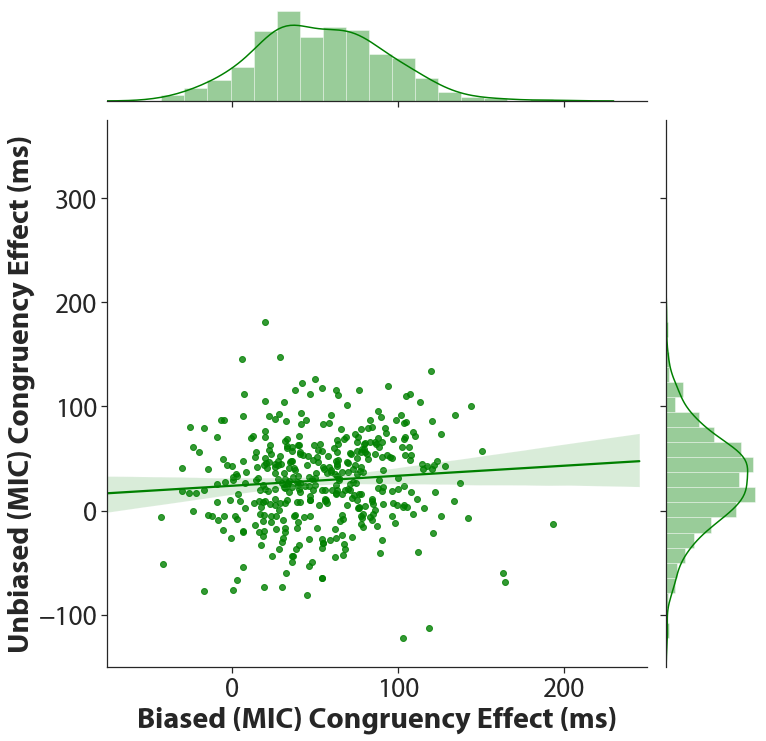

In [165]:
my_corr_graphs(miccong_UB.RT, miccong_bias.RT, 'Unbiased (MIC) Congruency Effect (ms)', 'Biased (MIC) Congruency Effect (ms)', "biasunbias_micRT.png", 1, ov_mic_UB.RT, ov_mic_bias.RT, -75, 250, -150, 375, 100)

(LinregressResult(slope=0.5043102579468938, intercept=70.51380806272728, rvalue=0.3191091130841171, pvalue=5.745002695487177e-11, stderr=0.07488722203636292),
 LinregressResult(slope=0.5142975842869549, intercept=0.11586399121594121, rvalue=0.29265661412358285, pvalue=2.218801175426112e-09, stderr=0.08402003919599434))

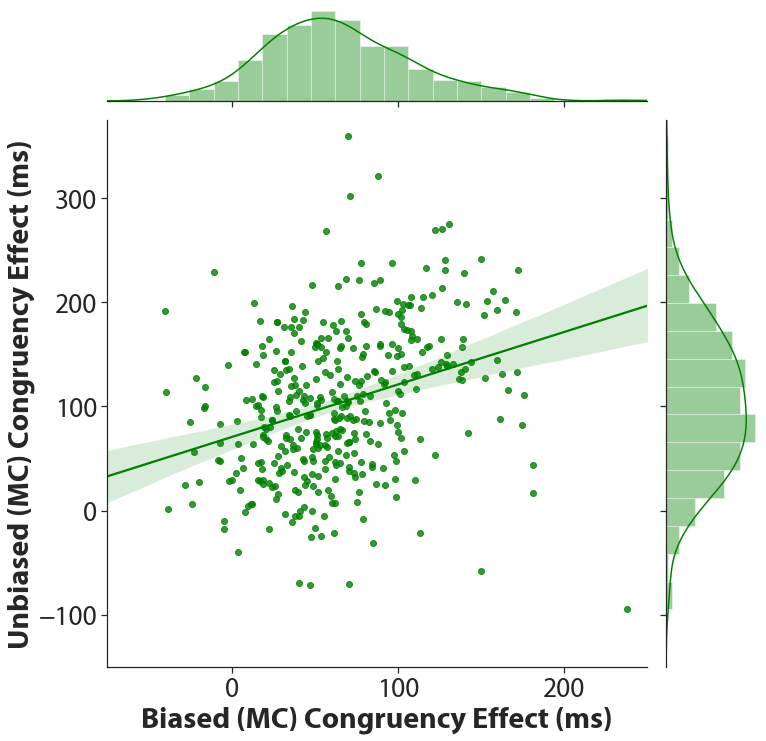

In [166]:
my_corr_graphs(mccong_UB.RT, mccong_bias.RT, 'Unbiased (MC) Congruency Effect (ms)', 'Biased (MC) Congruency Effect (ms)', "biasunbias_mcRT.png", 1, ov_mc_UB.RT, ov_mc_bias.RT,  -75, 250, -150, 375, 100)

In [167]:
ACCv9earlybias, ACCv9earlybiascong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 3, 1)
ACCv9latebias, ACCv9latebiascong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 4, 1)

ACCv10earlybias, ACCv10earlybiascong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 3, 1)
ACCv10latebias, ACCv10latebiascong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 4, 1)

ACCv9earlyUB, ACCv9earlyUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 1, 1)
ACCv9lateUB, ACCv9lateUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 2, 1)

ACCv10earlyUB, ACCv10earlyUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 1, 1)
ACCv10lateUB, ACCv10lateUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 2, 1)

In [168]:
ovACCv9biasearly = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9biaslate = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10biasearly = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10biaslate = adat.loc[adat['Item']!="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv9UBearly = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv9UBlate = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==9].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

ovACCv10UBearly = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] < 3].groupby(['subject'])['Accuracy'].mean().reset_index()
ovACCv10UBlate = adat.loc[adat['Item']=="PC-50"].loc[adat['Version']==10].loc[adat['RunCounter'] > 2].groupby(['subject'])['Accuracy'].mean().reset_index()

In [169]:
miccong_bias_ACC = ACCv9earlybiascong.append(ACCv10latebiascong).reset_index()
mccong_bias_ACC = ACCv9latebiascong.append(ACCv10earlybiascong).reset_index()

miccong_UB_ACC = ACCv9earlyUBcong.append(ACCv10lateUBcong).reset_index()
mccong_UB_ACC = ACCv9lateUBcong.append(ACCv10earlyUBcong).reset_index()

ov_mic_bias_ACC = ovACCv9biasearly.append(ovACCv10biaslate).reset_index()
ov_mc_bias_ACC = ovACCv9biaslate.append(ovACCv10biasearly).reset_index()

ov_mic_UB_ACC = ovACCv9UBearly.append(ovACCv10UBlate).reset_index()
ov_mc_UB_ACC = ovACCv9UBlate.append(ovACCv10UBearly).reset_index()

ov_mic_bias_ACC.Accuracy = 100 - (ov_mic_bias_ACC.Accuracy*100)
ov_mc_bias_ACC.Accuracy = 100 - (ov_mc_bias_ACC.Accuracy*100)
ov_mic_UB_ACC.Accuracy = 100 - (ov_mic_UB_ACC.Accuracy*100)
ov_mc_UB_ACC.Accuracy = 100 - (ov_mc_UB_ACC.Accuracy*100)

In [170]:
xminbubACC = pd.concat([miccong_bias_ACC.Accuracy, mccong_bias_ACC.Accuracy], axis=0).min() - 1
xmaxbubACC = pd.concat([miccong_bias_ACC.Accuracy, mccong_bias_ACC.Accuracy], axis=0).max() + 1
yminbubACC = pd.concat([miccong_UB_ACC.Accuracy, mccong_UB_ACC.Accuracy], axis=0).min() - 1
ymaxbubACC = pd.concat([miccong_UB_ACC.Accuracy, mccong_UB_ACC.Accuracy], axis=0).max() + 1

In [171]:
xminbubACC, xmaxbubACC, yminbubACC, ymaxbubACC

(-34.840749414519905, 90.5784543325527, -31.0, 73.5)

(LinregressResult(slope=0.09186951534194979, intercept=2.1424147985227138, rvalue=0.10796186946088006, pvalue=0.03044765428134505, stderr=0.042298517869478254),
 LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan))

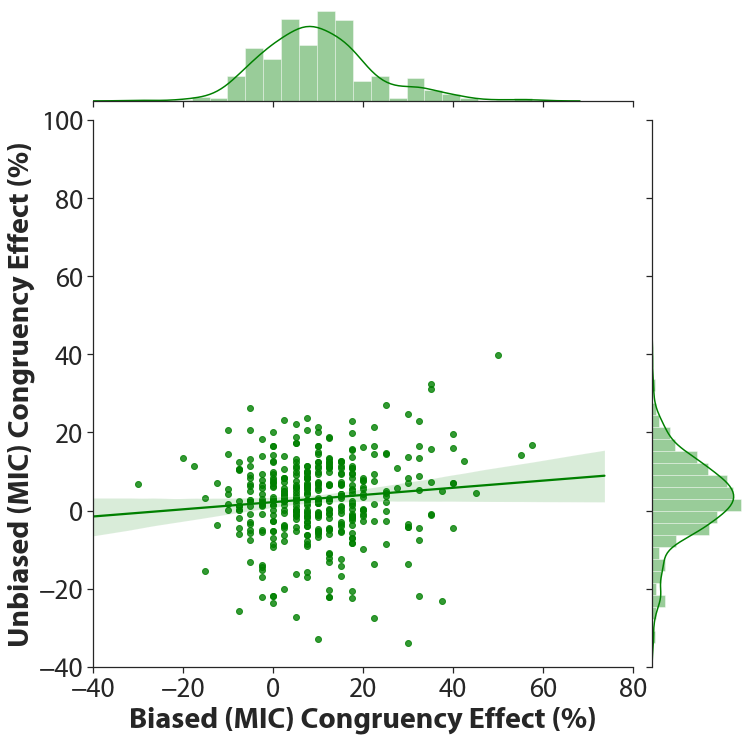

In [172]:
my_corr_graphs(miccong_UB_ACC.Accuracy, miccong_bias_ACC.Accuracy, 'Unbiased (MIC) Congruency Effect (%)', 'Biased (MIC) Congruency Effect (%)', "biasunbias_micACC.png", 1, ov_mic_UB_ACC.Accuracy, ov_mic_bias_ACC.Accuracy, -40, 80, -40, 100,20)

(LinregressResult(slope=0.5817130637901173, intercept=16.11580006051648, rvalue=0.4363918436122929, pvalue=4.039469196651049e-20, stderr=0.059969067604728164),
 LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan))

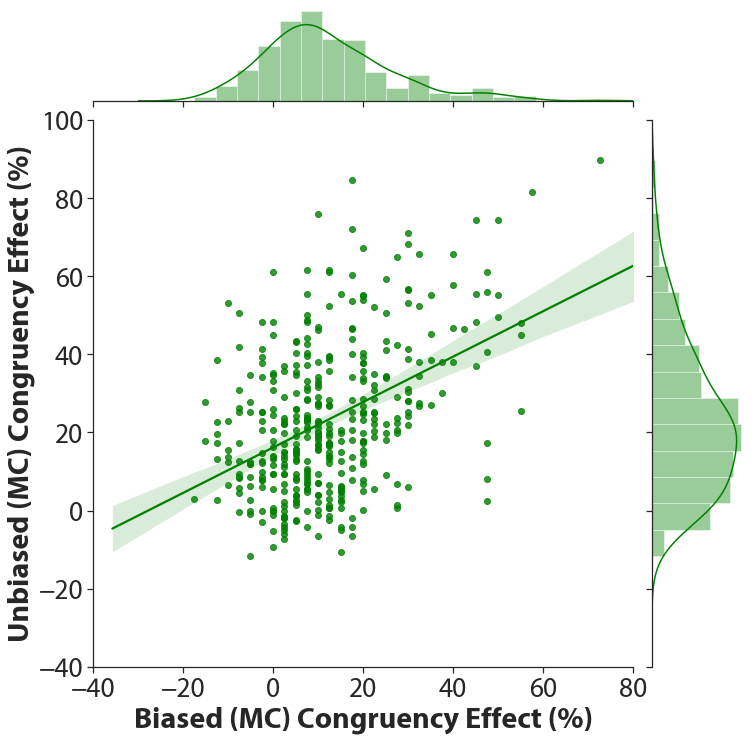

In [173]:
my_corr_graphs(mccong_UB_ACC.Accuracy, mccong_bias_ACC.Accuracy, 'Unbiased (MC) Congruency Effect (%)', 'Biased (MC) Congruency Effect (%)', "biasunbias_mcACC.png", 1, ov_mc_UB_ACC.Accuracy, ov_mc_bias_ACC.Accuracy, -40, 80, -40, 100, 20)

Note that above, the corrected correlation does not come out because one of the participants had a 0% error rate on the mostly congruent congruency effects. So, we cannot do 0/--. The way to calculate the corrected correlation is to return to proportion correct, or percentages, as the DV. You can see that the numbers are identical to what's reported above, too. I mostly wanted to make 'error rate' graphs to be consistent with the previous figure on learning rate data.

In [174]:
ACCv9earlybias, ACCv9earlybiascong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 3, 2)
ACCv9latebias, ACCv9latebiascong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 4, 2)

ACCv10earlybias, ACCv10earlybiascong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 3, 2)
ACCv10latebias, ACCv10latebiascong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 4, 2)

ACCv9earlyUB, ACCv9earlyUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 1, 2)
ACCv9lateUB, ACCv9lateUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 9, 2, 2)

ACCv10earlyUB, ACCv10earlyUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 1, 2)
ACCv10lateUB, ACCv10lateUBcong = relate_bias(adat, 'Accuracy', 'PC-50', 10, 2, 2)

miccong_bias_ACC = ACCv9earlybiascong.append(ACCv10latebiascong).reset_index()
mccong_bias_ACC = ACCv9latebiascong.append(ACCv10earlybiascong).reset_index()

miccong_UB_ACC = ACCv9earlyUBcong.append(ACCv10lateUBcong).reset_index()
mccong_UB_ACC = ACCv9lateUBcong.append(ACCv10earlyUBcong).reset_index()

ov_mic_bias_ACC = ovACCv9biasearly.append(ovACCv10biaslate).reset_index()
ov_mc_bias_ACC = ovACCv9biaslate.append(ovACCv10biasearly).reset_index()

ov_mic_UB_ACC = ovACCv9UBearly.append(ovACCv10UBlate).reset_index()
ov_mc_UB_ACC = ovACCv9UBlate.append(ovACCv10UBearly).reset_index()

ov_mic_bias_ACC.Accuracy = (ov_mic_bias_ACC.Accuracy*100)
ov_mc_bias_ACC.Accuracy = (ov_mc_bias_ACC.Accuracy*100)
ov_mic_UB_ACC.Accuracy = (ov_mic_UB_ACC.Accuracy*100)
ov_mc_UB_ACC.Accuracy = (ov_mc_UB_ACC.Accuracy*100)

Let's compare the correlation coefficients for the unbiased/biased correlations

In [175]:
r, p = stats.pearsonr(mccong_UB.RT, mccong_bias.RT)
n = len(mccong_UB.RT)
r2, p2 = stats.pearsonr(miccong_UB.RT, miccong_bias.RT)
n2 = len(miccong_UB.RT)

r,p,n-2,r2,p2,n2-2

independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(0.31910911308411727,
 5.7450026954866934e-11,
 400,
 0.08447661908591468,
 0.09074106992712885,
 400)

(3.474281564190351, 0.000512223228071429)

In [176]:
r, p = stats.pearsonr((mccong_UB.RT/ov_mc_UB.RT), (mccong_bias.RT/ov_mc_bias.RT))
n = len(mccong_UB.RT)
r2, p2 = stats.pearsonr((miccong_UB.RT/ov_mic_UB.RT), (miccong_bias.RT/ov_mic_bias.RT))
n2 = len(miccong_UB.RT)

r,p,n-2,r2,p2,n2-2

independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(0.2926566141235829,
 2.21880117542593e-09,
 400,
 0.09475233411847339,
 0.05767828523650319,
 400)

(2.915735424234895, 0.003548512763877021)

In [177]:
r, p = stats.pearsonr(mccong_UB_ACC.Accuracy, mccong_bias_ACC.Accuracy)
n = len(mccong_UB_ACC.Accuracy)
r2, p2 = stats.pearsonr(miccong_UB_ACC.Accuracy, miccong_bias_ACC.Accuracy)
n2 = len(miccong_UB_ACC.Accuracy)

r,p,n-2,r2,p2,n2-2

independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(0.436391843612293,
 4.039469196650695e-20,
 400,
 0.10796186946088016,
 0.030447654281342978,
 400)

(5.076056140462858, 3.853494794370249e-07)

In [178]:
r, p = stats.pearsonr((mccong_UB_ACC.Accuracy/ov_mc_UB_ACC.Accuracy), (mccong_bias_ACC.Accuracy/ov_mc_bias_ACC.Accuracy))
n = len(mccong_UB_ACC.Accuracy)
r2, p2 = stats.pearsonr((miccong_UB_ACC.Accuracy/ov_mic_UB_ACC.Accuracy), (miccong_bias_ACC.Accuracy/ov_mic_bias_ACC.Accuracy))
n2 = len(miccong_UB_ACC.Accuracy)

r,p,n-2,r2,p2,n2-2

independent_corr(r, r2, n, n2, twotailed=True, conf_level=0.95, method='fisher')

(0.46589342777789494,
 4.727183335575762e-23,
 400,
 0.14245262263739186,
 0.004211348134653458,
 400)

(5.104353110719816, 3.319279788804863e-07)

Congruency effects for biased and unbiased items were positively correlated in both contexts, though more so in the MC context (Figure 3A, RT, r(400) = 0.32, p < 0.001; corrected for overall RT: r(400) = 0.29, p < 0.001; Figure 3C, Accuracy, r(400) = 0.44, p < 0.001; corrected for overall Accuracy: r(400) = 0.47, p < 0.001) than the MIC context (Figure 3B, RT, r(400) = 0.08, p = 0.091; corrected: r(400) = 0.09, p = 0.058; Figure 3D, Accuracy, r(400) = 0.11, p = 0.030; corrected: r(400) = 0.14, p = 0.004). Notably, when we compared the correlation coefficients between the MC and MIC contexts with a Fischer’s r-to-z transformation, we found that the associations were stronger across both RT (uncorrected: z = 3.47, p < 0.001; corrected: z = 2.92, p = 0.004) and Accuracy (uncorrected: z = 5.08, p < 0.001; corrected: z = 5.10, p < 0.001) for the mostly congruent context. This may suggest a more consistent application of (low) control within the mostly congruent PC-75 context than (high control) in the mostly incongruent PC-25 context.

# Making Supplementary Tables with 95% Confidence Intervals

Now I'm making the Supplementary tables that show our data in full, with 95% CIs accompanying the means.

In [179]:
import scipy.stats

#credit for simplifying code here: https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def mean_confidence_interval(data, RTacc, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    #adding a rounded for the sake of the table
    if RTacc == 0:
        mrounded = np.round(m); lowerci = np.round(m-h); upperci = np.round(m+h)
    elif RTacc == 1: #can't fully round proportion correct, else it goes to 1.0! - changed to error rates
        mrounded = np.round(m,decimals=2); lowerci = np.round(m-h,decimals=2); upperci = np.round(m+h, decimals=2)
    #return m, m-h, m+h
    return mrounded, [lowerci, upperci]

In [180]:
def ci_effects(df, dv, Accuracy, Filter1, Filter2, Filter3, Context):
    if Context == 1:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Item']==Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 2:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Item']!=Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','ContextCong'])[dv].mean().reset_index()
    elif Context == 3:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Item']==Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
    elif Context == 4:
        sub_means = df.loc[df['Feedback']==Filter1].loc[df['Item']!=Filter2].loc[df['BlockOrder']==Filter3].groupby(['subject','RunCounter','ContextCong'])[dv].mean().reset_index()
    
    if Accuracy == 1:
        sub_means[dv] = 100 - (sub_means[dv]*100)
    
    return sub_means

In [181]:
def make_ci_table(df, dv, Accuracy, Filter1, Filter2, Filter3, Context, Context2, RTacc, tablename):
    
    x = ci_effects(df, dv, Accuracy, Filter1, Filter2, Filter3, Context);
    overall_MIC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighIC'][dv],RTacc)
    overall_MIC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'HighC'][dv],RTacc)
    overall_MC_IC = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowIC'][dv],RTacc)
    overall_MC_C = mean_confidence_interval(x.loc[x['ContextCong'] == 'LowC'][dv],RTacc)
    
    x1 = ci_effects(df, dv, Accuracy, Filter1, Filter2, Filter3, Context2);
    r1_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 1][dv],RTacc)
    r1_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 1][dv],RTacc)

    r2_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 2][dv],RTacc)
    r2_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 2][dv],RTacc)

    r3_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    r3_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 3][dv],RTacc)
    
    r4_MIC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MIC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'HighC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_IC = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowIC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    r4_MC_C = mean_confidence_interval(x1.loc[x1['ContextCong'] == 'LowC'].loc[x1['RunCounter'] == 4][dv],RTacc)
    
    MyTable = pd.DataFrame({'Context.TrialType': ['MC.C', 'MC.IC', 'MIC.C', 'MIC.IC'],
                     'Run 1': [r1_MC_C, r1_MC_IC, r1_MIC_C, r1_MIC_IC],
                     'Run 2': [r2_MC_C, r2_MC_IC, r2_MIC_C, r2_MIC_IC],
                     'Run 3': [r3_MC_C, r3_MC_IC, r3_MIC_C, r3_MIC_IC],
                     'Run 4': [r4_MC_C, r4_MC_IC, r4_MIC_C, r4_MIC_IC],
                     'Overall': [overall_MC_C, overall_MC_IC, overall_MIC_C, overall_MIC_IC]})

    MyTable.to_csv(csvpath+tablename)
    return MyTable

Biased items via RT: first up MIC-MIC-MC-MC for fb and no fb group, then MC-MC-MIC-MIC.

Note that we'll get an error/warning b/c MIC-MIC-MC-MC means that in Runs 1-2, they will not have any MC data, and in Runs 3-4, they will not have any MIC data. Thus it will be alarmed at calculating means etc. where there are no data.

In [182]:
make_ci_table(cdat, 'RT', 0, 'fb', 'PC-50', 'MICfirst', 2, 4, 0, 'biasedRT_FB_SuppTable_MIC.csv')

C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\cb383\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Context.TrialType                    Run 1                    Run 2  \
0              MC.C        (nan, [nan, nan])        (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])        (nan, [nan, nan])   
2             MIC.C  (670.0, [655.0, 686.0])  (640.0, [624.0, 656.0])   
3            MIC.IC  (703.0, [692.0, 715.0])  (666.0, [655.0, 677.0])   

                     Run 3                    Run 4                  Overall  
0  (620.0, [609.0, 631.0])  (622.0, [611.0, 633.0])  (621.0, [610.0, 632.0])  
1  (717.0, [701.0, 733.0])  (706.0, [689.0, 724.0])  (714.0, [698.0, 729.0])  
2        (nan, [nan, nan])        (nan, [nan, nan])  (655.0, [641.0, 668.0])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (683.0, [673.0, 693.0])

In [183]:
make_ci_table(cdat, 'RT', 0, 'nofb', 'PC-50', 'MICfirst', 2, 4, 0, 'biasedRT_noFB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C        (nan, [nan, nan])        (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])        (nan, [nan, nan])   
2             MIC.C  (676.0, [661.0, 690.0])  (646.0, [631.0, 662.0])   
3            MIC.IC  (709.0, [699.0, 720.0])  (668.0, [656.0, 680.0])   

                     Run 3                    Run 4                  Overall  
0  (626.0, [614.0, 637.0])  (614.0, [603.0, 625.0])  (620.0, [609.0, 631.0])  
1  (726.0, [707.0, 745.0])  (694.0, [678.0, 710.0])  (708.0, [693.0, 723.0])  
2        (nan, [nan, nan])        (nan, [nan, nan])  (661.0, [648.0, 674.0])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (687.0, [676.0, 697.0])

In [184]:
make_ci_table(cdat, 'RT', 0, 'fb', 'PC-50', 'MCfirst', 2, 4, 0, 'biasedRT_FB_SuppTable_MC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (638.0, [628.0, 648.0])  (617.0, [609.0, 626.0])   
1             MC.IC  (755.0, [736.0, 774.0])  (730.0, [711.0, 749.0])   
2             MIC.C        (nan, [nan, nan])        (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])        (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])  (627.0, [618.0, 636.0])  
1        (nan, [nan, nan])        (nan, [nan, nan])  (741.0, [725.0, 758.0])  
2  (626.0, [612.0, 639.0])  (611.0, [598.0, 624.0])  (618.0, [607.0, 629.0])  
3  (654.0, [644.0, 665.0])  (643.0, [633.0, 653.0])  (648.0, [639.0, 658.0])

In [185]:
make_ci_table(cdat, 'RT', 0, 'nofb', 'PC-50', 'MCfirst', 2, 4, 0, 'biasedRT_noFB_SuppTable_MC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (654.0, [642.0, 667.0])  (628.0, [616.0, 640.0])   
1             MC.IC  (763.0, [744.0, 782.0])  (754.0, [736.0, 773.0])   
2             MIC.C        (nan, [nan, nan])        (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])        (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])  (641.0, [629.0, 653.0])  
1        (nan, [nan, nan])        (nan, [nan, nan])  (758.0, [742.0, 774.0])  
2  (642.0, [627.0, 657.0])  (633.0, [619.0, 647.0])  (637.0, [624.0, 650.0])  
3  (679.0, [667.0, 691.0])  (658.0, [646.0, 670.0])  (668.0, [657.0, 679.0])

And for Accuracy, with biased items: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [186]:
make_ci_table(adat, 'Accuracy', 1, 'fb', 'PC-50', 'MICfirst', 2, 4, 1, 'biasedACC_FB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                   Run 2  \
0              MC.C        (nan, [nan, nan])       (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])       (nan, [nan, nan])   
2             MIC.C  (16.09, [12.69, 19.49])    (9.85, [7.5, 12.19])   
3            MIC.IC  (21.25, [18.68, 23.81])  (12.0, [10.45, 13.55])   

                     Run 3                    Run 4                  Overall  
0      (6.97, [5.94, 8.0])     (6.35, [5.45, 7.25])      (6.66, [5.82, 7.5])  
1  (24.69, [20.81, 28.56])  (23.86, [19.55, 28.16])   (24.27, [20.84, 27.7])  
2        (nan, [nan, nan])        (nan, [nan, nan])   (12.97, [10.84, 15.1])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (16.62, [14.88, 18.37])

In [187]:
make_ci_table(adat, 'Accuracy', 1, 'nofb', 'PC-50', 'MICfirst', 2, 4, 1, 'biasedACC_noFB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                   Run 2  \
0              MC.C        (nan, [nan, nan])       (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])       (nan, [nan, nan])   
2             MIC.C  (17.35, [14.02, 20.67])  (12.39, [9.16, 15.62])   
3            MIC.IC  (23.42, [20.67, 26.17])  (12.18, [10.4, 13.96])   

                    Run 3                    Run 4                  Overall  
0    (7.23, [6.01, 8.45])     (6.98, [5.56, 8.39])      (7.1, [6.05, 8.15])  
1  (29.3, [24.68, 33.92])  (23.18, [20.09, 26.27])  (26.24, [23.13, 29.35])  
2       (nan, [nan, nan])        (nan, [nan, nan])   (14.87, [12.4, 17.34])  
3       (nan, [nan, nan])        (nan, [nan, nan])   (17.8, [15.91, 19.69])

In [188]:
make_ci_table(adat, 'Accuracy', 1, 'fb', 'PC-50', 'MCfirst', 2, 4, 1, 'biasedACC_FB_SuppTable_MC.csv')

Context.TrialType                    Run 1                   Run 2  \
0              MC.C   (13.2, [10.95, 15.44])    (7.58, [6.32, 8.85])   
1             MC.IC  (41.99, [37.23, 46.75])  (30.3, [25.53, 35.07])   
2             MIC.C        (nan, [nan, nan])       (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])       (nan, [nan, nan])   

                     Run 3                   Run 4                  Overall  
0        (nan, [nan, nan])       (nan, [nan, nan])   (10.39, [8.81, 11.97])  
1        (nan, [nan, nan])       (nan, [nan, nan])  (36.15, [31.94, 40.36])  
2   (11.83, [9.04, 14.62])  (10.97, [8.46, 13.47])    (11.4, [9.26, 13.54])  
3  (13.98, [12.19, 15.76])  (10.81, [9.37, 12.25])   (12.39, [10.99, 13.8])

In [189]:
make_ci_table(adat, 'Accuracy', 1, 'nofb', 'PC-50', 'MCfirst', 2, 4, 1, 'biasedACC_noFB_SuppTable_MC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C   (12.38, [10.25, 14.5])    (8.42, [6.58, 10.26])   
1             MC.IC  (44.12, [39.11, 49.13])  (36.97, [32.47, 41.48])   
2             MIC.C        (nan, [nan, nan])        (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])        (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])    (10.4, [8.75, 12.05])  
1        (nan, [nan, nan])        (nan, [nan, nan])  (40.55, [36.39, 44.71])  
2    (10.5, [7.86, 13.15])    (8.82, [6.59, 11.06])     (9.66, [7.7, 11.62])  
3  (16.25, [14.17, 18.33])  (12.15, [10.43, 13.87])   (14.2, [12.49, 15.91])

unbiased items, RT: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [190]:
make_ci_table(cdat, 'RT', 0, 'fb', 'PC-50', 'MICfirst', 1, 3, 0, 'unbiasedRT_FB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C        (nan, [nan, nan])        (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])        (nan, [nan, nan])   
2             MIC.C  (683.0, [670.0, 696.0])  (655.0, [644.0, 666.0])   
3            MIC.IC  (740.0, [728.0, 753.0])  (707.0, [696.0, 718.0])   

                     Run 3                    Run 4                  Overall  
0  (669.0, [659.0, 679.0])  (661.0, [649.0, 673.0])  (665.0, [654.0, 676.0])  
1  (721.0, [708.0, 733.0])  (710.0, [698.0, 722.0])  (715.0, [704.0, 726.0])  
2        (nan, [nan, nan])        (nan, [nan, nan])  (668.0, [658.0, 679.0])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (721.0, [710.0, 732.0])

In [191]:
make_ci_table(cdat, 'RT', 0, 'nofb', 'PC-50', 'MICfirst', 1, 3, 0, 'unbiasedRT_noFB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C        (nan, [nan, nan])        (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])        (nan, [nan, nan])   
2             MIC.C  (681.0, [670.0, 692.0])  (659.0, [648.0, 671.0])   
3            MIC.IC  (745.0, [732.0, 758.0])  (716.0, [704.0, 728.0])   

                     Run 3                    Run 4                  Overall  
0  (661.0, [649.0, 673.0])  (653.0, [641.0, 664.0])  (657.0, [646.0, 668.0])  
1  (732.0, [719.0, 745.0])  (712.0, [699.0, 725.0])  (721.0, [709.0, 732.0])  
2        (nan, [nan, nan])        (nan, [nan, nan])  (670.0, [660.0, 680.0])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (728.0, [718.0, 739.0])

In [192]:
make_ci_table(cdat, 'RT', 0, 'fb', 'PC-50', 'MCfirst', 1, 3, 0, 'unbiasedRT_FB_SuppTable_MC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (677.0, [666.0, 688.0])  (657.0, [645.0, 669.0])   
1             MC.IC  (748.0, [735.0, 761.0])  (733.0, [721.0, 746.0])   
2             MIC.C        (nan, [nan, nan])        (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])        (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])  (667.0, [656.0, 677.0])  
1        (nan, [nan, nan])        (nan, [nan, nan])  (739.0, [728.0, 750.0])  
2  (659.0, [649.0, 670.0])  (655.0, [644.0, 666.0])  (657.0, [647.0, 668.0])  
3  (718.0, [706.0, 729.0])  (696.0, [684.0, 708.0])  (707.0, [696.0, 717.0])

In [193]:
make_ci_table(cdat, 'RT', 0, 'nofb', 'PC-50', 'MCfirst', 1, 3, 0, 'unbiasedRT_noFB_SuppTable_MC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C  (698.0, [685.0, 712.0])  (677.0, [665.0, 688.0])   
1             MC.IC  (774.0, [758.0, 789.0])  (749.0, [737.0, 762.0])   
2             MIC.C        (nan, [nan, nan])        (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])        (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])  (686.0, [675.0, 698.0])  
1        (nan, [nan, nan])        (nan, [nan, nan])  (759.0, [747.0, 771.0])  
2  (679.0, [667.0, 691.0])  (660.0, [649.0, 671.0])  (669.0, [658.0, 680.0])  
3  (736.0, [723.0, 749.0])  (714.0, [701.0, 726.0])  (724.0, [713.0, 736.0])

unbiased, accuracy: first up MIC-MIC-MC-MC, then MC-MC-MIC-MIC

In [194]:
make_ci_table(adat, 'Accuracy', 1, 'fb', 'PC-50', 'MICfirst', 1, 3, 1, 'unbiasedACC_FB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C        (nan, [nan, nan])        (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])        (nan, [nan, nan])   
2             MIC.C  (19.03, [16.13, 21.93])  (14.47, [12.15, 16.78])   
3            MIC.IC  (33.88, [29.92, 37.85])  (18.45, [16.03, 20.87])   

                     Run 3                    Run 4                  Overall  
0   (14.56, [12.12, 17.0])   (12.91, [10.82, 15.0])   (13.74, [11.7, 15.77])  
1  (22.62, [19.73, 25.51])  (16.31, [13.83, 18.79])  (19.47, [17.05, 21.88])  
2        (nan, [nan, nan])        (nan, [nan, nan])  (16.75, [14.63, 18.86])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (26.17, [23.44, 28.89])

In [195]:
make_ci_table(adat, 'Accuracy', 1, 'nofb', 'PC-50', 'MICfirst', 1, 3, 1, 'unbiasedACC_noFB_SuppTable_MIC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C        (nan, [nan, nan])        (nan, [nan, nan])   
1             MC.IC        (nan, [nan, nan])        (nan, [nan, nan])   
2             MIC.C   (17.4, [14.46, 20.34])  (12.35, [10.39, 14.31])   
3            MIC.IC  (34.08, [30.74, 37.43])  (22.91, [20.19, 25.62])   

                     Run 3                    Run 4                  Overall  
0  (13.72, [11.54, 15.91])   (11.79, [9.52, 14.05])  (12.76, [10.97, 14.54])  
1  (23.11, [19.96, 26.27])  (18.67, [15.98, 21.37])  (20.89, [18.44, 23.35])  
2        (nan, [nan, nan])        (nan, [nan, nan])  (14.87, [12.82, 16.92])  
3        (nan, [nan, nan])        (nan, [nan, nan])  (28.49, [25.95, 31.04])

In [196]:
make_ci_table(adat, 'Accuracy', 1, 'fb', 'PC-50', 'MCfirst', 1, 3, 1, 'unbiasedACC_FB_SuppTable_MC.csv')

Context.TrialType                    Run 1                    Run 2  \
0              MC.C   (17.27, [14.4, 20.15])  (15.05, [12.38, 17.72])   
1             MC.IC  (39.65, [35.49, 43.81])  (26.21, [23.08, 29.34])   
2             MIC.C        (nan, [nan, nan])        (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])        (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])  (16.16, [13.65, 18.68])  
1        (nan, [nan, nan])        (nan, [nan, nan])   (32.93, [29.66, 36.2])  
2  (16.11, [13.48, 18.74])   (11.82, [9.79, 13.85])  (13.96, [11.94, 15.99])  
3  (22.63, [19.76, 25.49])  (18.38, [15.89, 20.88])  (20.51, [18.09, 22.92])

In [197]:
make_ci_table(adat, 'Accuracy', 1, 'nofb', 'PC-50', 'MCfirst', 1, 3, 1, 'unbiasedACC_noFB_SuppTable_MC.csv')

Context.TrialType                    Run 1                   Run 2  \
0              MC.C  (21.08, [17.99, 24.17])  (14.8, [12.24, 17.37])   
1             MC.IC  (42.99, [38.41, 47.57])  (28.73, [25.15, 32.3])   
2             MIC.C        (nan, [nan, nan])       (nan, [nan, nan])   
3            MIC.IC        (nan, [nan, nan])       (nan, [nan, nan])   

                     Run 3                    Run 4                  Overall  
0        (nan, [nan, nan])        (nan, [nan, nan])   (17.94, [15.6, 20.28])  
1        (nan, [nan, nan])        (nan, [nan, nan])   (35.86, [32.3, 39.41])  
2   (13.97, [11.54, 16.4])   (11.18, [9.34, 13.01])  (12.57, [10.67, 14.47])  
3  (26.18, [23.14, 29.21])  (18.68, [16.23, 21.13])  (22.43, [20.07, 24.79])

# Post-test / Filler Task Questionnaire Data

### Information about How These Data Are Organized

We collected demographic variables such as `gender`, `age`, `ethnicity`, and `race`. Listed in `AllSubsDemo.csv`. For `race`, AI meant American Indian/Alaska Native, A meant Asian, NH meant Native Hawaiian/Other Pacific Islander, AA meant African American/Black, W meant Caucasian/White, M meant Multiracial, O meant Other, NA meant Do not wish to reply. For `ethnicity`, HL meant Hispanic/Latino, NHL meant Non-Hispanic/Latino, NA meant Do no wish to reply. For `gender`, F meant Female, M meant Male, T meant Trans*, NA meant do not wish to reply. `Age` was self-entered by the participant. One participant had an age of 258, and it is unclear whether they meant 25, 58, or 28. 

Those were the demographics for the feedback group. For the no feedback group, I expanded the questionnaire to be more inclusive. `Gender` indicated woman (W), man (M) or do not wish to reply (NA). `Sex` indicated transgender (Trans), cisgender (Cis), neither (NB), or do not wish to reply (NA). `Gender Identity` indicated binary (Bin), nonbinary (NBin), or do not wish to reply (NA). `Age` was the same as above, without any changes. `Ethnicity` is also the same as above. `Race` included options like AI (American Indian/Alaska Native), A (Asian), NH (Native Hawaiian/Other Pacific Islander), AA (African American/Black), W (Caucasian/White), L (Latinx), ME (Middle Eastern), M (Multiracial), O (Other), and NA (Do Not Wish to Reply).

W/in `AllSubsPostTest.csv`:

`subject` indicates the deidentified participant.

`BlockVaryQ` indicates 1 ('yes') or 0 ('no') in response to the prompt "Did you notice any systematic variation in how often particular **blocks/runs** were associated with an **easy** (congruent) trial (i.e., the color of the color-word matched the meaning of the color-word) or **hard** (incongruent) trial (i.e., the color of the color-word DID NOT match its meaning)?"

`ItemVaryQ` indicates 1 ('yes') or 0 ('no') in response to the prompt "Did you notice any systematic variation in how often particular **color-words** were associated with an **easy** (congruent) trial (i.e., the color of the color-word matched the meaning of the color-word) or **hard** (incongruent) trial (i.e., the color of the color-word DID NOT match its meaning)?"

`FreqPredict_1`, `FreqPredict_2`, `FreqPredict_3`, `FreqPredict_4`, `FreqPredict_5` indicate participants' rating for red + orange, red + yellow, red + green, red + blue, and red + purple in response to the prompt "The frequency of **easy** (congruent) and **hard** (incongruent) trials may have been determined by each individual color-word or a combination of color-words. For instance, this frequency might have been manipulated so that red and orange, red and yellow, red and green, red and blue, red and purple were both more likely to involve either easy or hard trials. Please rate the likelihood of each pairing predicting a particular trial type." Always anchored 100, Balanced anchored 50, and Never anchored 0. We test against 50 to look at whether participants thought any word pairing had predictive value.

`SCForcedChoice_RED`, `SCForcedChoice_ORANGE`, `SCForcedChoice_YELLOW`, `SCForcedChoice_GREEN`, `SCForcedChoice_BLUE`, `SCForcedChoice_PURPLE` indicate participants' choice of incongruent/hard, congruent/easy, or neutral for the different color-word stimuli (randomized presentation) in response to the question "Which trial type was each color-word most often associated with?". The prompt itself said: "**Hard** (incongruent) **trials** (i.e., the color of the color-word DID NOT match the meaning of the color-word) may have occurred more frequently for **two of these color-words**, while **easy** (congruent) **trials** (i.e., the color of the color-word matched its meaning) may have occurred more frequently for the other **two color-words**. **Two other color-words** may have been **neutral** (i.e., equal likelihood of being hard or easy). In other words, there are two color-words for each trial type. Please match each color-word to its most likely trial type."

Because each participant had a random color-word pairing (i.e., whether "red" represented the PC-90, PC-10, or PC-50 item), I subsequently calculated `SCForcedChoice` (all items, range [0, 6]), `SCForcedChoice_bias` (PC-90 & PC-10 items, range [0, 4]), and `SCForcedChoice_LWPC` (PC-50 items, range [0, 2]).

W/in `AllSubsBisBas.csv`:

The *following items* are from Carver, C. S., & White, T. L. (1994). Behavioral inhibition, behavioral activation, and affective responses to impending reward and punishment: The BIS/BAS scales. Journal of Personality and Social Psychology, 67, 319-333.

Items other than 2 and 22 are reverse scored. The scale is from 1 to 4 (1 = very true for me, 2 = somewhat true for me, 3 = somewhat false for me, 4 = very false for me).

<em>BAS Drive</em>: 3, 9, 12, 21.

<em>BAS Fun Seeking</em>: 5, 10, 15, 20.

<em>BAS Reward Responsiveness</em>: 4, 7, 14, 18, 23.

<em>BIS</em>: 2, 8, 13, 16, 19, 22, 24.

Items 1, 6, 11, 17 are fillers. I will not be doing anything with these items.

---

Now let's calculate the reported age and gender of our participants...

In [198]:
%cd C:\Users\cb383\Dropbox\Projects\LWPCtufb\data

C:\Users\cb383\Dropbox\Projects\LWPCtufb\data


In [199]:
demo = pd.read_csv('AllSubsDemo.csv')

In [200]:
fbgrp = demo[demo.Feedback == 'fb'].reset_index()
fbgrp = fbgrp.drop(columns=['index'])
nofbgrp = demo[demo.Feedback == 'nofb'].reset_index()
nofbgrp = nofbgrp.drop(columns=['index'])

demwidefb = pd.DataFrame()
demwidenofb = pd.DataFrame()

I have to do two separate wide dataframes because I added in demographic questions to be more inclusive in the nofb expt.

In [201]:
lists = [[] for list in range(0,6)]
    
for ID in np.unique(fbgrp.subject):
    sub = fbgrp[fbgrp.subject == ID].reset_index()
    lists[0].append(ID)
    eth = sub[sub.question == 'Ethnicity'].reset_index().data.pop(0)
    race = sub[sub.question == 'Race'].reset_index().data.pop(0)
    gender = sub[sub.question == 'Gender'].reset_index().data.pop(0)
    age = sub[sub.question == 'Age'].reset_index().data.pop(0)
    pop = sub.population.pop(0)
    lists[1].append(eth)
    lists[2].append(race)
    lists[3].append(gender)
    lists[4].append(int(age))
    lists[5].append(pop)
        
demwidefb['subject'] = lists[0]
demwidefb['Ethnicity'] = lists[1]
demwidefb['Race'] = lists[2]
demwidefb['Gender'] = lists[3]
demwidefb['Age'] = lists[4]
demwidefb['population'] = lists[5]

In [202]:
MTurk = demwidefb.loc[demwidefb['population'] == 1]
SONA = demwidefb.loc[demwidefb['population'] == 2]

In [203]:
np.where(pd.isnull(MTurk))

(array([57], dtype=int64), array([1], dtype=int64))

In [204]:
MTurk.loc[MTurk['subject']==58]

subject Ethnicity Race Gender  Age  population
57       58       NaN   AA      M   31           1

In [205]:
print("Non-Hisp Asian/AA F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Asian/AA F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp African American/Black F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Multirac F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Multirac F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Other F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Other F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Cauc/White F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp NoReply F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp NoReply F:" + str(len(MTurk.loc[MTurk['Gender'] == "F"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='HL'])))

Non-Hisp Asian/AA F:6
Hisp Asian/AA F:0
Non-Hisp Am Ind/Alas Nat F:0
Hisp Am Ind/Alas Nat F:0
Non-Hisp Nat Hawaii/PI F:0
Hisp Nat Hawaii/PI F:0
Non-Hisp African American/Black F:1
Hisp African American/Black F:1
Non-Hisp Multirac F:0
Hisp Multirac F:2
Non-Hisp Other F:0
Hisp Other F:0
Non-Hisp Cauc/White F:23
Hisp Cauc/White F:3
Non-Hisp NoReply F:0
Hisp NoReply F:0


In [206]:
print("Non-Hisp Asian/AA M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Asian/AA M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'A'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AI'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NH'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp African American/Black M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'AA'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Multirac M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Multirac M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'M'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Other M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Other M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'O'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp Cauc/White M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'W'].loc[MTurk['Ethnicity']=='HL'])))
print("Non-Hisp NoReply M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='NHL'])))
print("Hisp NoReply M:" + str(len(MTurk.loc[MTurk['Gender'] == "M"].loc[MTurk['Race'] == 'NA'].loc[MTurk['Ethnicity']=='HL'])))

Non-Hisp Asian/AA M:3
Hisp Asian/AA M:0
Non-Hisp Am Ind/Alas Nat M:1
Hisp Am Ind/Alas Nat M:1
Non-Hisp Nat Hawaii/PI M:0
Hisp Nat Hawaii/PI M:0
Non-Hisp African American/Black M:5
Hisp African American/Black M:4
Non-Hisp Multirac M:0
Hisp Multirac M:1
Non-Hisp Other M:0
Hisp Other M:0
Non-Hisp Cauc/White M:32
Hisp Cauc/White M:2
Non-Hisp NoReply M:0
Hisp NoReply M:0


In [207]:
MTurk.loc[MTurk['Gender'] == "T"]

subject Ethnicity Race Gender  Age  population
7         8       NHL    W      T   34           1
73       74       NHL    A      T   23           1

In [208]:
np.where(pd.isnull(SONA))

(array([ 0,  4, 67], dtype=int64), array([1, 1, 1], dtype=int64))

In [209]:
SONA.loc[SONA['subject']==89] #sub 1 = 89 (i.e., position 0 in the array)
SONA.loc[SONA['subject']==93]
SONA.loc[SONA['subject']==156]

subject Ethnicity Race Gender  Age  population
88       89       NaN    W      M   19           2

subject Ethnicity Race Gender  Age  population
92       93       NaN    W      F   19           2

subject Ethnicity Race Gender  Age  population
155      156       NaN    W      F   18           2

In [210]:
print("Non-Hisp Asian/AA F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Asian/AA F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp African American/Black F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Multirac F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Multirac F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Other F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Other F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Cauc/White F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp NoReply F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp NoReply F:" + str(len(SONA.loc[SONA['Gender'] == "F"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='HL'])))

Non-Hisp Asian/AA F:20
Hisp Asian/AA F:0
Non-Hisp Am Ind/Alas Nat F:1
Hisp Am Ind/Alas Nat F:0
Non-Hisp Nat Hawaii/PI F:0
Hisp Nat Hawaii/PI F:0
Non-Hisp African American/Black F:3
Hisp African American/Black F:0
Non-Hisp Multirac F:4
Hisp Multirac F:1
Non-Hisp Other F:0
Hisp Other F:0
Non-Hisp Cauc/White F:32
Hisp Cauc/White F:14
Non-Hisp NoReply F:0
Hisp NoReply F:0


In [211]:
print("Non-Hisp Asian/AA M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Asian/AA M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'A'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Am Ind/Alas Nat M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Am Ind/Alas Nat M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AI'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Nat Hawaii/PI M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Nat Hawaii/PI M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NH'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp African American/Black M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp African American/Black M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'AA'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Multirac M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Multirac M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'M'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Other M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Other M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'O'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp Cauc/White M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp Cauc/White M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'W'].loc[SONA['Ethnicity']=='HL'])))
print("Non-Hisp NoReply M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='NHL'])))
print("Hisp NoReply M:" + str(len(SONA.loc[SONA['Gender'] == "M"].loc[SONA['Race'] == 'NA'].loc[SONA['Ethnicity']=='HL'])))

Non-Hisp Asian/AA M:10
Hisp Asian/AA M:0
Non-Hisp Am Ind/Alas Nat M:0
Hisp Am Ind/Alas Nat M:0
Non-Hisp Nat Hawaii/PI M:0
Hisp Nat Hawaii/PI M:0
Non-Hisp African American/Black M:7
Hisp African American/Black M:1
Non-Hisp Multirac M:3
Hisp Multirac M:1
Non-Hisp Other M:0
Hisp Other M:0
Non-Hisp Cauc/White M:13
Hisp Cauc/White M:1
Non-Hisp NoReply M:0
Hisp NoReply M:0


In [212]:
ageMTurk = MTurk.loc[MTurk['Age'] != 258].reset_index()

In [213]:
np.nanmean(ageMTurk.Age, dtype=float, axis=0)

37.85057471264368

In [214]:
np.nanstd(ageMTurk.Age)

10.895036026307254

In [215]:
np.nanmean(SONA.Age, dtype=float, axis=0)

19.236842105263158

In [216]:
np.nanstd(SONA.Age)

1.0370558155388439

Now onto the No FB demographics...

In [217]:
lists = [[] for list in range(0,8)]
    
for ID in range(301,501):
    sub = nofbgrp[nofbgrp.subject == ID].reset_index()
    lists[0].append(ID)
    eth = sub[sub.question == 'Ethnicity'].reset_index().data.pop(0)
    race = sub[sub.question == 'Race'].reset_index().data.pop(0)
    gender = sub[sub.question == 'Gender'].reset_index().data.pop(0)
    sex = sub[sub.question == 'Sex'].reset_index().data.pop(0)
    genderidentity = sub[sub.question == 'GenderIdentity'].reset_index().data.pop(0)
    age = sub[sub.question == 'Age'].reset_index().data.pop(0)
    pop = sub.population.pop(0)
    lists[1].append(eth)
    lists[2].append(race)
    lists[3].append(gender)
    lists[4].append(sex)
    lists[5].append(genderidentity)
    lists[6].append(int(age))
    lists[7].append(pop)
        
demwidenofb['subject'] = lists[0]
demwidenofb['Ethnicity'] = lists[1]
demwidenofb['Race'] = lists[2]
demwidenofb['Gender'] = lists[3]
demwidenofb['Sex'] = lists[4]
demwidenofb['GenderIdentity'] = lists[5]
demwidenofb['Age'] = lists[6]
demwidenofb['population'] = lists[7]

In [218]:
MTurkNF = demwidenofb.loc[demwidenofb['population'] == 1]
SONANF = demwidenofb.loc[demwidenofb['population'] == 2]

In [219]:
np.nanmean(MTurkNF.Age, dtype=float, axis=0)

36.26923076923077

In [220]:
np.nanstd(MTurkNF.Age)

9.980330754658715

In [221]:
np.nanmean(SONANF.Age, dtype=float, axis=0)

18.9672131147541

In [222]:
np.nanstd(SONANF.Age)

1.0317455067252173

In [223]:
MTurkNF = MTurkNF.reset_index()

In [224]:
np.where(pd.isnull(MTurkNF))

(array([ 9, 11, 11, 16, 16, 17, 21, 22, 23, 24, 26, 32, 32, 42, 42, 43, 43,
        45, 45, 57, 58, 61, 64, 68, 68, 71], dtype=int64),
 array([6, 5, 6, 5, 6, 5, 6, 6, 6, 5, 6, 5, 6, 5, 6, 2, 5, 5, 6, 6, 5, 5,
        6, 5, 6, 6], dtype=int64))

In [225]:
MTurkNF.loc[MTurkNF['index']==9]
MTurkNF.loc[MTurkNF['index']==11]
MTurkNF.loc[MTurkNF['index']==16]
MTurkNF.loc[MTurkNF['index']==17]
MTurkNF.loc[MTurkNF['index']==21]
MTurkNF.loc[MTurkNF['index']==22]
MTurkNF.loc[MTurkNF['index']==23]
MTurkNF.loc[MTurkNF['index']==24]
MTurkNF.loc[MTurkNF['index']==26]
MTurkNF.loc[MTurkNF['index']==32]
MTurkNF.loc[MTurkNF['index']==42]
MTurkNF.loc[MTurkNF['index']==43]
MTurkNF.loc[MTurkNF['index']==45]
MTurkNF.loc[MTurkNF['index']==57]
MTurkNF.loc[MTurkNF['index']==58]
MTurkNF.loc[MTurkNF['index']==61]
MTurkNF.loc[MTurkNF['index']==64]
MTurkNF.loc[MTurkNF['index']==68]
MTurkNF.loc[MTurkNF['index']==71]

index  subject Ethnicity Race Gender Sex GenderIdentity  Age  population
9      9      310       NHL   AA      W  NB            NaN   25           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
11     11      312       NHL    W      M  NaN            NaN   36           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
16     16      317       NHL   AA      M  NaN            NaN   32           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
17     17      318       NHL    W      M  NaN            Bin   28           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
21     21      322       NHL    W      M  Cis            NaN   30           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
22     22      323       NHL    W      W  Cis            NaN   29           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
23     23      324       NHL    W      M  Cis            NaN   28           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
24     24      325       NHL    W      W  NaN           NBin   33           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
26     26      327        HL    M      W  Cis            NaN   32           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
32     32      333       NHL    W      W  NaN            NaN   30           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
42     42      343       NHL    W      W  NaN            NaN   42           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
43     43      344       NaN    W      W  NaN            Bin   35           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
45     45      346       NHL    W      M  NaN            NaN   32           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
57     57      358       NHL    W      M  Cis            NaN   29           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
58     58      359       NHL    W      W  NaN            Bin   48           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
61     61      362       NHL   AI      W  NaN            Bin   55           1

index  subject Ethnicity Race Gender Sex GenderIdentity  Age  population
64     64      365       NHL    A      M  NB            NaN   29           1

index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  population
68     68      369       NHL    W      M  NaN            NaN   30           1

index  subject Ethnicity Race Gender Sex GenderIdentity  Age  population
71     71      372       NHL    W      M  NB            NaN   30           1

So we can expect the GenderIdentity counts to be off by 14 (NAs), the Sex counts to be off by 11 (NAs), and the Ethnicity counts to be off by 1 (NA). All the counts should otherwise add to 78.

In [226]:
MTurkNF['Race'].value_counts()
sum(MTurkNF['Race'].value_counts())

W     62
AA     7
M      3
A      3
AI     2
L      1
Name: Race, dtype: int64

78

In [227]:
MTurkNF['Ethnicity'].value_counts()
sum(MTurkNF['Ethnicity'].value_counts())

NHL    67
HL     10
Name: Ethnicity, dtype: int64

77

In [228]:
MTurkNF['Gender'].value_counts()
sum(MTurkNF['Gender'].value_counts())

M    42
W    36
Name: Gender, dtype: int64

78

In [229]:
MTurkNF['Sex'].value_counts()
sum(MTurkNF['Sex'].value_counts())

Cis    51
NB     16
Name: Sex, dtype: int64

67

In [230]:
MTurkNF['GenderIdentity'].value_counts()
sum(MTurkNF['GenderIdentity'].value_counts())

Bin     54
NBin    10
Name: GenderIdentity, dtype: int64

64

In [231]:
SONANF = SONANF.reset_index()
SONANF = SONANF.reset_index()
#i did this twice because index here is counting from 79 onwards, when I really want the 1st or 2nd in the array to determine the nulls

In [232]:
np.where(pd.isnull(SONANF))

(array([  2,  16,  20,  20,  20,  20,  20,  22,  27,  29,  34,  34,  34,
         39,  46,  50,  51,  54,  71,  71,  71,  74, 115, 115, 115],
       dtype=int64),
 array([7, 3, 3, 4, 5, 6, 7, 3, 7, 3, 3, 4, 5, 3, 7, 7, 5, 7, 3, 6, 7, 7,
        3, 4, 7], dtype=int64))

In [233]:
SONANF.loc[SONANF['level_0']==2]
SONANF.loc[SONANF['level_0']==16]
SONANF.loc[SONANF['level_0']==20]
SONANF.loc[SONANF['level_0']==22]
SONANF.loc[SONANF['level_0']==27]
SONANF.loc[SONANF['level_0']==29]
SONANF.loc[SONANF['level_0']==34]
SONANF.loc[SONANF['level_0']==39]
SONANF.loc[SONANF['level_0']==46]
SONANF.loc[SONANF['level_0']==50]
SONANF.loc[SONANF['level_0']==51]
SONANF.loc[SONANF['level_0']==54]
SONANF.loc[SONANF['level_0']==71]
SONANF.loc[SONANF['level_0']==74]
SONANF.loc[SONANF['level_0']==115]

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
2        2     80      381       NHL    W      M  Cis            NaN   18   

   population  
2           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
16       16     94      395       NaN    M      W  Cis           NBin   20   

    population  
16           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
20       20     98      399       NaN  NaN    NaN  NaN            NaN   18   

    population  
20           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
22       22    100      401       NaN    A      W  Cis            Bin   20   

    population  
22           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
27       27    105      406       NHL    W      W  Cis            NaN   19   

    population  
27           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
29       29    107      408       NaN   AA      M  Cis            Bin   19   

    population  
29           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
34       34    112      413       NaN  NaN    NaN  Cis            Bin   18   

    population  
34           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
39       39    117      418       NaN    A      M  Cis            Bin   23   

    population  
39           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
46       46    124      425       NHL    W      W  Cis            NaN   18   

    population  
46           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
50       50    128      429        HL    W      W  Cis            NaN   18   

    population  
50           2

level_0  index  subject Ethnicity Race Gender Sex GenderIdentity  Age  \
51       51    129      430       NHL   AA    NaN  NB           NBin   19   

    population  
51           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
54       54    132      433       NHL   AI      W  Cis            NaN   18   

    population  
54           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
71       71    149      450       NaN    A      M  NaN            NaN   19   

    population  
71           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
74       74    152      453       NHL    W      M  Cis            NaN   18   

    population  
74           2

level_0  index  subject Ethnicity Race Gender  Sex GenderIdentity  Age  \
115      115    193      494       NaN  NaN      W  Cis            NaN   21   

     population  
115           2

So Gender Identity should be off by 9 (from 122), Sex by 2 (NAs), Race by 3 (NAs), Ethnicity by 8 (NAs), and Gender by 3 (NAs).

In [234]:
SONANF['Race'].value_counts()
sum(SONANF['Race'].value_counts())

W     57
A     39
M     11
AA     6
L      5
AI     1
Name: Race, dtype: int64

119

In [235]:
SONANF['Ethnicity'].value_counts()
sum(SONANF['Ethnicity'].value_counts())

NHL    95
HL     19
Name: Ethnicity, dtype: int64

114

In [236]:
SONANF['Gender'].value_counts()
sum(SONANF['Gender'].value_counts())

W    70
M    49
Name: Gender, dtype: int64

119

In [237]:
SONANF['Sex'].value_counts()
sum(SONANF['Sex'].value_counts())

Cis    116
NB       4
Name: Sex, dtype: int64

120

In [238]:
SONANF['GenderIdentity'].value_counts()
sum(SONANF['GenderIdentity'].value_counts())

Bin     106
NBin      7
Name: GenderIdentity, dtype: int64

113

Now onto the BIS-BAS questionnaire.

Note that subject 89 did not have any BIS-BAS data, and subject 186 did not have any memory data, so both of these subjects will be excluded from the relevant analyses.

In [239]:
bb = pd.read_csv('AllSubsBisBas.csv')

In [240]:
bb.BisBasResp = 5 - bb.BisBasResp

In [241]:
bbRR4 = bb.loc[bb['BisBasQ'] == 'bisbas-4'].BisBasResp
bbRR7 = bb.loc[bb['BisBasQ'] == 'bisbas-7'].BisBasResp
bbRR14 = bb.loc[bb['BisBasQ'] == 'bisbas-14'].BisBasResp
bbRR18 = bb.loc[bb['BisBasQ'] == 'bisbas-18'].BisBasResp
bbRR23 = bb.loc[bb['BisBasQ'] == 'bisbas-23'].BisBasResp

bbD3 = bb.loc[bb['BisBasQ'] == 'bisbas-3'].BisBasResp
bbD9 = bb.loc[bb['BisBasQ'] == 'bisbas-9'].BisBasResp
bbD12 = bb.loc[bb['BisBasQ'] == 'bisbas-12'].BisBasResp
bbD21 = bb.loc[bb['BisBasQ'] == 'bisbas-21'].BisBasResp

bbFS5 = bb.loc[bb['BisBasQ'] == 'bisbas-5'].BisBasResp
bbFS10 = bb.loc[bb['BisBasQ'] == 'bisbas-10'].BisBasResp
bbFS15 = bb.loc[bb['BisBasQ'] == 'bisbas-15'].BisBasResp
bbFS20 = bb.loc[bb['BisBasQ'] == 'bisbas-20'].BisBasResp

bbB8 = bb.loc[bb['BisBasQ'] == 'bisbas-8'].BisBasResp
bbB13 = bb.loc[bb['BisBasQ'] == 'bisbas-13'].BisBasResp
bbB16 = bb.loc[bb['BisBasQ'] == 'bisbas-16'].BisBasResp
bbB19 = bb.loc[bb['BisBasQ'] == 'bisbas-19'].BisBasResp
bbB24 = bb.loc[bb['BisBasQ'] == 'bisbas-24'].BisBasResp
bbB2 = bb.loc[bb['BisBasQ'] == 'bisbas-2'].BisBasResp
bbB22 = bb.loc[bb['BisBasQ'] == 'bisbas-22'].BisBasResp

#shouldn't be reverse coded
bbB2 = 5 - bbB2;
bbB22 = 5 - bbB22;

In [242]:
bas_drive = np.sum([bbD3,bbD9,bbD12,bbD21],axis=0)
bas_funseeking = np.sum([bbFS5,bbFS10,bbFS15,bbFS20],axis=0)
bas_rewardresp = np.sum([bbRR4,bbRR7,bbRR14,bbRR18,bbRR23],axis=0)
bis = np.sum([bbB8,bbB13,bbB16,bbB19,bbB24,bbB2,bbB22],axis=0)
sub = list(set(bb.subject))

#get into the right file format
bRR = pd.DataFrame({'RR': bas_rewardresp, 'subject':sub})
bBIS = pd.DataFrame({'BIS': bis, 'subject':sub})

If participants learn to recruit proactive control in the list-wide context via a motivational route, the expression of the LWPC effect across individuals should be positively associated with trait reward responsiveness and interact with feedback group. Trait reward responsiveness was assessed with the reward responsiveness subscale of the BIS-BAS (Carver & White, 1994), which participants filled out as part of the Filler Phase between the learning and memory phases. Moreover, we also ran exploratory correlations with BIS scores, since some work has suggested that individual differences in punishment sensitivity could also represent an important facet of motivation-cognition interactions (Braem et al., 2013), especially with relation to cost-benefits frameworks of control adjustments (cf. Shenhav et al., 2013).

In [243]:
#sub 89 had no bis-bas, so excluding here
SCT_RT_FB = SCT_RT_FB.loc[SCT_RT_FB['index']!=88]
SCT_ACC_FB = SCT_ACC_FB.loc[SCT_ACC_FB['index']!=88]
overallRT_T = overallRT_T.loc[overallRT_T['index']!=88]
overallACC_T = overallACC_T.loc[overallACC_T['index']!=88]
SC_RT_FB = SC_RT_FB.loc[SC_RT_FB['index']!=88]
SC_ACC_FB = SC_ACC_FB.loc[SC_ACC_FB['index']!=88]
overallMainRT = overallMainRT.loc[overallMainRT['index']!=88]
overallMainACC = overallMainACC.loc[overallMainACC['index']!=88]

In [244]:
def id_corr_graphs(x, y, ylabel, xlabel, figname, selectsubs, corrxvalue, xmin, xmax, ymin, ymax, stepsize1, stepsize2):
    plot = sns.jointplot(x=x, y=y, kind="reg", height=11, ratio=5, color = 'g');
    plt.ylabel(ylabel, fontweight="bold");
    plt.xlabel(xlabel, fontweight="bold");
    plot.ax_marg_x.set_xlim(xmin, xmax);
    plot.ax_marg_y.set_ylim(ymin, ymax);
    plot.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(stepsize1));
    plot.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(stepsize2));
    plb.savefig(figurepath+figname, dpi = 300)
    regstat = stats.linregress(x,y)
    
    if selectsubs == 1:
        corrx = x/corrxvalue
        corry = y
    else:
        corrx = x.reset_index(drop=True)/corrxvalue
        corry = y
        
    corrstat = stats.linregress(corrx,corry)
    return regstat, corrstat

In [245]:
bRR = bRR.reset_index()
bBIS = bBIS.reset_index()

In [246]:
bRR = bRR.loc[bRR['subject']!=89]
bBIS = bBIS.loc[bBIS['subject']!=89]

In [247]:
round(min(SCT_RT_FB.RTs)), round(max(SCT_RT_FB.RTs)), round(min(bRR.RR)), round(max(bRR.RR)), round(min(bBIS.BIS)), round(max(bBIS.BIS))

(-117, 181, 7, 20, 7, 28)

(LinregressResult(slope=0.0019849657993209406, intercept=16.816226307537377, rvalue=0.04003024693319713, pvalue=0.42404507472331887, stderr=0.002480447680753123),
 LinregressResult(slope=1.4475468243675156, intercept=16.814893297153706, rvalue=0.04276957858638074, pvalue=0.39300667250958365, stderr=1.692831081941232))

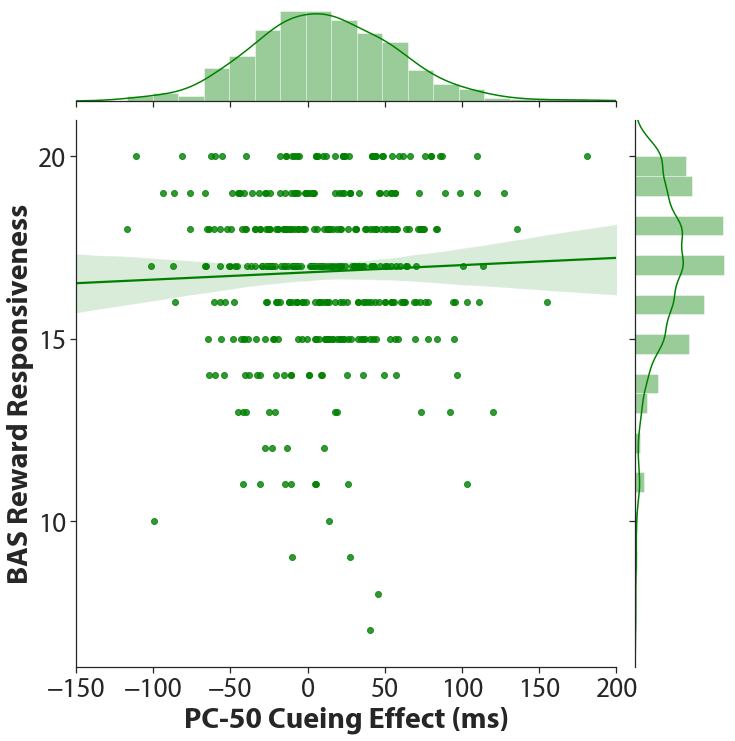

In [248]:
id_corr_graphs(SCT_RT_FB.RTs,bRR.RR,'BAS Reward Responsiveness','PC-50 Cueing Effect (ms)',"SCT_RT_RR_id.png", 1, overallRT_T.RT, -150, 200, 6, 21, 50, 5)

(LinregressResult(slope=0.004446373014246443, intercept=21.679618207363493, rvalue=0.05317900958502414, pvalue=0.2880830067147212, stderr=0.004179884074880126),
 LinregressResult(slope=2.9442031406607465, intercept=21.681374968254143, rvalue=0.05159044002826006, pvalue=0.30274760025823766, stderr=2.853207571657796))

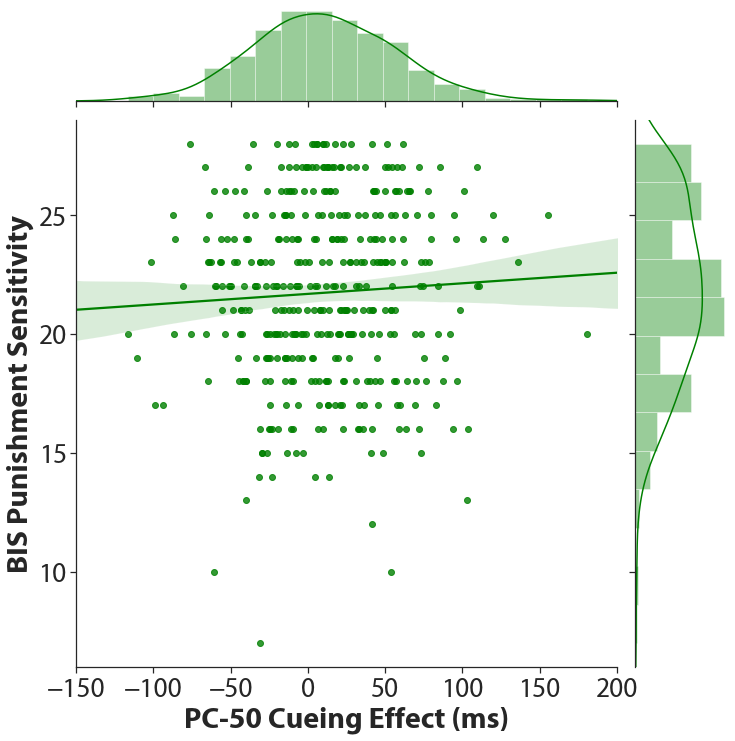

In [249]:
id_corr_graphs(SCT_RT_FB.RTs,bBIS.BIS,'BIS Punishment Sensitivity','PC-50 Cueing Effect (ms)',"SCT_RT_BIS_id.png", 1, overallRT_T.RT, -150, 200, 6, 29, 50, 5)

In [250]:
(min(SCT_ACC_FB.ACC)), (max(SCT_ACC_FB.ACC)), round(min(bRR.RR)), round(max(bRR.RR))

(-42.5, 47.5, 7, 20)

(LinregressResult(slope=-0.005386408138599193, intercept=16.85009517552563, rvalue=-0.03715301680776755, pvalue=0.458134434729478, stderr=0.007253018417220697),
 LinregressResult(slope=-0.43141079534120524, intercept=16.852214348230927, rvalue=-0.03983450922849687, pvalue=0.4263162628354371, stderr=0.541751658235356))

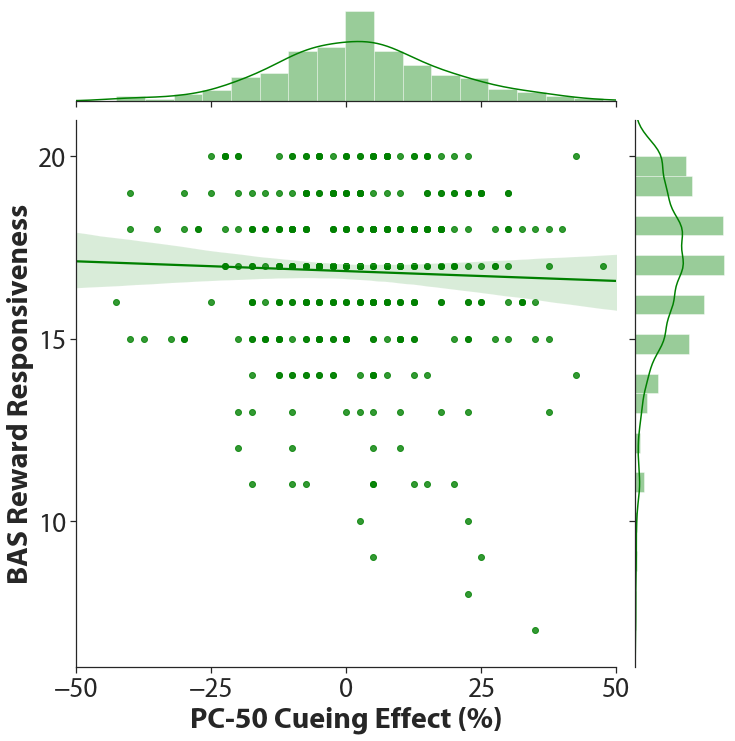

In [251]:
id_corr_graphs(SCT_ACC_FB.ACC,bRR.RR,'BAS Reward Responsiveness', 'PC-50 Cueing Effect (%)', "SCT_ACC_RR_id.png", 1, overallACC_T.Accuracy, -50, 50, 6, 21, 25, 5)

(LinregressResult(slope=-0.00026600339215335526, intercept=21.72878154134259, rvalue=-0.0010881308205321952, pvalue=0.9826698834350137, stderr=0.012238251065039223),
 LinregressResult(slope=-0.05028068185676179, intercept=21.729847269876256, rvalue=-0.0027533963432266537, pvalue=0.9561665839102751, stderr=0.914206559682853))

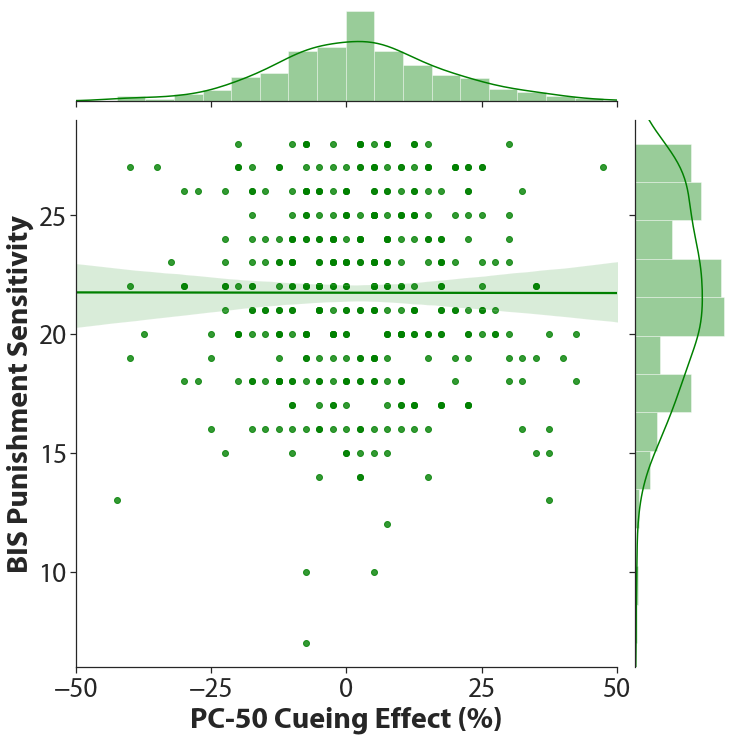

In [252]:
id_corr_graphs(SCT_ACC_FB.ACC,bBIS.BIS,'BIS Punishment Sensitivity', 'PC-50 Cueing Effect (%)', "SCT_ACC_BIS_id.png", 1, overallACC_T.Accuracy, -50, 50, 6, 29, 25, 5)

What about the biased PC-90/10 items?

In [253]:
round(min(SC_RT_FB.RTs)), round(max(SC_RT_FB.RTs)), round(min(bRR.RR)), round(max(bRR.RR))

(-188, 319, 7, 20)

(LinregressResult(slope=-0.001409631981693098, intercept=16.94283877539052, rvalue=-0.05193274930340433, pvalue=0.29954656302393873, stderr=0.0013570365420656498),
 LinregressResult(slope=-0.9096194573396289, intercept=16.942598966982878, rvalue=-0.05193710581359444, pvalue=0.2995059694704273, stderr=0.875606568249649))

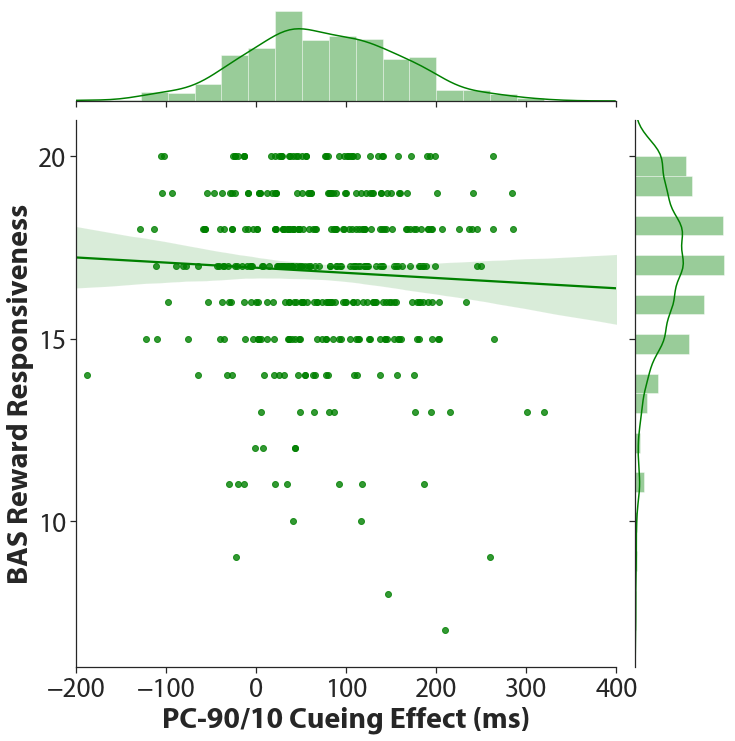

In [254]:
id_corr_graphs(SC_RT_FB.RTs,bRR.RR,'BAS Reward Responsiveness','PC-90/10 Cueing Effect (ms)',"SC_RT_RR_id.png", 1, overallMainRT.RT, -200, 400, 6, 21, 100, 5)

(LinregressResult(slope=-0.0007968775339533018, intercept=21.78749941649211, rvalue=-0.017411102151411766, pvalue=0.7281443609886177, stderr=0.0022909364087737344),
 LinregressResult(slope=-0.36002160002869404, intercept=21.769616664093444, rvalue=-0.012191177971563178, pvalue=0.8077148299108369, stderr=1.4783053977977245))

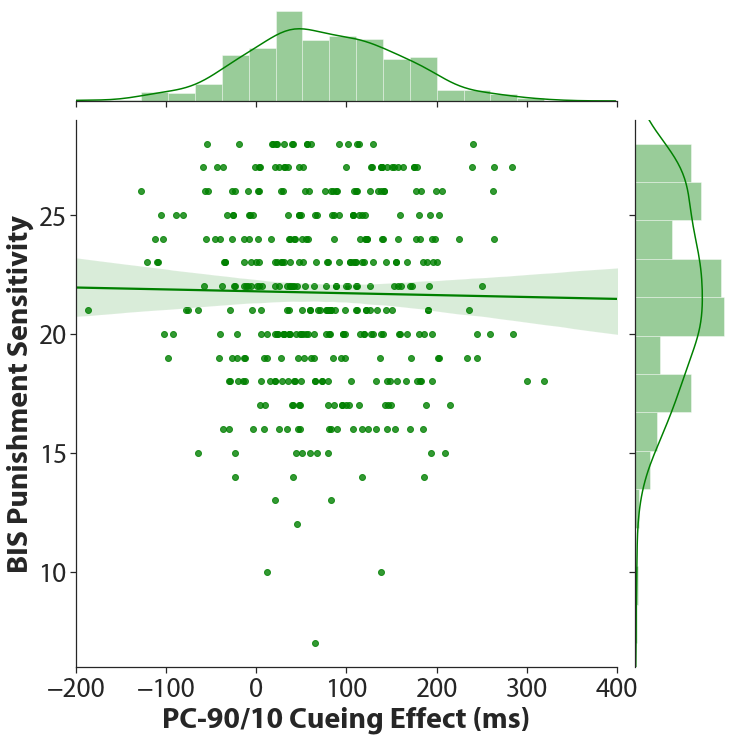

In [255]:
id_corr_graphs(SC_RT_FB.RTs,bBIS.BIS,'BIS Punishment Sensitivity','PC-90/10 Cueing Effect (ms)',"SC_RT_BIS_id.png", 1, overallMainRT.RT, -200, 400, 6, 29, 100, 5)

In [256]:
(min(SC_ACC_FB.ACC)), (max(SC_ACC_FB.ACC)), round(min(bRR.RR)), round(max(bRR.RR))

(-25.64402810304449, 92.97423887587821, 7, 20)

(LinregressResult(slope=-0.010904296625730333, intercept=17.056272012677894, rvalue=-0.10051570535581371, pvalue=0.04425797982046915, stderr=0.005403463214590753),
 LinregressResult(slope=-0.9150774006101957, intercept=17.05205915721272, rvalue=-0.09977640795704107, pvalue=0.045850284017356496, stderr=0.4568471414231881))

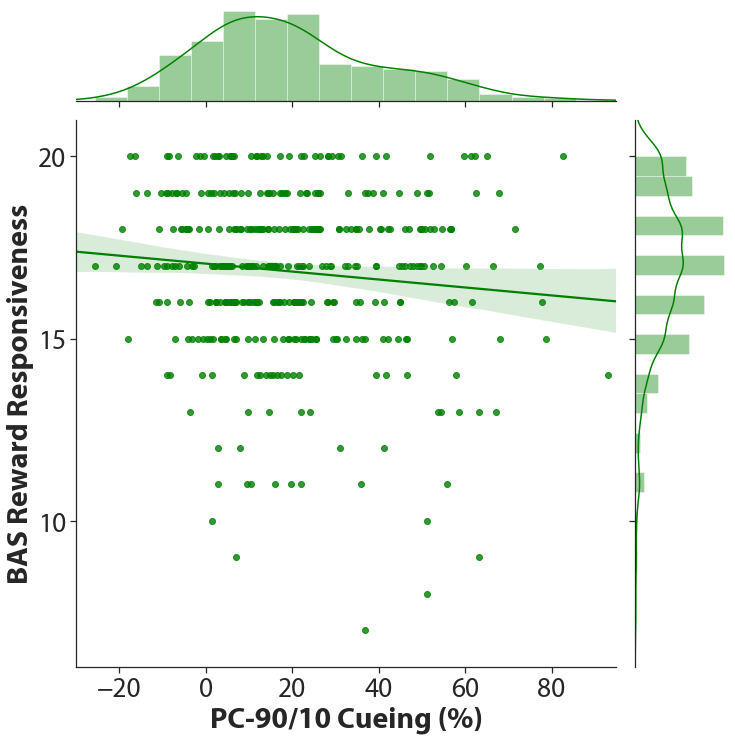

In [257]:
id_corr_graphs(SC_ACC_FB.ACC,bRR.RR,'BAS Reward Responsiveness', 'PC-90/10 Cueing (%)', "SC_ACC_RR_id.png", 1, overallMainACC.Accuracy, -30, 95, 6, 21, 20, 5)

(LinregressResult(slope=-0.013218191048615205, intercept=21.992883810357885, rvalue=-0.07226157157561572, pvalue=0.14862410135859563, stderr=0.009133585912092982),
 LinregressResult(slope=-1.0161914450742773, intercept=21.965997009621265, rvalue=-0.06571199912513152, pvalue=0.1891176913460197, stderr=0.7725110855637605))

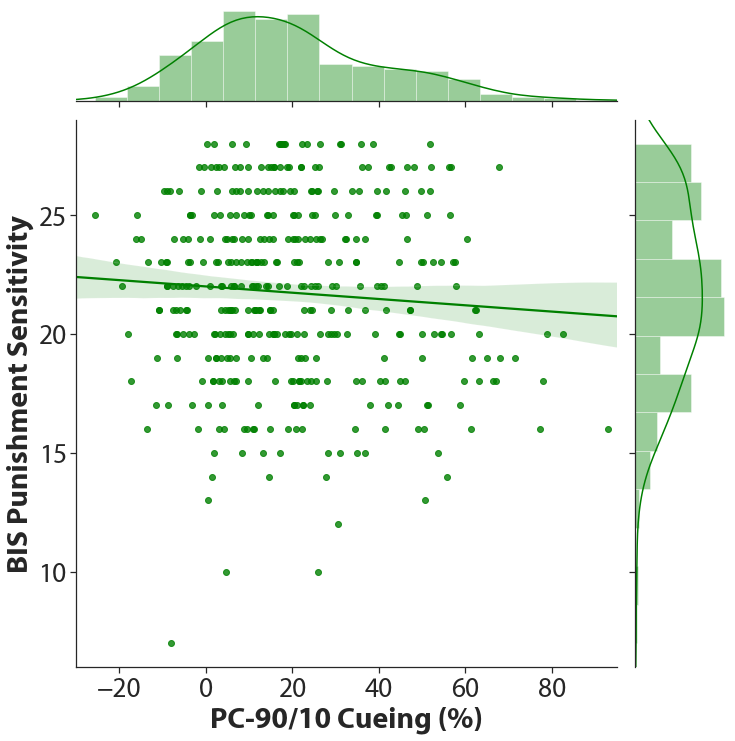

In [258]:
id_corr_graphs(SC_ACC_FB.ACC,bBIS.BIS,'BIS Punishment Sensitivity', 'PC-90/10 Cueing (%)', "SC_ACC_BIS_id.png", 1, overallMainACC.Accuracy, -30, 95, 6, 29, 20, 5)

To explore further how trait reward sensitivity might impact conflict-control, we subsequently reran the repeated-measures ANOVAs from the Learning Phase, adding the BAS reward responsiveness and BIS scores as separate covariates in the analysis.

To do this, I will need to add Reward Responsiveness and Punishment Sensitivity to my wide-form databases of RT and Accuracy and then convert those to long-form for the ANOVA analysis. Checking by hand whether or not the RR or BIS matches each person's score as listed here confirms this worked out OK.

I would also need to add block order to the RT and Accuracy wide-form dataframes, since those do not have the variable.

In [259]:
#432 is the number of data items for each person's learning phase data
res = [ele for ele in bRR.RR for i in range(432)]
bisR = [ele for ele in bBIS.BIS for i in range(432)]

In [260]:
#because sub 89 doesn't have a bis-bas score, have to eliminate from this analysis
acdat = adat.query('(RunCounter != 0) & (subject != 89)').copy()

In [261]:
bRR = bRR.drop(['index'],axis = 1)
bRR = bRR.reset_index()

bBIS = bBIS.drop(['index'],axis = 1)
bBIS = bBIS.reset_index()

In [262]:
acdat['RR'] = res
acdat['BIS'] = bisR
rdat = acdat.query('(TypeOfResponse != "SCRespITI") & (RT > 200) & (RT < 1000) & (Accuracy != 0) & (StimRep != 1)').copy()

In [263]:
RT_RR = rdat.loc[rdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR', 'Feedback'])['RT'].mean().reset_index();
ACC_RR = acdat.loc[acdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR', 'Feedback'])['Accuracy'].mean().reset_index();
RT_RR_T = rdat.loc[rdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR', 'Feedback'])['RT'].mean().reset_index();
ACC_RR_T = acdat.loc[acdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'RR', 'Feedback'])['Accuracy'].mean().reset_index();

RT_RR.to_csv(csvpath+'RT_RR.csv')
ACC_RR.to_csv(csvpath+'ACC_RR.csv')
RT_RR_T.to_csv(csvpath+'RT_RR_T.csv')
ACC_RR_T.to_csv(csvpath+'ACC_RR_T.csv')

RT_BIS = rdat.loc[rdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'BIS', 'Feedback'])['RT'].mean().reset_index();
ACC_BIS = acdat.loc[acdat['Item']!='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'BIS', 'Feedback'])['Accuracy'].mean().reset_index();
RT_BIS_T = rdat.loc[rdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'BIS', 'Feedback'])['RT'].mean().reset_index();
ACC_BIS_T = acdat.loc[acdat['Item']=='PC-50'].groupby(['subject', 'BlockType','Congruency', 'BlockOrder', 'BIS', 'Feedback'])['Accuracy'].mean().reset_index();

RT_BIS.to_csv(csvpath+'RT_BIS.csv')
ACC_BIS.to_csv(csvpath+'ACC_BIS.csv')
RT_BIS_T.to_csv(csvpath+'RT_BIS_T.csv')
ACC_BIS_T.to_csv(csvpath+'ACC_BIS_T.csv')

In [264]:
%cd "csvdata"

C:\Users\cb383\Dropbox\Projects\LWPCtufb\data\csvdata


In [265]:
%%writefile SCAnova_RR.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawRTData <- read.csv('RT_RR.csv')
rawRTData <- within(rawRTData, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "RT", rawRTData, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

#

rawRTData_T <- read.csv('RT_RR_T.csv')
rawRTData_T <- within(rawRTData_T, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "RT", rawRTData_T, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

#

rawACCData <- read.csv('ACC_RR.csv')
rawACCData <- within(rawACCData, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "Accuracy", rawACCData, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

#

rawACCData_T <- read.csv('ACC_RR_T.csv')
rawACCData_T <- within(rawACCData_T, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "Accuracy", rawACCData_T, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("RR"), observed = c("RR"), factorize = FALSE, anova_table=list(es = "pes"))

Overwriting SCAnova_RR.R


In [266]:
! Rscript SCAnova_RR.R

Anova Table (Type 3 tests)

Response: RT
                                     Effect     df      MSE          F    pes
1                                BlockOrder 1, 396 10692.12       0.05  .0001
2                                  Feedback 1, 396 10692.12     3.07 +   .008
3                                        RR 1, 396 10692.12       0.76   .002
4                       BlockOrder:Feedback 1, 396 10692.12       2.61   .007
5                                 BlockType 1, 396  2017.77     4.75 *    .01
6                      BlockOrder:BlockType 1, 396  2017.77 147.91 ***    .27
7                        Feedback:BlockType 1, 396  2017.77       1.83   .005
8                              RR:BlockType 1, 396  2017.77       0.83   .002
9             BlockOrder:Feedback:BlockType 1, 396  2017.77       0.29  .0007
10                               Congruency 1, 396  1611.68  15.78 ***    .04
11                    BlockOrder:Congruency 1, 396  1611.68  12.51 ***    .03
12                     

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback
Warning message:
Numerical variables NOT centered o

In [267]:
%%writefile SCAnova_BIS.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

RT_BIS <- read.csv('RT_BIS.csv')
RT_BIS <- within(RT_BIS, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "RT", RT_BIS, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("BIS"), observed = c("BIS"), factorize = FALSE, anova_table=list(es = "pes"))

#

RT_BIS_T <- read.csv('RT_BIS_T.csv')
RT_BIS_T <- within(RT_BIS_T, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "RT", RT_BIS_T, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("BIS"), observed = c("BIS"), factorize = FALSE, anova_table=list(es = "pes"))

#

ACC_BIS <- read.csv('ACC_BIS.csv')
ACC_BIS <- within(ACC_BIS, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "Accuracy", ACC_BIS, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("BIS"), observed = c("BIS"), factorize = FALSE, anova_table=list(es = "pes"))

#

ACC_BIS_T <- read.csv('ACC_BIS_T.csv')
ACC_BIS_T <- within(ACC_BIS_T, {subject <- factor(subject)
BlockOrder <- factor(BlockOrder)
Feedback <- factor(Feedback)})
aov_ez("subject", "Accuracy", ACC_BIS_T, within = c("BlockType", "Congruency"), between = c("BlockOrder", "Feedback"), covariate = c("BIS"), observed = c("BIS"), factorize = FALSE, anova_table=list(es = "pes"))

Overwriting SCAnova_BIS.R


In [268]:
! Rscript SCAnova_BIS.R

Anova Table (Type 3 tests)

Response: RT
                                     Effect     df      MSE          F    pes
1                                BlockOrder 1, 396 10580.03       0.14  .0004
2                                  Feedback 1, 396 10580.03     3.74 +   .009
3                                       BIS 1, 396 10580.03     4.96 *    .01
4                       BlockOrder:Feedback 1, 396 10580.03     3.06 +   .008
5                                 BlockType 1, 396  2021.87     3.28 +   .008
6                      BlockOrder:BlockType 1, 396  2021.87 146.38 ***    .27
7                        Feedback:BlockType 1, 396  2021.87       1.68   .004
8                             BIS:BlockType 1, 396  2021.87       0.03 <.0001
9             BlockOrder:Feedback:BlockType 1, 396  2021.87       0.31  .0008
10                               Congruency 1, 396  1570.35     6.31 *    .02
11                    BlockOrder:Congruency 1, 396  1570.35  14.09 ***    .03
12                     

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback
Warning message:
Numerical variables NOT centered o

In [269]:
#congruency
BISCong=RT_BIS_T.groupby(['subject','Congruency', 'BIS'])['RT'].mean().reset_index()
widedata = BISCong.pivot_table(index=["subject",'BIS'], columns=['Congruency'], values=['RT']).reset_index()

In [270]:
congdiff = widedata.RT.Incongruent - widedata.RT.Congruent
widedata['cong'] = congdiff

In [ ]:
stats.linregress(widedata.cong,widedata.BIS)

Neither trait reward sensitivity nor punishment sensitivity were significantly associated with the RT interaction effect between PC and congruency for unbiased items (Figure 4A&C, BAS: r(399) = 0.04, p = 0.424; corrected for overall RT: r(399) = 0.04, p = 0.393; BIS: r(399) = 0.05, p = 0.288; corrected for overall RT: r(399) = 0.05, p = 0.303). Nor were these measures correlated with the Accuracy LWPC effect (Figure 4B&D, BAS: r(399) = 0.04, p = 0.458; corrected for overall Accuracy: r(399) = 0.04, p = 0.426; BIS: r(399) = 0.00, p = 0.982; corrected for overall Accuracy: r(399) = 0.00, p = 0.956). 

To explore further how trait reward or punishment sensitivity might impact conflict-control, we subsequently reran the repeated-measures ANOVAs from the Learning Phase, adding the BAS reward responsiveness and BIS punishment sensitivity scores as a covariate in separate analyses. There was no significant main effect or interactions associated with trait reward sensitivity for either RT or accuracy. With respect to trait punishment sensitivity, we found a significant but weak interaction between BIS scores and congruency (F(1,396) = 4.74, p = 0.030, ηp2 = 0.01) on RT. Participants who had higher punishment sensitivity had larger congruency effects. No other effects or interactions associated with trait punishment sensitivity were significant.

In sum, trait reward and punishment sensitivity showed mostly nonsignificant associations with performance speed and accuracy. Overall, these analyses suggest that trait reward sensitivity and punishment sensitivity may only play a very small role in determining whether an individual learns control-demand associations, which in turn can be seen as discounting a motivational basis for driving learning in the current study.

So, let's look at now how explicitly aware participants were of the PC manipulation...

In [272]:
#from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '({v:d})'.format(v=val)
    return my_autopct

In [273]:
from numpy import std, mean, sqrt

#correct if the population S.D. is expected to be equal for the two groups.
#from: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

In [274]:
%cd ..

C:\Users\cb383\Dropbox\Projects\LWPCtufb\data


In [275]:
posttest = pd.read_csv('AllSubsPostTest.csv')

In [276]:
fcdf = adat.groupby(['subject','ItemType', 'WordPresented'])['LogCounter'].mean().reset_index()

In [277]:
accuracy = []
type2 = []
for i in range(0,len(fcdf)):
    temp = posttest[posttest.subject==fcdf.subject[i]].reset_index()
    targetRow = [j for j, quest in enumerate(temp['question']) if '_{}'.format(fcdf.WordPresented[i].lower()) in quest]

    if (fcdf.ItemType[i]==1) & ('easy' in temp.data[targetRow].iloc[0].lower()):
        accuracy.append(1)
    elif (fcdf.ItemType[i]==2) & ('hard' in temp.data[targetRow].iloc[0].lower()):
        accuracy.append(1)
    elif (fcdf.ItemType[i]==3) & ('neutral' in temp.data[targetRow].iloc[0].lower()):
        accuracy.append(1)
    else: accuracy.append(0)
        
    if (fcdf.ItemType[i]<=2):
        type2.append(1)
    else: type2.append(2)

fcdf['Accuracy'] = accuracy
fcdf['ItemTypeRecoded'] = type2

In [278]:
results_final = fcdf.groupby(['subject','ItemTypeRecoded']).agg(
    {'Accuracy':['sum']}
).reset_index()

results_all = fcdf.groupby(['subject']).agg(
    {'Accuracy':['sum']}
).reset_index()

In [279]:
BlockVary = posttest.loc[posttest['question'] == 'BlockVaryQ'].data.reset_index().astype(float)
ItemVary = posttest.loc[posttest['question'] == 'ItemVaryQ'].data.reset_index().astype(float)

#### We assessed explicit awareness of the underlying task structures by asking participants whether they noticed any systematic variation in the image/Stroop trial sequences at the item and block level.

In [280]:
def mypiegraph(BlockorItem, title, figname):
    fig, ax1 = plt.subplots(figsize=(8, 7));
    if BlockorItem == 0:
        Q1 = [pd.Series.sum(ItemVary.data), len(ItemVary.data) - pd.Series.sum(ItemVary.data)];
    elif BlockorItem == 1:
        Q1 = [pd.Series.sum(BlockVary.data), len(BlockVary.data) - pd.Series.sum(BlockVary.data)];
    Q1labels = ['Yes','No'];
    plt.axis('equal');
    startanglept=90;
    radiussize=0.65;
    legendfontsize=15;
    titlefontsize=17;
    
    patches, texts, junk = ax1.pie(Q1, startangle=startanglept, radius=radiussize, autopct=make_autopct(Q1));
    ax1.legend(patches, Q1labels, loc='lower center', fontsize=legendfontsize, frameon=False);
    my_circle=plt.Circle( (0,0), 0.2, color='white');
    p=plt.gcf();
    p.gca().add_artist(my_circle) ;
    fig.suptitle(title, fontsize=titlefontsize,fontweight="bold", y = 0.85);
    plb.savefig(figurepath+figname, bbox_inches='tight');

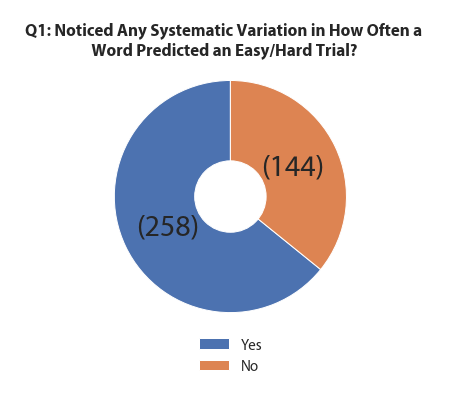

In [281]:
mypiegraph(0, 'Q1: Noticed Any Systematic Variation in How Often a\n Word Predicted an Easy/Hard Trial?', "posttestQ1_Item.png")

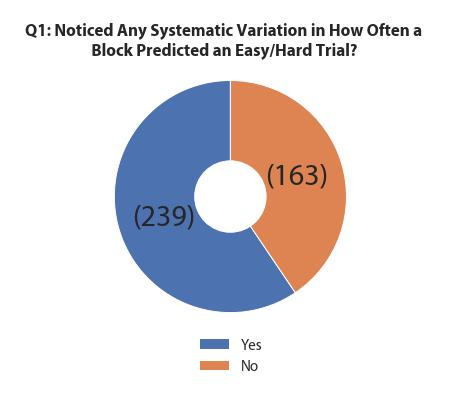

In [282]:
mypiegraph(1, 'Q1: Noticed Any Systematic Variation in How Often a\n Block Predicted an Easy/Hard Trial?', "posttestQ1_Block.png")

In [283]:
fbBlock = posttest.loc[posttest['question'] == 'BlockVaryQ'].loc[posttest['Feedback'] == 'fb'].data.reset_index().astype(float)
print("Number of FB people who reported yes on LWPC block " + str(pd.Series.sum(fbBlock.data)))

nofbBlock = posttest.loc[posttest['question'] == 'BlockVaryQ'].loc[posttest['Feedback'] == 'nofb'].data.reset_index().astype(float)
print("Number of noFB people who reported yes on LWPC block " + str(pd.Series.sum(nofbBlock.data)))

fbItem = posttest.loc[posttest['question'] == 'ItemVaryQ'].loc[posttest['Feedback'] == 'fb'].data.reset_index().astype(float)
print("Number of FB people who reported yes on LWPC word " + str(pd.Series.sum(fbItem.data)))

nofbItem = posttest.loc[posttest['question'] == 'ItemVaryQ'].loc[posttest['Feedback'] == 'nofb'].data.reset_index().astype(float)
print("Number of noFB people who reported yes on LWPC word " + str(pd.Series.sum(nofbItem.data)))

Number of FB people who reported yes on LWPC block 117.0
Number of noFB people who reported yes on LWPC block 122.0
Number of FB people who reported yes on LWPC word 124.0
Number of noFB people who reported yes on LWPC word 134.0


#### Next, we asked participants to rate how likely certain color-words would together predict the frequency of easy/congruent and hard/incongruent trials on a scale from 0 (never) to 100 (always). 

For instance, were red and orange paired together? Red and yellow? Red and green?

Were any of the color-word pairings rated as more predictive or nonpredictive than chance (50%)?

In [284]:
FP1 = posttest.loc[posttest['question'] == 'FreqPredict_1'].data.reset_index().dropna().astype(float)
FP2 = posttest.loc[posttest['question'] == 'FreqPredict_2'].data.reset_index().dropna().astype(float)
FP3 = posttest.loc[posttest['question'] == 'FreqPredict_3'].data.reset_index().dropna().astype(float)
FP4 = posttest.loc[posttest['question'] == 'FreqPredict_4'].data.reset_index().dropna().astype(float)
FP5 = posttest.loc[posttest['question'] == 'FreqPredict_5'].data.reset_index().dropna().astype(float)

In [285]:
ttest = stats.ttest_1samp(FP1.data,50)
cohens_dz = ttest[0] / sqrt(len(FP1.data))
ttest, len(FP1.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-4.309719520615882, pvalue=2.059105953261821e-05),
 401,
 -0.21494927289098273)

In [286]:
ttest = stats.ttest_1samp(FP2.data,50)
cohens_dz = ttest[0] / sqrt(len(FP2.data))
ttest, len(FP2.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-5.409226681243993, pvalue=1.0903809355787105e-07),
 401,
 -0.26978770578316946)

In [287]:
ttest = stats.ttest_1samp(FP3.data,50)
cohens_dz = ttest[0] / sqrt(len(FP3.data))
ttest, len(FP3.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-5.4053832602608045, pvalue=1.1123979609732755e-07),
 401,
 -0.2695960133675034)

In [288]:
ttest = stats.ttest_1samp(FP4.data,50)
cohens_dz = ttest[0] / sqrt(len(FP4.data))
ttest, len(FP4.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-2.230182365421632, pvalue=0.026288117515141755),
 401,
 -0.11123138653653412)

In [289]:
ttest = stats.ttest_1samp(FP5.data,50)
cohens_dz = ttest[0] / sqrt(len(FP5.data))
ttest, len(FP5.data) - 1, cohens_dz

(Ttest_1sampResult(statistic=-4.293154912379686, pvalue=2.2116280830836016e-05),
 401,
 -0.21412310532275416)

Because the color-word to PC assignment was randomized across participants, we wouldn't expect these to be more predictive than chance.

In [290]:
GRP_BT = FP1.groupby(['index'])['data'].mean() #1 is red + orange
GRP_BTSEM = pd.Series.std(GRP_BT.dropna()) / sqrt(len(GRP_BT.dropna()))
GRP_BB = FP2.groupby(['index'])['data'].mean() #2 is red + yellow
GRP_BBSEM = pd.Series.std(GRP_BB.dropna()) / sqrt(len(GRP_BB.dropna()))
GRP_BD = FP3.groupby(['index'])['data'].mean() #3 is red + green
GRP_BDSEM = pd.Series.std(GRP_BD.dropna()) / sqrt(len(GRP_BD.dropna()))
GRP_BD2 = FP4.groupby(['index'])['data'].mean() #4 is red + blue
GRP_BD2SEM = pd.Series.std(GRP_BD2.dropna()) / sqrt(len(GRP_BD2.dropna()))
GRP_BC = FP5.groupby(['index'])['data'].mean() #5 is red + purple
GRP_BCSEM = pd.Series.std(GRP_BC.dropna()) / sqrt(len(GRP_BC.dropna()))

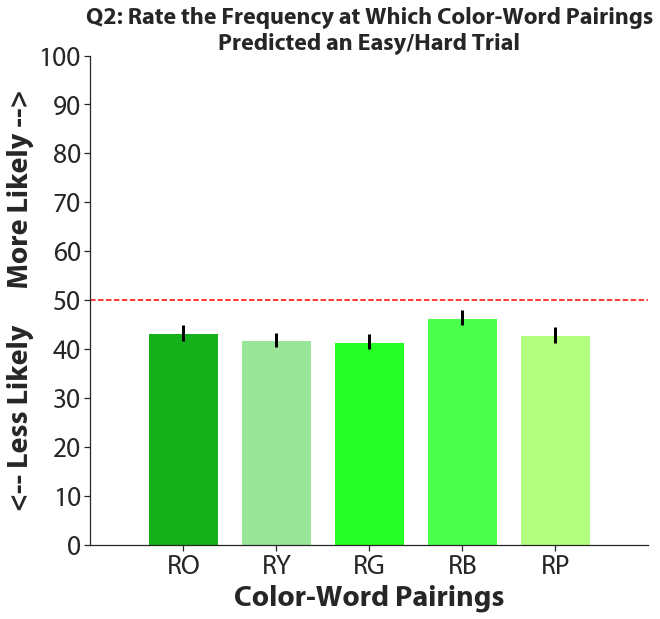

In [291]:
barwidth = 0.75; 
fig, ax = plt.subplots(figsize=(10, 9));
plt.plot([0,1,2,3,4,5,6],[50,50,50,50,50,50,50], 'r--');
rects1 = ax.bar(1,GRP_BT.dropna().mean(),barwidth,color=sns.xkcd_rgb['green'],yerr=GRP_BTSEM,ecolor='k',error_kw=dict(lw=3));
rects2 = ax.bar(2,GRP_BB.dropna().mean(),barwidth,color=(0.6,0.9,0.6),yerr=GRP_BBSEM,ecolor='k',error_kw=dict(lw=3));
rects3 = ax.bar(3,GRP_BD.dropna().mean(),barwidth,color=(0.15,1,0.15),yerr=GRP_BDSEM,ecolor='k',error_kw=dict(lw=3));
rects4 = ax.bar(4,GRP_BD2.dropna().mean(),barwidth,color=(0.3,1,0.3),yerr=GRP_BD2SEM,ecolor='k',error_kw=dict(lw=3));
rects5 = ax.bar(5,GRP_BC.dropna().mean(),barwidth,color=(0.7,1,0.5),yerr=GRP_BCSEM,ecolor='k',error_kw=dict(lw=3));
ax.set_ylim(0,100);
ax.set_xlim(0,6);
ax.set_xticklabels(('RO','RY','RG','RB','RP'));
ax.set_xticks([1, 2, 3, 4, 5]);
ax.set_yticks(np.arange(0, 101, 10));
plt.title('Q2: Rate the Frequency at Which Color-Word Pairings\nPredicted an Easy/Hard Trial', fontsize=24,fontweight="bold");
plt.ylabel('<-- Less Likely      More Likely -->', fontweight="bold");
plt.xlabel('Color-Word Pairings',fontweight="bold");
sns.despine();

plb.savefig(figurepath+"posttestQ2.png", bbox_inches='tight');

#### Participants were then asked to match the color-words to the Stroop trial type that they most likely preceded. Did they perform better than chance (i.e., 2/6 cue-demand relationships correctly matched)? Chance here is 2/6 correct because the options were hard/incongruent, easy/congruent, and neutral; we put both the biased and unbiased items together in the SCForcedChoice question.

##### Note that we also separate out the biased images post-test question (testing against chance then as 4/3) and the unbiased images post-test question (testing against chance as 2/3).

In [292]:
ttest = stats.ttest_1samp(results_all.Accuracy,2)
cohens_dz = ttest[0] / sqrt(len(results_all.Accuracy))
ttest, len(results_all.Accuracy) - 1, cohens_dz, np.mean(results_all.Accuracy)

(Ttest_1sampResult(statistic=array([12.0992639]), pvalue=array([6.09764858e-29])),
 401,
 array([0.60345643]),
 sum    3.079602
 dtype: float64)

In [293]:
fbgrp = np.resize('fb',404)
nofbgrp = np.resize('nofb',400)

group = np.append(fbgrp,nofbgrp)
results_final['group'] = group

In [294]:
ttest = stats.ttest_1samp(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy,(4/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy))
ttest, len(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['ItemTypeRecoded']==1].Accuracy)

(Ttest_1sampResult(statistic=array([16.01389641]), pvalue=array([5.65598649e-45])),
 401,
 array([0.79870056]),
 sum    2.393035
 dtype: float64)

In [295]:
#contingent feedback group
ttest = stats.ttest_1samp(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==1].Accuracy,(4/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==1].Accuracy))
ttest, len(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==1].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==1].Accuracy)

(Ttest_1sampResult(statistic=array([11.98840427]), pvalue=array([2.46843691e-25])),
 201,
 array([0.84350118]),
 sum    2.475248
 dtype: float64)

In [296]:
#non-contingent feedback group
ttest = stats.ttest_1samp(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==1].Accuracy,(4/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==1].Accuracy))
ttest, len(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==1].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==1].Accuracy)

(Ttest_1sampResult(statistic=array([10.64898338]), pvalue=array([3.02217579e-21])),
 199,
 array([0.75299684]),
 sum    2.31
 dtype: float64)

In [297]:
ttest = stats.ttest_1samp(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy,(2/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy))
ttest, len(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['ItemTypeRecoded']==2].Accuracy)

(Ttest_1sampResult(statistic=array([0.49314918]), pvalue=array([0.62217713])),
 401,
 array([0.02459605]),
 sum    0.686567
 dtype: float64)

In [298]:
#contingent feedback group
ttest = stats.ttest_1samp(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==2].Accuracy,(2/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==2].Accuracy))
ttest, len(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==2].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['group']=='fb'].loc[results_final['ItemTypeRecoded']==2].Accuracy)

(Ttest_1sampResult(statistic=array([-0.41747413]), pvalue=array([0.67677722])),
 201,
 array([-0.02937338]),
 sum    0.643564
 dtype: float64)

In [299]:
#non-contingent feedback group
ttest = stats.ttest_1samp(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==2].Accuracy,(2/3))
cohens_dz = ttest[0] / sqrt(len(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==2].Accuracy))
ttest, len(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==2].Accuracy) - 1, cohens_dz, np.mean(results_final.loc[results_final['group']=='nofb'].loc[results_final['ItemTypeRecoded']==2].Accuracy)

(Ttest_1sampResult(statistic=array([1.07782663]), pvalue=array([0.28241592])),
 199,
 array([0.07621385]),
 sum    0.73
 dtype: float64)

That the overall grouping is significant and the biased grouping significant, but not the unbiased, suggests that the increased PC from the biased grouping is what drives the increased recognition. This is consistent with Blais et al. (2012) suggesting that the more extreme the PC manipulation, the more explicitly aware participants are of the manipulation.

# Memory Data Analysis

`TypeofResponse` is similar to what it was in the Learning Phase: `MemRespITI` means the participant didn't respond within the 2 second deadline to identify whether the image was old or new.

`Version` is the variable from the Learning Phase. `LogCounter`, `TrialCounter`, and `MatrixCounter` serve the same purpose as they did in the Learning Phase.

`RunCounter`: here there were 2 runs, with half the images shown in one block and the other half in the other block. New and Old images were intermixed in both blocks equally.

`ImagePresented` indicates which image was shown, which is important to linking with the Learning Phase data.

`Memorymatrix` is 1 when it's a new image and 2 when it's an old image.

`keyPressed` is what participants presesed. a/A represented Old (previously seen), and l/L represented New (never seen).

`RT` is how fast they identified the image as Old or New.

`Hit` is an old image identified as Old.

`FA` is a new image identified as Old.

`CR` is a new image identified as New.

`Miss` is an old image identified as New.

`subject` self-explanatory. `population` is the same as in the Learning Phase data - 1 for MTurk workers and 2 for undergraduate students.

In [300]:
Memorydat = pd.read_csv('AllSubsMemory.csv')
mdat = Memorydat.copy()

In [301]:
#sub 186 has no memory data, memorymatrix = 2 means the old data
LPdata = adat.query('(subject != 186)').copy()
Memdata = mdat.query('(Memorymatrix == 2 & subject != 186)').copy()

LPdata = LPdata.reset_index()
LPdata = LPdata.drop(columns=['index'])
Memdata = Memdata.reset_index()
Memdata = Memdata.drop(columns=['index'])

In [302]:
LPdata = LPdata.rename(columns={"Version":"LPVersion", "TypeOfResponse":"LPTypeOfResponse", "LogCounter":"LPLogCounter","TrialCounter":"LPTrialCounter", "MatrixCounter":"LPMatrixCounter", "RunCounter":"LPRunCounter", "subject": "LPsubject", "ImagePresented":"LPImages", "population": "LPpop", "RT": "LPRT", "Feedback": "LPgrp"})

In [303]:
Memorydata = pd.merge(Memdata,LPdata,left_on=['ImagePresented', 'subject'],right_on=['LPImages', 'LPsubject'])

In [304]:
Memorydata.to_csv('Memorydata.csv');

Exclude memory trials without a response, with a cognitively fast response (RT < 200).

In [305]:
mdat_old_all = mdat.query('(TypeOfResponse != "MemRespITI") & (RT > 200) & (Memorymatrix == 2)').copy()
mdat_new_all = mdat.query('(TypeOfResponse != "MemRespITI") & (RT > 200) & (Memorymatrix == 1)').copy()

In [306]:
oldrate_all = mdat_old_all.groupby(['subject'])['Hit'].mean().reset_index();
newrate_all = mdat_new_all.groupby(['subject'])['FA'].mean().reset_index();

In [307]:
oldrate_all.Hit.mean()
newrate_all.FA.mean()

0.3619773972253595

0.2775306422305947

In [308]:
oldrate_all = oldrate_all.loc[oldrate_all['subject'] != 375].reset_index()

In [309]:
ttest = stats.ttest_rel(oldrate_all.Hit, newrate_all.FA)
cohens_dz = ttest[0] / sqrt(len(newrate_all.FA))
ttest,len(newrate_all.FA) - 1, cohens_dz

(Ttest_relResult(statistic=19.694572428435855, pvalue=8.211960820739765e-61),
 399,
 0.9847286214217927)

subject 63 had a 0 false alarm rate, so replaced with:

"Adjust only the extreme values by replacing rates of 0 with 0.5/n and rates of 1 with (n−0.5)/n where n is the number of signal or noise trials (Macmillan & Kaplan, 1985)"

In [310]:
oldrate_all = oldrate_all.replace(to_replace=1, value = (len(oldrate_all.Hit)-0.5)/(len(oldrate_all.Hit)))
oldrate_all = oldrate_all.replace(to_replace=0, value = 0.5/(len(oldrate_all.Hit)))

In [311]:
newrate_all = newrate_all.replace(to_replace=1, value = (len(newrate_all.FA)-0.5)/(len(newrate_all.FA)))
newrate_all = newrate_all.replace(to_replace=0, value = 0.5/(len(newrate_all.FA)))

In [312]:
from scipy.stats import norm
import math
Z = norm.ppf
dprime = Z(oldrate_all.Hit) - Z(newrate_all.FA)

In [313]:
dprime.mean()

0.3056146106778379

In [314]:
dprime = pd.DataFrame({'dprime': dprime})
dprime = dprime.reset_index()

Now make sure to exclude incorrect trials.

All subsequent analyses focus on memory performance as a function of Learning Phase factors. Because we were interested in understanding how intrinsic reinforcement shapes learned control associations, we examined only the trials on which participants had responded correctly. Memory would otherwise potentially be confounded by the type of feedback reinforcement received on a given trial (correct vs. incorrect vs. response logged).

In [315]:
#memory data is already filtered to only old images
mdat3 = Memorydata.query('(TypeOfResponse != "MemRespITI") & (RT > 200) & (Accuracy == 1) & (LPRT > 200)').copy()

In analyzing incidental memory of reinforcement events, we combined data across biased and unbiased items. The list-wise context, which is created by the biased items, induces the learned recruitment of control-demand for unbiased items (as supported by the correlation analysis, above). Reinforcement following the biased items serves to reinforce the induced list-wise context, and reinforcement following the unbiased items serves to reinforce the generalization of the control-demand associations. Thus, in understanding how reinforcement shapes control-learning, we collapse across both metrics of control-learning.

In [316]:
%cd csvdata

C:\Users\cb383\Dropbox\Projects\LWPCtufb\data\csvdata


In [317]:
countexcl = mdat3.groupby(['subject','BlockType','Congruency','BlockOrder','Feedback'])['Hit'].count().reset_index()

Will catch anyone with <10 observations in the cells. If the groupby fxn has summarized and the participant has NA cells, then the ANOVA will just exclude them from the analysis anyway.

In [318]:
exclhit = [];
for i in range(0,len(countexcl)):
    sub = countexcl.Hit.reset_index()
    
    if (sub.Hit[i] < 10):
        exclhit.append(1)
    else: exclhit.append(0)
        
countexcl['exclhit'] = exclhit

In [319]:
HitcountComb = (countexcl[countexcl.exclhit == 1].subject).reset_index()

In [320]:
Hit_AnovaComb = mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].loc[mdat3['subject'] != 40].groupby(['subject','BlockType','Congruency','BlockOrder','Feedback'])['Hit'].mean().reset_index()
Hit_AnovaComb.to_csv(csvpath+'Hit_AnovaComb.csv')

In [321]:
%%writefile HitAnovaComb.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawHitdata <- read.csv('Hit_AnovaComb.csv')
aov_car(Hit ~ BlockOrder*Feedback + Error(subject/(BlockType*Congruency)), data = rawHitdata, anova_table = list(es = "pes"))

Overwriting HitAnovaComb.R


In [322]:
! Rscript HitAnovaComb.R

Anova Table (Type 3 tests)

Response: Hit
                                     Effect     df  MSE         F    pes
1                                BlockOrder 1, 379 0.12      0.00 <.0001
2                                  Feedback 1, 379 0.12      0.46   .001
3                       BlockOrder:Feedback 1, 379 0.12      0.54   .001
4                                 BlockType 1, 379 0.01      0.21  .0006
5                      BlockOrder:BlockType 1, 379 0.01 40.40 ***    .10
6                        Feedback:BlockType 1, 379 0.01      0.01 <.0001
7             BlockOrder:Feedback:BlockType 1, 379 0.01      0.31  .0008
8                                Congruency 1, 379 0.00    4.72 *    .01
9                     BlockOrder:Congruency 1, 379 0.00      0.04  .0001
10                      Feedback:Congruency 1, 379 0.00      0.06  .0002
11           BlockOrder:Feedback:Congruency 1, 379 0.00      0.23  .0006
12                     BlockType:Congruency 1, 379 0.00      0.66   .002
13       

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback


We ran a repeated-measures ANOVA on Hit Rates for feedback images across the entire dataset, probing how sensitivity to feedback and reinforcement varied as a function of the experimental factors within the Learning Phase. 

We found a significant interaction between block order and PC context for memory of feedback images (Figure 6A; N = 383, F(1,379) = 40.40, p < 0.001, ηp2 = 0.10, inclusion BF = 5.97 x 1015). Participants who experienced the mostly congruent context first displayed a stronger context-dependent effect on memory: they better remembered images from the PC-75 context (Mdiff = 0.044), while participants who experienced the mostly incongruent context first had a smaller tendency for better memory from the PC-25 context (Mdiff = 0.034). Finally, this interaction was also moderated by congruency in frequentist but not Bayesian analysis (F(1,379) = 8.38, p = 0.004, ηp2 = 0.02, inclusion BF = 0.47). There was also a significant main effect of congruency with minimal Bayesian evidence (F(1,379) = 4.72, p = 0.030, ηp2 = 0.01, inclusion BF = 0.21). These effects are explored in more depth with analyses below. No other effects were significant (F < 2.20, BFs < 1). 

These context-dependent memory effects indicate that participants generally had better memory for feedback from context-defining trials, i.e., congruent trials in mostly congruent blocks, and incongruent trials in mostly incongruent blocks, qualified by block order and PC context: participants generally remembered images better from the (frequent) trials that defined the first context they experienced, but this effect was more pronounced for participants whose first context was mostly congruent. Interestingly, we did not observe an effect of feedback group on memory data, suggesting that any motivational effect derived from receiving performance-contingent feedback did not affect attention to reinforcementfeedback events. This pattern of memory data is compatible with the statistical learning perspective, whereby participants would be particularly sensitive to positive reinforcement of their current expectations (e.g., encountering a congruent trial in a mostly congruent context), as evident in sensitivity to context-defining images. By contrast, we do not find evidence for effects of motivation in the shape of explicit performance feedback, which is in line with the lack of evidence for the impact of individual differences of reward and punishment sensitivity on learning obtained in the correlation analyses above. 

In [323]:
def mem_plot(x,xlabel,hue,huetitle,data, title, imagetitle, dv, dvlabel, ymin, ymax, stepsize):
    g = sns.catplot(x=x, y=dv, hue=hue,data=data,palette=("Set2"),ci=68,kind="point",height=10, aspect=0.7,saturation=1,legend_out = True);
    g.set_axis_labels(xlabel, dvlabel);
    g.despine(left=True);

    # check axes and find which have legends
    for ax in g.axes.flat:
        leg = g.axes.flat[0].get_legend()
        if not leg is None: 
            break

    # or legend may be on a figure
    if leg is None: 
        leg = g._legend

    leg.set_title(huetitle);
    g.set(ylim=(ymin, ymax), yticks=np.arange(ymin,ymax+stepsize,stepsize))
    g.fig.suptitle(title, y = 1.05)

    plb.savefig(figurepath+imagetitle, dpi=300, bbox_inches='tight')

In [324]:
HitANOVA_graph = mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].loc[mdat3['subject'] != 40].groupby(['subject','BlockType','BlockOrder'])['Hit'].mean().reset_index()

In [325]:
MCtrials = HitANOVA_graph.loc[HitANOVA_graph['BlockOrder']=='MCfirst'].reset_index()
MICtrials = HitANOVA_graph.loc[HitANOVA_graph['BlockOrder']=='MICfirst'].reset_index()

np.random.seed(321)
xj = np.random.normal(0, 0.03, len(MCtrials.subject))
xj_2 = np.random.normal(1, 0.03, len(MICtrials.subject))

MC25 = MCtrials.loc[MCtrials['BlockType']=='PC-25'].reset_index()
MC25['xj'] = np.random.normal(0, 0.03, len(MC25.subject));
MC75 = MCtrials.loc[MCtrials['BlockType']=='PC-75'].reset_index()
MC75['xj'] = np.random.normal(1, 0.03, len(MC75.subject));
MIC25 = MICtrials.loc[MICtrials['BlockType']=='PC-25'].reset_index()
MIC25['xj'] = np.random.normal(0, 0.03, len(MIC25.subject));
MIC75 = MICtrials.loc[MICtrials['BlockType']=='PC-75'].reset_index()
MIC75['xj'] = np.random.normal(1, 0.03, len(MIC75.subject));
#MICtrials['xj'] = xj_2;

MCtot = MC25.append(MC75);
MICtot = MIC25.append(MIC75);

MCmean = MCtrials.Hit.mean()
MICmean = MICtrials.Hit.mean()
MCstd = MCtrials.Hit.std()
MICstd = MICtrials.Hit.std()
MCse = MCstd/np.sqrt(len(MCtrials))
MICse = MICstd/np.sqrt(len(MICtrials))

combineddf = MCtrials.append(MICtrials)

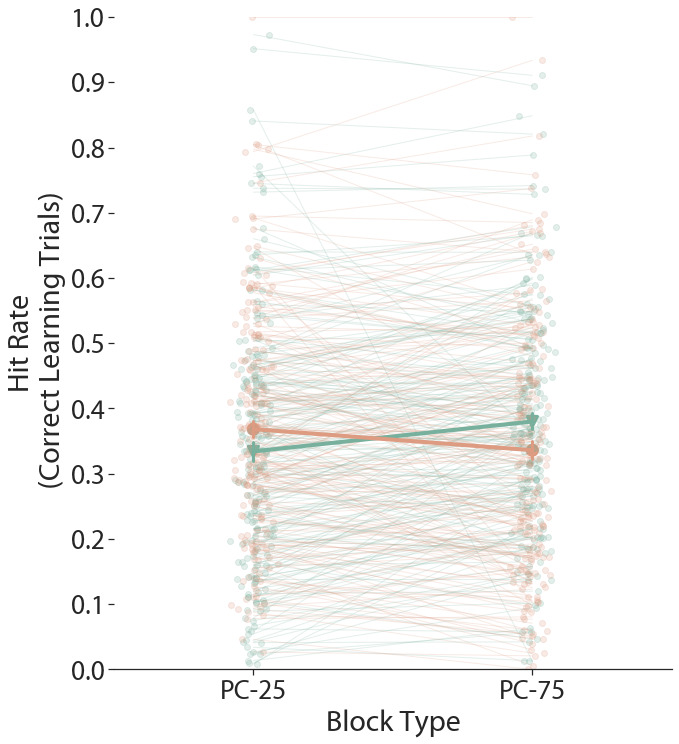

In [326]:
fig, ax = plt.subplots(figsize=(10, 12));
plt.plot(MCtot.xj,MCtot.Hit,'o', color='#78b09e', alpha=0.2);
plt.plot(MICtot.xj,MICtot.Hit,'o', color='#dd9b81', alpha=0.2);
sns.lineplot(x="BlockType" , y="Hit", units="subject", data=MCtrials,color='#78b09e', alpha=0.2, estimator=None,lw=1,ax=ax);
sns.lineplot(x="BlockType" , y="Hit", units="subject", data=MICtrials,color='#dd9b81', alpha=0.2, estimator=None,lw=1,ax=ax);
sns.pointplot(data=MCtrials,x="BlockType", y="Hit", order=["PC-25","PC-75"], markers=["v","v"],color="#78b09e", ci=68,errwidth=3,scale=1.5);
sns.pointplot(data=MICtrials,x="BlockType", y="Hit", order=["PC-25","PC-75"], markers=["o","o"], color="#dd9b81", ci=68,errwidth=3,scale=1.5);
ax.set_ylim(0,1.0);
ax.set_xlim(-0.5,1.50);
ax.set_xticklabels(('PC-25','PC-75'));
ax.set_xticks([0, 1]);
ax.set_yticks(np.arange(0, 1.1, 0.1));
plt.ylabel('Hit Rate\n (Correct Learning Trials)');
plt.xlabel('Block Type');
sns.despine(ax=ax, left=True);

plb.savefig(figurepath+'HitBOBT_all.png', dpi=300, bbox_inches='tight');

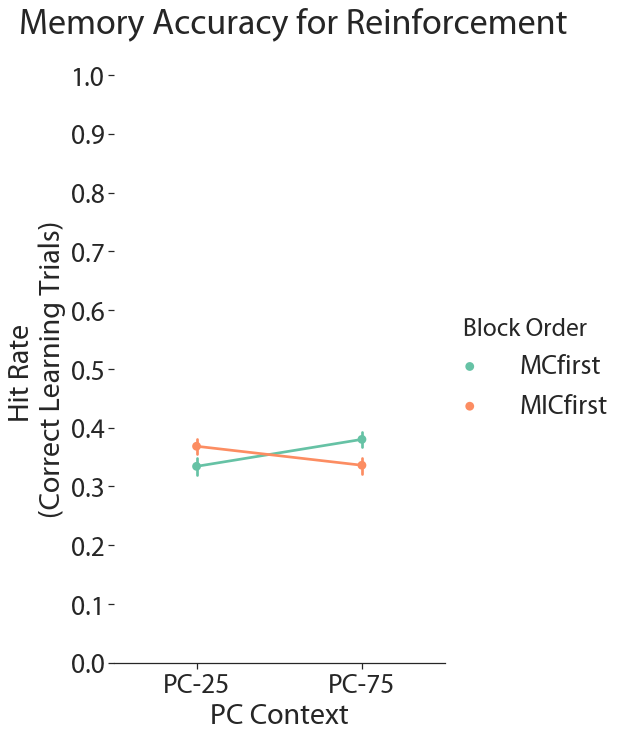

In [327]:
mem_plot('BlockType','PC Context', 'BlockOrder', 'Block Order', HitANOVA_graph,"Memory Accuracy for Reinforcement", "Hit_ANOVA.png", "Hit", "Hit Rate \n(Correct Learning Trials)", 0, 1.0, 0.1)

Means for the ANOVA in the manuscript

In [328]:
#congruency
maineffectCong=mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].loc[mdat3['subject'] != 40].groupby(['subject','Congruency'])['Hit'].mean()
grpmean = pd.Series.mean(maineffectCong, level=1)
(grpmean), grpmean[1] - grpmean[0]

#block order x PC
BOPC=mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].loc[mdat3['subject'] != 40].groupby(['subject','BlockOrder', 'BlockType'])['Hit'].mean().reset_index()
PC75_CFminusIF = BOPC.loc[BOPC['BlockType'] == 'PC-75'].loc[BOPC['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - BOPC.loc[BOPC['BlockType'] == 'PC-75'].loc[BOPC['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
PC25_CFminusIF = BOPC.loc[BOPC['BlockType'] == 'PC-25'].loc[BOPC['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - BOPC.loc[BOPC['BlockType'] == 'PC-25'].loc[BOPC['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
(PC75_CFminusIF.mean()), (PC25_CFminusIF.mean())

#congruency x block type x block order
PopBO=mdat3.loc[~mdat3['subject'].isin(HitcountComb.subject)].loc[mdat3['subject'] != 40].groupby(['subject','BlockType', 'Congruency', 'BlockOrder'])['Hit'].mean().reset_index()
MC_Cong_CF = PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'MCfirst'].reset_index()['Hit']
MC_Cong_IF = PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'MICfirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-75'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
MIC_Cong_CF = PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'MCfirst'].reset_index()['Hit']
MIC_Cong_IF = PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Incongruent'].loc[PopBO['BlockOrder'] == 'MICfirst'].reset_index()['Hit'] - PopBO.loc[PopBO['BlockType'] == 'PC-25'].loc[PopBO['Congruency'] == 'Congruent'].loc[PopBO['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
(MC_Cong_CF.mean(), MC_Cong_IF.mean()), (MIC_Cong_CF.mean(), MIC_Cong_IF.mean())

(Congruency
 Congruent      0.358592
 Incongruent    0.349610
 Name: Hit, dtype: float64, -0.00898130034435013)

(0.04446751941593432, -0.03399302332107732)

((-0.017651968780872555, -0.0008616593706318335),
 (0.0018890682945241234, -0.01200104145491266))

To test whether the block order by PC context interaction reflected the possibility that most learning from feedback might occur early on in the task, we reran the ANOVA on Hit rates from blocks 1 and 2 only. As with the Learning Phase analyses, we here drop the within-participants PC context factor (as we only include the initial context for each participant). The block order factor thus becomes a between-participants PC factor, allowing us to contrast reinforcement sensitivity between the MC and MIC contexts in the absence of context order effects.

In [329]:
Hit_r1Comb = mdat3.loc[mdat3['Time'] == 'Early'].groupby(['subject','Congruency','BlockOrder','Feedback'])['Hit'].count().reset_index()

In [330]:
exclhit = [];
for i in range(0,len(Hit_r1Comb)):
    sub = Hit_r1Comb.Hit.reset_index()
    
    if (sub.Hit[i] < 10):
        exclhit.append(1)
    else: exclhit.append(0)
        
Hit_r1Comb['exclhit'] = exclhit

In [331]:
r1countComb = (Hit_r1Comb[Hit_r1Comb.exclhit == 1].subject).reset_index()

In [332]:
Hit_Anova_r1Comb = mdat3.loc[mdat3['Time'] == 'Early'].loc[~mdat3['subject'].isin(r1countComb.subject)].groupby(['subject','Congruency','BlockOrder','Feedback'])['Hit'].mean().reset_index()
Hit_Anova_r1Comb.to_csv(csvpath+'Hit_Anova_r1Comb.csv')

In [333]:
%%writefile HitAnova_r1Comb.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawHitdata_r1 <- read.csv('Hit_Anova_r1Comb.csv')
aov_car(Hit ~ BlockOrder*Feedback + Error(subject/(Congruency)), data = rawHitdata_r1, anova_table = list(es = "pes"))

Overwriting HitAnova_r1Comb.R


In [334]:
! Rscript HitAnova_r1Comb.R

Anova Table (Type 3 tests)

Response: Hit
                          Effect     df  MSE         F    pes p.value
1                     BlockOrder 1, 386 0.06      0.03 <.0001     .86
2                       Feedback 1, 386 0.06      0.80   .002     .37
3            BlockOrder:Feedback 1, 386 0.06      0.89   .002     .35
4                     Congruency 1, 386 0.00 13.67 ***    .03   .0002
5          BlockOrder:Congruency 1, 386 0.00      0.79   .002     .37
6            Feedback:Congruency 1, 386 0.00      0.76   .002     .38
7 BlockOrder:Feedback:Congruency 1, 386 0.00      0.06  .0002     .81
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '+' 0.1 ' ' 1


Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback


Here, we found a significant main effect of congruency (Figure 6B; N = 390, F(1,386) = 13.67, p < 0.001, ηp2 = 0.03, inclusion BF = 60.06; all other effects, F < 0.90, BFs < 1). Participants were better at remembering feedback images associated with congruent trials (M = 0.38) than incongruent trials (M = 0.36). Thus, contrary to the prediction of a motivational-based account, especially early in the task, participants were more sensitive to reinforcement feedback followingfor congruent trials.

In [335]:
#congruency
maineffectCong=mdat3.loc[mdat3['Time'] == 'Early'].loc[~mdat3['subject'].isin(r1countComb.subject)].groupby(['subject','Congruency'])['Hit'].mean()
grpmean = pd.Series.mean(maineffectCong, level=1)
(grpmean), grpmean[1] - grpmean[0]

(Congruency
 Congruent      0.379879
 Incongruent    0.363716
 Name: Hit, dtype: float64, -0.016162546338161665)

In [336]:
MECong = maineffectCong.reset_index()
Congtrials = MECong.loc[MECong['Congruency']=='Congruent'].reset_index()
Incongtrials = MECong.loc[MECong['Congruency']=='Incongruent'].reset_index()

np.random.seed(321)
xj = np.random.normal(0, 0.015, len(Congtrials.subject))
xj_2 = np.random.normal(1, 0.015, len(Incongtrials.subject))

Congtrials['xj'] = xj;
Incongtrials['xj'] = xj_2;

Congmean = Congtrials.Hit.mean()
ICmean = Incongtrials.Hit.mean()
Congstd = Congtrials.Hit.std()
ICstd = Incongtrials.Hit.std()
Congse = Congstd/np.sqrt(len(Congtrials))
ICse = ICstd/np.sqrt(len(Incongtrials))

combineddf = Congtrials.append(Incongtrials)

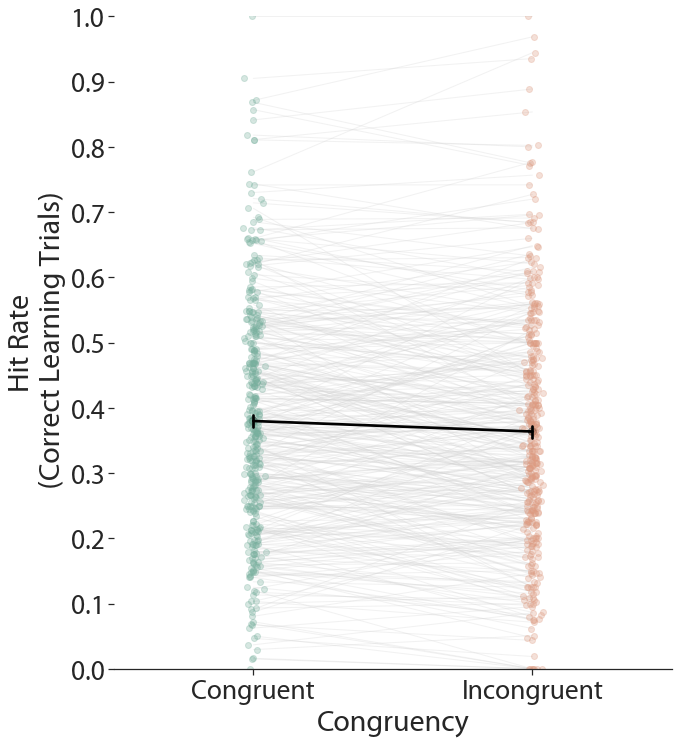

In [337]:
fig, ax = plt.subplots(figsize=(10, 12));

sns.lineplot(data=combineddf,x="Congruency" , y="Hit", units="subject", color='lightgrey', alpha=0.3, estimator=None,lw=1)
plt.plot(Congtrials.xj,Congtrials.Hit,'o', color='#78b09e', alpha=0.3)
plt.plot(Incongtrials.xj,Incongtrials.Hit,'o', color='#dd9b81', alpha=0.3)
sns.pointplot(data=combineddf,x="Congruency", y="Hit", color="black", ci=68)
ax.set_ylim(0,1.0);
ax.set_xlim(-0.5,1.50);
ax.set_xticklabels(('Congruent','Incongruent'));
ax.set_xticks([0, 1]);
ax.set_yticks(np.arange(0, 1.01, 0.1));
plt.ylabel('Hit Rate\n (Correct Learning Trials)');
plt.xlabel('Congruency');
sns.despine(ax=ax, left=True)

plb.savefig(figurepath+"success_cong_early.png", dpi=300, bbox_inches='tight');

Finally, a core assumption underlying the control-learning perspective is that people adapt to changes in contextual control demand, which implies that learning should be taking place when moving from one PC context to another. This assumption would predict more attention to feedback when new control demands are being learned, that is, at the beginning of each context. Accordingly, we reanalyzed the data to focus on the “context shifts”, i.e., the first block in which participants experienced a new PC context. Here, we thus grouped blocks 1 and 3 together as the “first” blocks of each context and blocks 2 and 4 as the “last” blocks of each context, and dropped the within-participants PC factor within the analysis, since the new context shift factor and the block order factor already carry the PC information.

In [338]:
Hit_CHComb = mdat3.groupby(['subject','ContextHalf','Congruency','BlockOrder', 'Feedback'])['Hit'].count().reset_index()

In [339]:
exclhit = [];
for i in range(0,len(Hit_CHComb)):
    sub = Hit_CHComb.Hit.reset_index()
    
    if (sub.Hit[i] < 10):
        exclhit.append(1)
    else: exclhit.append(0)
        
Hit_CHComb['exclhit'] = exclhit

In [340]:
CHcountComb = (Hit_CHComb[Hit_CHComb.exclhit == 1].subject).reset_index()

In [341]:
Hit_Anova_CHComb = mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','ContextHalf','Congruency','BlockOrder', 'Feedback'])['Hit'].mean().reset_index()
Hit_Anova_CHComb.to_csv(csvpath+'Hit_Anova_CHComb.csv')

In [342]:
%%writefile HitAnova_CHComb.R

install.packages("afex",repos='https://mirrors.nics.utk.edu/cran/')
library(afex)

rawHitdata_CH <- read.csv('Hit_Anova_CHComb.csv')
aov_car(Hit ~ BlockOrder*Feedback + Error(subject/(Congruency*ContextHalf)), data = rawHitdata_CH, anova_table = list(es = "pes"))

Overwriting HitAnova_CHComb.R


In [343]:
! Rscript HitAnova_CHComb.R

Anova Table (Type 3 tests)

Response: Hit
                                       Effect     df  MSE          F    pes
1                                  BlockOrder 1, 386 0.12       0.07  .0002
2                                    Feedback 1, 386 0.12       0.71   .002
3                         BlockOrder:Feedback 1, 386 0.12       1.40   .004
4                                  Congruency 1, 386 0.01     4.30 *    .01
5                       BlockOrder:Congruency 1, 386 0.01  29.89 ***    .07
6                         Feedback:Congruency 1, 386 0.01       0.09  .0002
7              BlockOrder:Feedback:Congruency 1, 386 0.01       0.02 <.0001
8                                 ContextHalf 1, 386 0.01 110.49 ***    .22
9                      BlockOrder:ContextHalf 1, 386 0.01       1.01   .003
10                       Feedback:ContextHalf 1, 386 0.01       0.45   .001
11            BlockOrder:Feedback:ContextHalf 1, 386 0.01       0.10  .0003
12                     Congruency:ContextHalf 

Warning message:
package 'afex' is not available (for R version 3.4.3) 
Loading required package: lme4
Loading required package: Matrix
Loading required package: methods
************
Welcome to afex. For support visit: http://afex.singmann.science/
- Functions for ANOVAs: aov_car(), aov_ez(), and aov_4()
- Methods for calculating p-values with mixed(): 'KR', 'S', 'LRT', and 'PB'
- 'afex_aov' and 'mixed' objects can be passed to emmeans() for follow-up tests
- NEWS: library('emmeans') now needs to be called explicitly!
- Get and set global package options with: afex_options()
- Set orthogonal sum-to-zero contrasts globally: set_sum_contrasts()
- For example analyses see: browseVignettes("afex")
************

Attaching package: 'afex'

The following object is masked from 'package:lme4':

    lmer

Warning message:
package 'lme4' was built under R version 3.4.4 
Contrasts set to contr.sum for the following variables: BlockOrder, Feedback


We observed larger Hit rates for “first” context blocks (M = 0.38) relative to the “last” context blocks (M = 0.33) (N = 390, F(1,386) = 110.49, p < 0.001, ηp2 = 0.22, inclusion BF = 3.49 x 1025). This effect supports the notion that participants paid more attention to reinforcement feedback events when a context was new (at the beginning of the task and when the context changes) or – put a different way – that they became less sensitive or attentive towards feedbackreinforcement later in the blocks within each PC context, when adaptation to the current level of control demand had presumably been achieved. 

However, we also observed evidence of context-dependent shifts in attention towards feedbackreinforcement: there was both a significant block order by congruency interaction (F(1,386) = 29.89, p < 0.001, ηp2 = 0.07, inclusion BF = 7.87 x 105) and a block order by congruency by context shift interaction (F(1,386) = 21.44, p < 0.001, ηp2 = 0.05, inclusion BF = 152.94; as before, congruency: F(1,386) = 4.30, p = 0.039, ηp2 = 0.05, inclusion BF = 0.66, all other effects, F < 1.85, BFs < 1). Recapitulating the effects reported in the previous analysis, participants who experienced the mostly congruent context first showed better memory for images following congruent trials (Mdiff = 0.03), while participants who experienced the mostly incongruent context first showed better memory for images following incongruent trials (Mdiff = 0.01). Participants were thus most sensitive to feedbackreinforcement for trials that were most frequent in the context they experienced first, i.e., the trials that established the context, and this effect faded over time. As shown in Figure 6C, participants showed the memory benefit for images following the most frequent trial type from their first context in early blocks (MC first: Mdiff = 0.05; MIC first: Mdiff = 0.02). This context-dependent benefit for memory diminished in the later context shifts (MC first: Mdiff = 0.01; MIC first: Mdiff = 0.00).

In sum, we obtained evidence suggesting that statistical learning plays a larger role in control-learning than potential differences in motivation. Participants had context-dependent memory benefits in that they were more sensitive to images that followed the most frequent (context-defining) trial type from the context they experienced first. This pattern of encoding of reinforcement events was stronger for the PC-75 context, consistent with the stronger correlation between biased and unbiased item congruency effects for the PC-75 context.  Contrary to a more motivational-based account of control-learning, we also found generally stronger memory for images following congruent than following incongruent trials. Altogether, these results mirror what we observed in the Learning Phase data: participants appear to anchor their expectations of upcoming control-demand to the context they learned first.

In [344]:
#context half
maineffectCH=mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','ContextHalf'])['Hit'].mean()
grpmean = pd.Series.mean(maineffectCH, level=1)
(grpmean), grpmean[1] - grpmean[0]

#block order x congruency
BOCong=mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','BlockOrder', 'Congruency'])['Hit'].mean().reset_index()
CongFirstCong = BOCong.loc[BOCong['Congruency'] == 'Incongruent'].loc[BOCong['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - BOCong.loc[BOCong['Congruency'] == 'Congruent'].loc[BOCong['BlockOrder'] == 'MCfirst'].reset_index()['Hit']
IncongFirstCong = BOCong.loc[BOCong['Congruency'] == 'Incongruent'].loc[BOCong['BlockOrder'] == 'MICfirst'].reset_index()['Hit'] - BOCong.loc[BOCong['Congruency'] == 'Congruent'].loc[BOCong['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
(CongFirstCong.mean()), (IncongFirstCong.mean())

#block order x congruency x context half
BOCongCH=mdat3.loc[~mdat3['subject'].isin(CHcountComb.subject)].groupby(['subject','ContextHalf', 'Congruency', 'BlockOrder'])['Hit'].mean().reset_index()
MC_Cong_E = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'MCfirst'].reset_index()['Hit']
MIC_Cong_E = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'MICfirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Early'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
MC_Cong_L = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'MCfirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'MCfirst'].reset_index()['Hit']
MIC_Cong_L = BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Incongruent'].loc[BOCongCH['BlockOrder'] == 'MICfirst'].reset_index()['Hit'] - BOCongCH.loc[BOCongCH['ContextHalf'] == 'Late'].loc[BOCongCH['Congruency'] == 'Congruent'].loc[BOCongCH['BlockOrder'] == 'MICfirst'].reset_index()['Hit']
(MC_Cong_E.mean(), MIC_Cong_E.mean()), (MC_Cong_L.mean(), MIC_Cong_L.mean())

(ContextHalf
 Early    0.375618
 Late     0.333502
 Name: Hit, dtype: float64, -0.04211559246754937)

(-0.028796160350824166, 0.012605511626200739)

((-0.04633349552966148, 0.02258532061632467),
 (-0.01087181769194806, 0.003161694593012997))

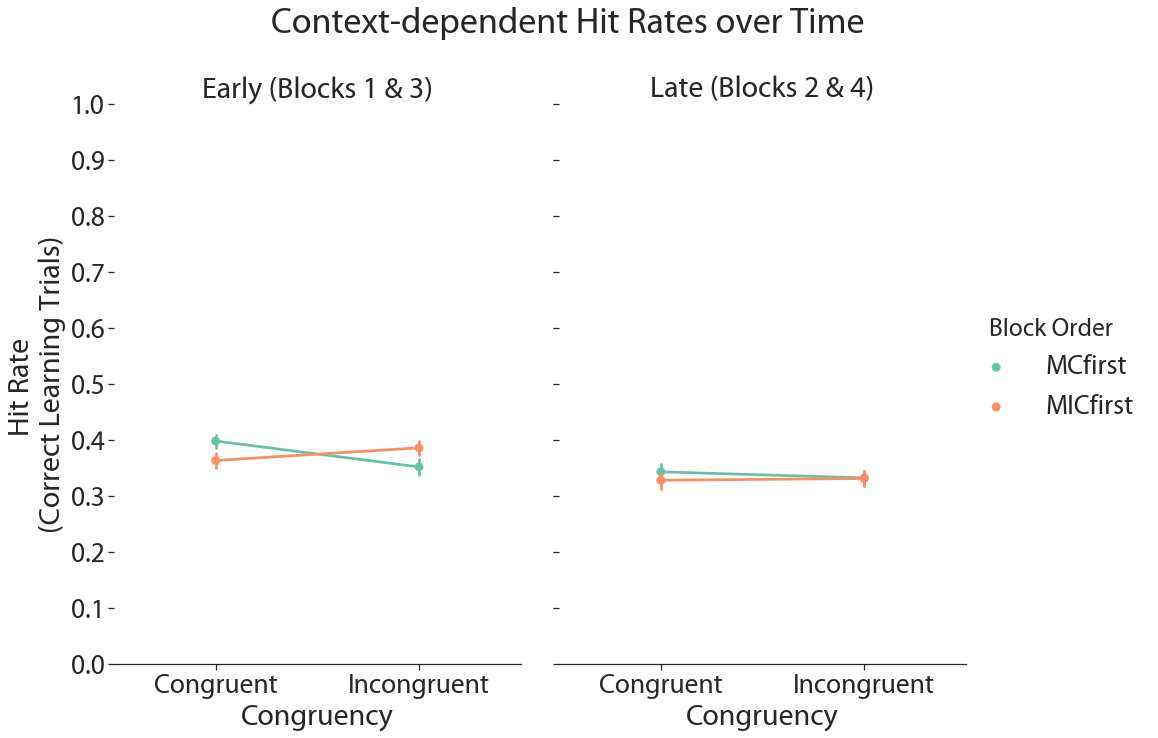

In [345]:
mygraph('Congruency','Hit','BlockOrder',['Congruent','Incongruent'],'ContextHalf',["Early (Blocks 1 & 3)", "Late (Blocks 2 & 4)"],BOCongCH,'Congruency','Hit Rate \n(Correct Learning Trials)','Context-dependent Hit Rates over Time','Block Order',0,1.0,'Hit_CH_BOCong.png',0.1)